# **Insurance Loss Prediction: Modeling Overview**

This notebook presents a comprehensive pipeline for modeling insurance claim severity across two targets:

- **Loss Cost (LC)**: Direct cost of a claim
- **Historically Adjusted Loss Cost (HALC)**: Cost adjusted for historical patterns

The data exhibits **zero inflation** (most customers have no claims) and **extreme right skew** (a few very large claims), requiring specialized modeling strategies.

## **Objectives**

1. **Predict LC and HALC** with accuracy and robustness across the full severity spectrum.
2. **Compare model types** ranging from statistical baselines to advanced machine learning and neural networks.
3. **Handle domain-specific challenges**:
   - High proportion of zero claims
   - Long-tail loss distribution
   - Feature interactions and nonlinearities

## **Models Implemented**

- **GLM Tweedie**: Linear statistical baseline for zero-inflated continuous targets.
- **XGBoost Tweedie**: One-part boosting with tuned Tweedie objective and SHAP interpretability.
- **LightGBM (Tweedie, Gamma, Quantile, EVT)**: Iteratively tuned boosting models with SHAP-based feature selection and ensemble enhancements.
- **Two-Stage LightGBM**: Classifier + gamma regressor for frequency and severity.
- **Three-Part LightGBM**: Segmented model for low vs. high claim severity with custom calibration.
- **Zero-Inflated Tweedie (XGBoost)**: Two-part model capturing zero probability and conditional severity.
- **CatBoost (1-part and zero-inflated log)**: Tree-based model with native categorical handling.
- **Neural Networks**: Deep feedforward regressors trained on log-transformed targets.

## Key Takeaways

- **XGBoost Two-Part (Zero-Inflated Tweedie)** achieved the best balance between performance and simplicity.
- **Three-Part LightGBM** provided the most detailed segmentation and strongest R², especially for LC.
- **Neural Nets** captured broad trends but struggled with long-tail claims.
- **SHAP** values enhanced interpretability and guided effective feature selection.

> This notebook serves as a modular, extensible framework for modeling skewed, zero-inflated insurance loss outcomes using modern ML techniques.


# **Data Loading**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Main imports
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                            confusion_matrix, roc_curve, auc, classification_report,
                            accuracy_score, precision_score, recall_score, f1_score)
from sklearn.linear_model import (LogisticRegression, Ridge, Lasso,
                                TweedieRegressor, HuberRegressor, GammaRegressor)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                            RandomForestClassifier)
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# Load train and test data
train_clean= pd.read_csv('/content/drive/MyDrive/DSO 530 Group Project/final_data_train.csv')
test_clean = pd.read_csv('/content/drive/MyDrive/DSO 530 Group Project/final_data_test.csv')

# Display first 5 rows and info
print("Training data preview:")
display(train_clean.head())
display(train_clean.info())

print("\nTest data preview:")
display(test_clean.head())
display(test_clean.info())

Training data preview:


,contract_channel,years_with_company,total_policies,max_policies_held,max_products_held,cancelled_policies_current_year,payment_method,net_premium,region_type,multiple_drivers,...,driver_age_cat_45-55,driver_age_cat_55-65,driver_age_cat_65+,vehicle_age_cat_Mature,vehicle_age_cat_Old,driving_exp_cat_Intermediate,driving_exp_cat_Experienced,power_cat_Standard,power_cat_High,power_cat_Premium
0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,573.07,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,1.0,1.0,1.0,0.0,0.0,299.19,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,20.0,2.0,2.0,1.0,0.0,0.0,257.66,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,8.0,2.0,3.0,1.0,0.0,0.0,288.70,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,9.0,1.0,1.0,1.0,0.0,0.0,741.16,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37451 entries, 0 to 37450
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   contract_channel                 37451 non-null  float64
 1   years_with_company               37451 non-null  float64
 2   total_policies                   37451 non-null  float64
 3   max_policies_held                37451 non-null  float64
 4   max_products_held                37451 non-null  float64
 5   cancelled_policies_current_year  37451 non-null  float64
 6   payment_method                   37451 non-null  float64
 7   net_premium                      37451 non-null  float64
 8   region_type                      37451 non-null  float64
 9   multiple_drivers                 37451 non-null  float64
 10  vehicle_power_hp                 37451 non-null  float64
 11  vehicle_cylinder_capacity        37451 non-null  float64
 12  vehicle_market_val

None


Test data preview:


,contract_channel,years_with_company,total_policies,max_policies_held,max_products_held,cancelled_policies_current_year,payment_method,net_premium,region_type,multiple_drivers,...,driver_age_cat_45-55,driver_age_cat_55-65,driver_age_cat_65+,vehicle_age_cat_Mature,vehicle_age_cat_Old,driving_exp_cat_Intermediate,driving_exp_cat_Experienced,power_cat_Standard,power_cat_High,power_cat_Premium
0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,240.76,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,2.0,1.0,1.0,1.0,1.0,1.0,367.97,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,1.0,4.0,4.0,2.0,0.0,0.0,291.90,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,5.0,1.0,1.0,1.0,0.0,0.0,303.28,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,3.0,1.0,1.0,1.0,1.0,0.0,333.30,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15787 entries, 0 to 15786
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   contract_channel                 15787 non-null  float64
 1   years_with_company               15787 non-null  float64
 2   total_policies                   15787 non-null  float64
 3   max_policies_held                15787 non-null  float64
 4   max_products_held                15787 non-null  float64
 5   cancelled_policies_current_year  15787 non-null  float64
 6   payment_method                   15787 non-null  float64
 7   net_premium                      15787 non-null  float64
 8   region_type                      15787 non-null  float64
 9   multiple_drivers                 15787 non-null  float64
 10  vehicle_power_hp                 15787 non-null  float64
 11  vehicle_cylinder_capacity        15787 non-null  float64
 12  vehicle_market_val

None

In [ ]:
train_data = train_clean.copy()
test_data = test_clean.copy()

In [ ]:
train_data.shape

(37451, 50)

# **GLM**

## **GLM Tweedie Baseline Modeling**

Generalized Linear Models (GLMs) with a Tweedie distribution were implemented as baseline models for the regression targets:

- **Loss Cost (LC)** and **Historically Adjusted Loss Cost (HALC)** are non-negative, continuous, and highly right-skewed with excess zeros.
- The Tweedie distribution is suitable for such compound Poisson-Gamma data, commonly used in actuarial modeling.

The models were trained using 47 engineered and encoded features, with no strong evidence of data leakage. Model performance was evaluated on a hold-out validation set using standard regression metrics:

- **LC**: RMSE = 881.37, MAE = 136.72, R² ≈ 0.000
- **HALC**: RMSE = 1483.35, MAE = 244.77, R² ≈ 0.000

As expected with a simple linear baseline, the model struggles to capture the extreme skew and heteroskedasticity of the data. Predictions cluster near zero, with limited sensitivity to high-loss observations.

The scatter plots below compare actual and predicted values for LC and HALC. The dashed red line represents perfect prediction (y = x).


Training on 47 features | Sample: Index(['contract_channel', 'years_with_company', 'total_policies',
       'max_policies_held', 'max_products_held',
       'cancelled_policies_current_year', 'payment_method', 'net_premium',
       'region_type', 'multiple_drivers', 'vehicle_power_hp',
       'vehicle_cylinder_capacity', 'vehicle_market_value',
       'num_vehicle_doors', 'vehicle_weight_kg', 'driver_age_at_policy_start',
       'driving_experience', 'vehicle_age', 'policy_duration',
       'driver_risk_score', 'vehicle_risk_score', 'young_driver_high_power',
       'new_license_high_power', 'power_weight_ratio',
       'premium_to_value_ratio', 'customer_loyalty_score',
       'payment_reliability', 'non_continuation_flag', 'young_driver',
       'age_at_license', 'vehicle_risk_type_2', 'vehicle_risk_type_3',
       'vehicle_risk_type_4', 'energy_source_O', 'energy_source_P',
       'driver_age_cat_25-35', 'driver_age_cat_35-45', 'driver_age_cat_45-55',
       'driver_age_cat_55-65', 

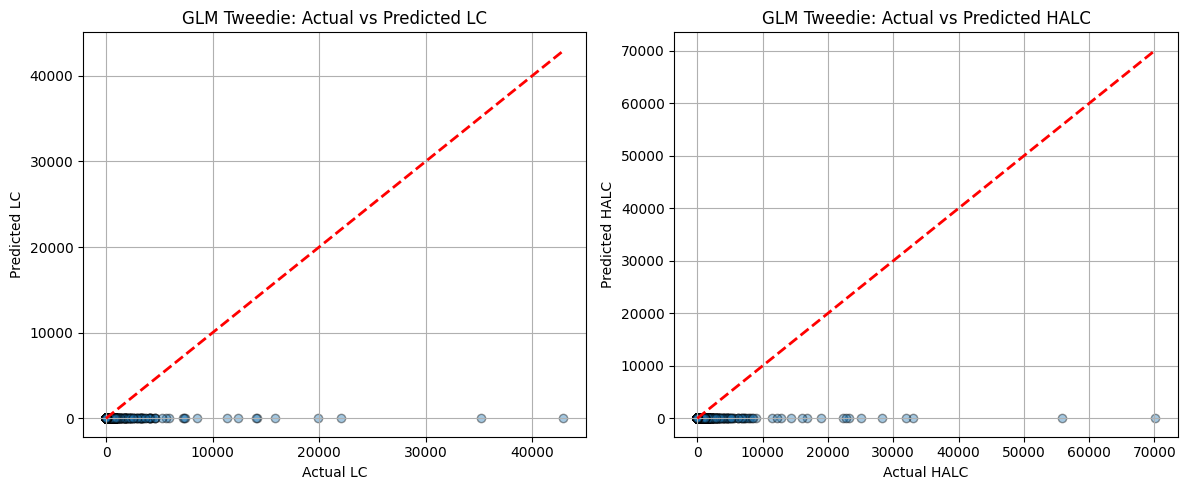

In [ ]:
# === Step 0: Imports ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# === Step 1: Copy Raw Train Data ===
train = train_data.copy()

# === Step 2: Prepare Features and Targets ===
drop_cols = ['HALC', 'LC', 'CS']
X = train.drop(columns=drop_cols, errors='ignore')
y_halc = train['HALC']
y_lc = train['LC']

# === Step 3: Align with Test Data Features ===
test_features = test_data.drop(columns=['LC', 'HALC', 'CS'], errors='ignore')
X, test_features = X.align(test_features, join='left', axis=1, fill_value=0)
X.fillna(0, inplace=True)
test_features.fillna(0, inplace=True)
print(f"Training on {X.shape[1]} features | Sample: {X.columns}")
print(f"Testing on {test_features.shape[1]} features | Sample: {test_features.columns}")

# === Step 4: Train-Test Split ===
X_train, X_val, y_train_lc, y_val_lc, y_train_halc, y_val_halc = train_test_split(
    X, y_lc, y_halc, test_size=0.2, random_state=42)

# === Step 5: Train GLM Tweedie Models ===
glm_tweedie_lc = TweedieRegressor(power=1.5, alpha=0.5)
glm_tweedie_lc.fit(X_train, y_train_lc)

glm_tweedie_halc = TweedieRegressor(power=1.5, alpha=0.5)
glm_tweedie_halc.fit(X_train, y_train_halc)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Step 6: Predict & Evaluate (Standardized Metrics) ===
# LC
y_pred_glm_lc = glm_tweedie_lc.predict(X_val)
mse_lc = mean_squared_error(y_val_lc, y_pred_glm_lc)
rmse_lc = np.sqrt(mse_lc)
mae_lc = mean_absolute_error(y_val_lc, y_pred_glm_lc)
r2_lc = r2_score(y_val_lc, y_pred_glm_lc)

# HALC
y_pred_glm_halc = glm_tweedie_halc.predict(X_val)
mse_halc = mean_squared_error(y_val_halc, y_pred_glm_halc)
rmse_halc = np.sqrt(mse_halc)
mae_halc = mean_absolute_error(y_val_halc, y_pred_glm_halc)
r2_halc = r2_score(y_val_halc, y_pred_glm_halc)

# === Print All Metrics Clearly ===
print("\n=== GLM Tweedie Model Performance ===")
print(f"LC   | MSE: {mse_lc:.2f} | RMSE: {rmse_lc:.2f} | MAE: {mae_lc:.2f} | R²: {r2_lc:.4f}")
print(f"HALC | MSE: {mse_halc:.2f} | RMSE: {rmse_halc:.2f} | MAE: {mae_halc:.2f} | R²: {r2_halc:.4f}")

# === Step 7: Actual vs Predicted Plots ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(y_val_lc, y_pred_glm_lc, alpha=0.4, edgecolor='k')
ax1.plot([y_val_lc.min(), y_val_lc.max()], [y_val_lc.min(), y_val_lc.max()], 'r--', linewidth=2)
ax1.set_xlabel('Actual LC')
ax1.set_ylabel('Predicted LC')
ax1.set_title('GLM Tweedie: Actual vs Predicted LC')
ax1.grid(True)

ax2.scatter(y_val_halc, y_pred_glm_halc, alpha=0.4, edgecolor='k')
ax2.plot([y_val_halc.min(), y_val_halc.max()], [y_val_halc.min(), y_val_halc.max()], 'r--', linewidth=2)
ax2.set_xlabel('Actual HALC')
ax2.set_ylabel('Predicted HALC')
ax2.set_title('GLM Tweedie: Actual vs Predicted HALC')
ax2.grid(True)

plt.tight_layout()
plt.show()

# **XGBoost**

#### **XGBoost Tweedie Modeling Overview**

XGBoost regressors were trained for both LC and HALC targets using the Tweedie distribution (`tweedie_variance_power` tuned via randomized search). The modeling pipeline included train-validation splits, feature alignment, hyperparameter tuning, and evaluation using RMSE and R² metrics.

#### **Model Performance**

Final tuned models demonstrated improved performance over GLM baselines:

- **LC**:  
  RMSE = **747.46**, MAE = 102.74, R² = 0.2805  
- **HALC**:  
  RMSE = **1160.02**, MAE = 180.63, R² = 0.3883

Performance was evaluated on held-out validation sets. Actual vs. predicted plots revealed improved tracking across a wider range of target values, with reduced residual spread compared to baseline.

#### **Hyperparameter Optimization**

Randomized search with early stopping was used to tune XGBoost parameters. Key tuned hyperparameters:

- **LC**:
  - `n_estimators`: 303
  - `learning_rate`: 0.0383
  - `max_depth`: 5
  - `min_child_weight`: 3.62
  - `subsample`: 0.96
  - `colsample_bytree`: 0.70
  - `reg_alpha`: 2.14
  - `reg_lambda`: 2.77
  - `tweedie_variance_power`: 1.36

- **HALC**:
  - `n_estimators`: 416
  - `learning_rate`: 0.0118
  - `max_depth`: 6
  - `min_child_weight`: 8.49
  - `subsample`: 0.89
  - `colsample_bytree`: 0.77
  - `reg_alpha`: 0.08
  - `reg_lambda`: 4.03
  - `tweedie_variance_power`: 1.22

#### **SHAP Feature Importance**

SHAP values were computed on the validation set to quantify feature contributions and improve interpretability:

- **Top features for LC** included `policy_duration`, `net_premium`, `customer_loyalty_score`, and `vehicle_market_value`.
- **Top features for HALC** similarly emphasized `vehicle_market_value`, `policy_duration`, and `premium_to_value_ratio`.

Bar plots ranked features by mean SHAP value. Beeswarm plots further illustrated the distribution and impact of feature values on predictions. Most influential features showed consistent directionality (e.g., longer policy duration → higher predicted loss).

#### **Feature Optimization**

SHAP-based pruning was conducted to identify the optimal subset of features. Validation RMSE was plotted against the number of top SHAP features:

- For LC, performance stabilized beyond the top 10–15 features.
- For HALC, minimal gain was observed beyond the top 15 features.

This informed the final feature set selection for modeling, reducing dimensionality without compromising accuracy.



### **XGBoost Tweedie Baseline**

Training LC model...
Training HALC model...

=== XGBoost Model Performance ===
LC | MSE: 804870.44 | RMSE: 897.15 | MAE: 136.89 | R²: -0.0365
HALC | MSE: 2490680.20 | RMSE: 1578.19 | MAE: 244.42 | R²: -0.1322

Generating SHAP summary plots...


 98%|===================| 7352/7491 [00:44<00:00]       

SHAP Bar Plot: LC


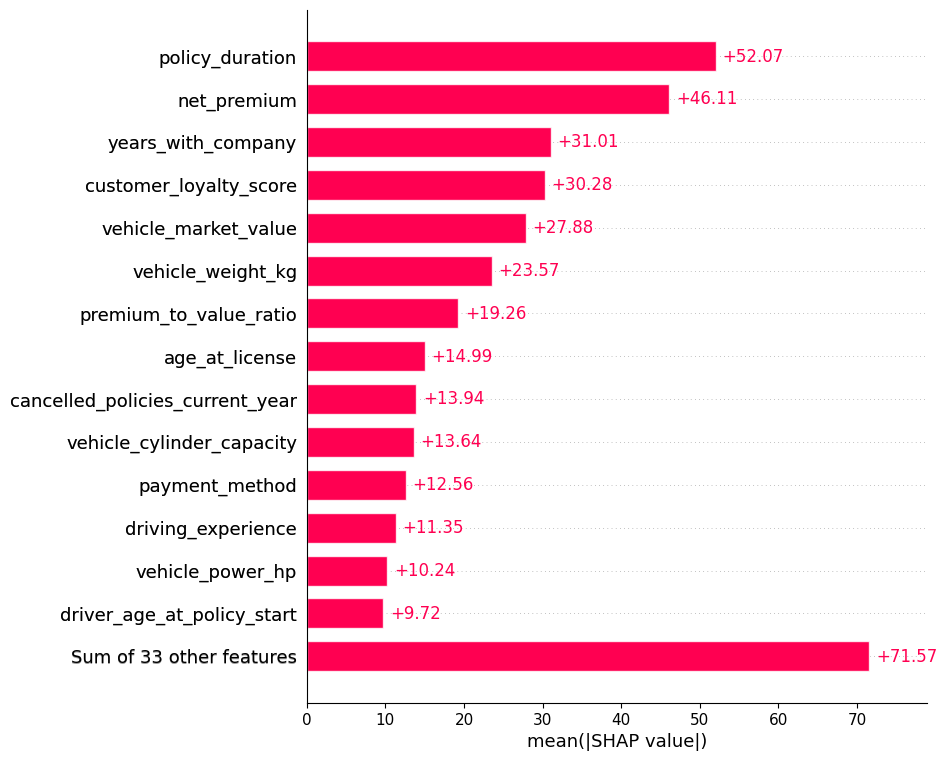

SHAP Bar Plot: HALC


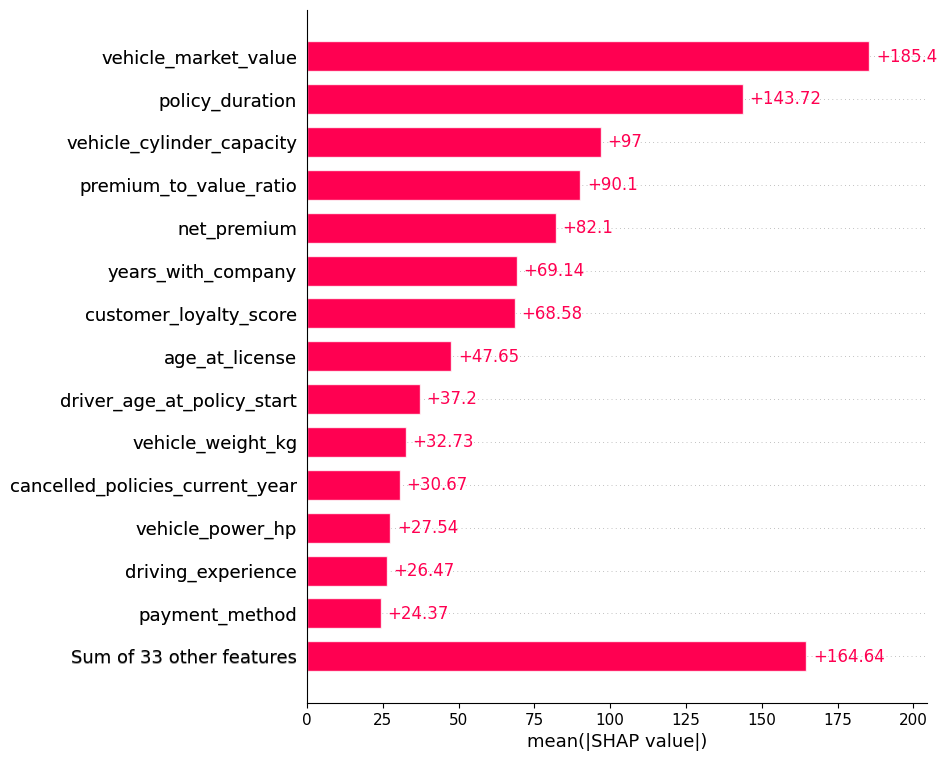

SHAP Beeswarm: LC


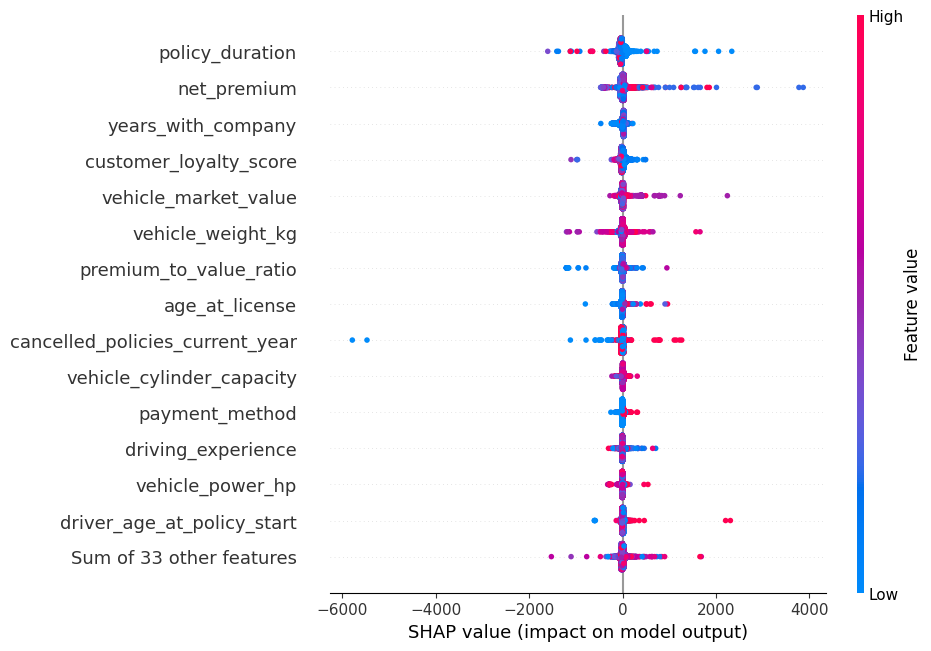

SHAP Beeswarm: HALC


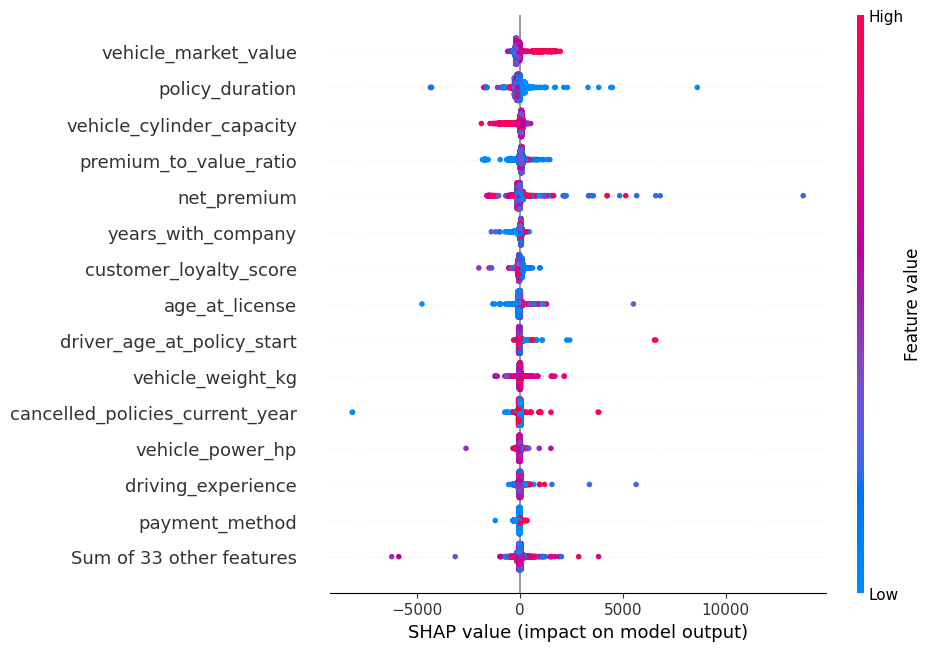

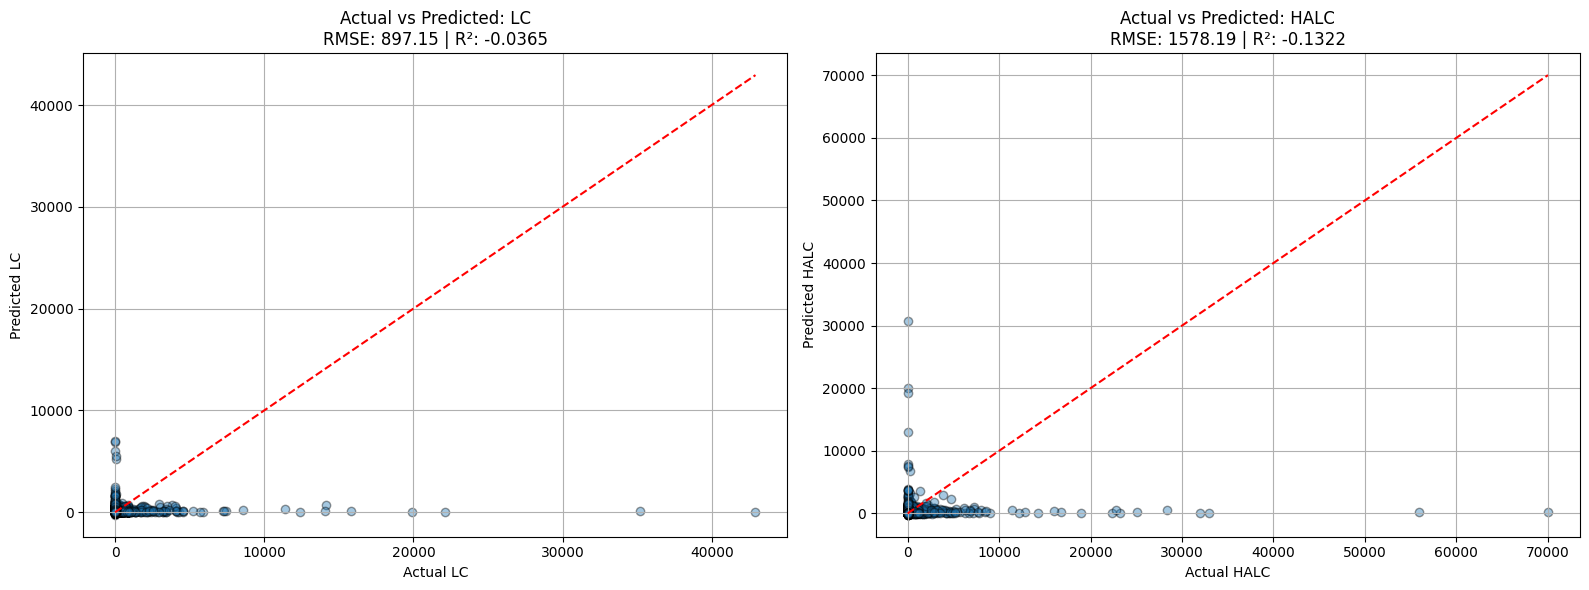

In [ ]:
# === Step 0: Imports ===
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Step 1: Data Preparation ===
train = train_data.copy()
test = test_data.copy()
drop_cols = ['LC', 'HALC', 'CS', 'LC_log', 'HALC_log']
X = train.drop(columns=drop_cols, errors='ignore')
y_lc = train['LC']
y_halc = train['HALC']

# === Step 2: Train-Test Split ===
X_train, X_val, y_train_lc, y_val_lc, y_train_halc, y_val_halc = train_test_split(
    X, y_lc, y_halc, test_size=0.2, random_state=42
)

# === Step 3: Train XGBoost Regressors ===
xgb_lc = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_halc = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)

print("Training LC model...")
xgb_lc.fit(X_train, y_train_lc)
print("Training HALC model...")
xgb_halc.fit(X_train, y_train_halc)

# === Step 4: Evaluate Models ===
def evaluate_model(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")
    return mse, rmse, mae, r2

print("\n=== XGBoost Model Performance ===")
y_pred_lc = xgb_lc.predict(X_val)
y_pred_halc = xgb_halc.predict(X_val)

metrics_lc = evaluate_model(y_val_lc, y_pred_lc, "LC")
metrics_halc = evaluate_model(y_val_halc, y_pred_halc, "HALC")

# === Step 5: SHAP Summary Plots ===
print("\nGenerating SHAP summary plots...")

explainer_lc = shap.Explainer(xgb_lc, X_val)
shap_values_lc = explainer_lc(X_val)

explainer_halc = shap.Explainer(xgb_halc, X_val)
shap_values_halc = explainer_halc(X_val)

# SHAP Bar Plot - LC
print("SHAP Bar Plot: LC")
shap.plots.bar(shap_values_lc, max_display=15)

# SHAP Bar Plot - HALC
print("SHAP Bar Plot: HALC")
shap.plots.bar(shap_values_halc, max_display=15)

# SHAP Beeswarm Plots
print("SHAP Beeswarm: LC")
shap.plots.beeswarm(shap_values_lc, max_display=15)

print("SHAP Beeswarm: HALC")
shap.plots.beeswarm(shap_values_halc, max_display=15)

# === Step 6: Actual vs Predicted Plots ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LC
ax1.scatter(y_val_lc, y_pred_lc, alpha=0.4, edgecolor='k')
ax1.plot([y_val_lc.min(), y_val_lc.max()], [y_val_lc.min(), y_val_lc.max()], 'r--')
ax1.set_title(f'Actual vs Predicted: LC\nRMSE: {metrics_lc[1]:.2f} | R²: {metrics_lc[3]:.4f}')
ax1.set_xlabel('Actual LC')
ax1.set_ylabel('Predicted LC')
ax1.grid(True)

# HALC
ax2.scatter(y_val_halc, y_pred_halc, alpha=0.4, edgecolor='k')
ax2.plot([y_val_halc.min(), y_val_halc.max()], [y_val_halc.min(), y_val_halc.max()], 'r--')
ax2.set_title(f'Actual vs Predicted: HALC\nRMSE: {metrics_halc[1]:.2f} | R²: {metrics_halc[3]:.4f}')
ax2.set_xlabel('Actual HALC')
ax2.set_ylabel('Predicted HALC')
ax2.grid(True)

plt.tight_layout()
plt.show()


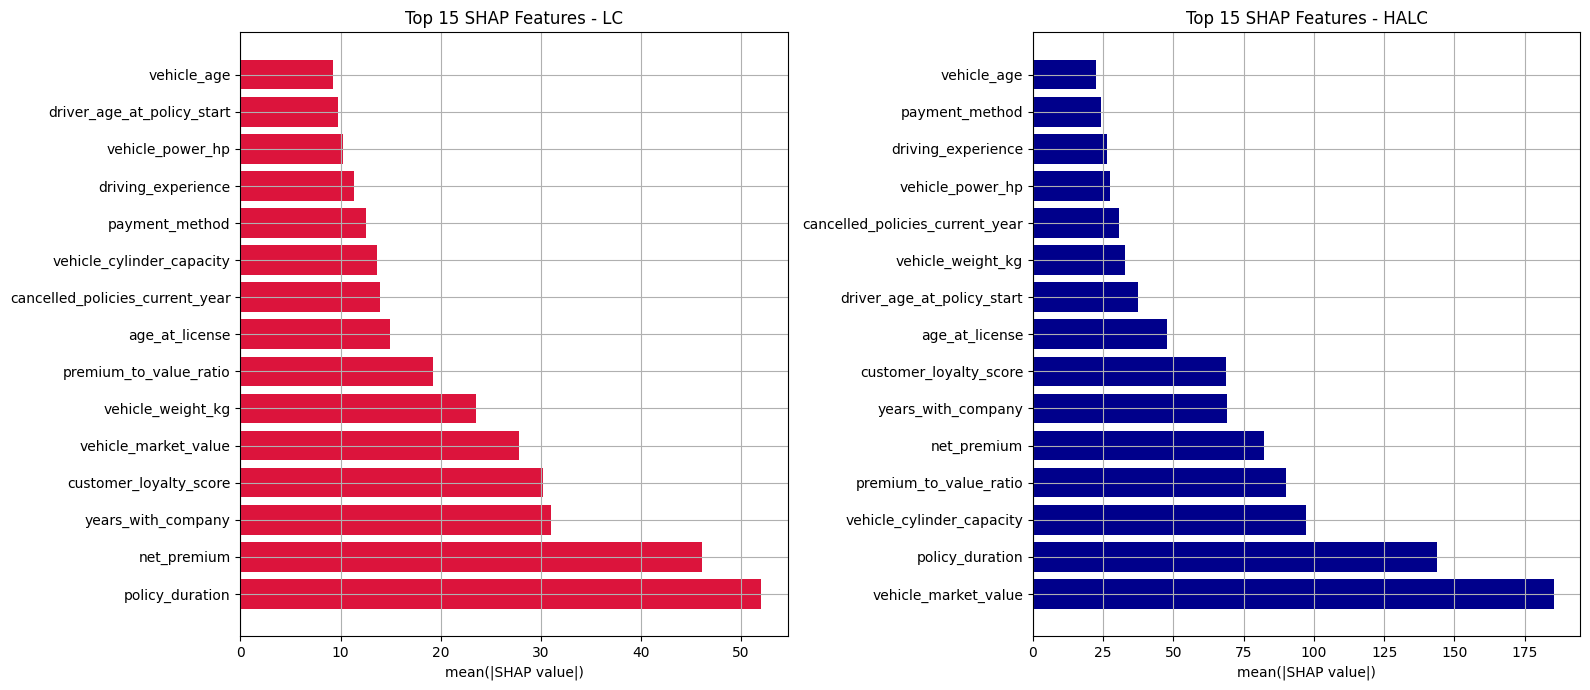

In [ ]:
import matplotlib.pyplot as plt

# Get mean absolute SHAP values
shap_lc_mean = np.abs(shap_values_lc.values).mean(axis=0)
shap_halc_mean = np.abs(shap_values_halc.values).mean(axis=0)

# Create DataFrames
df_lc = pd.DataFrame({'feature': X_val.columns, 'shap_value': shap_lc_mean})
df_halc = pd.DataFrame({'feature': X_val.columns, 'shap_value': shap_halc_mean})

# Sort top 15
df_lc = df_lc.sort_values(by='shap_value', ascending=False).head(15)
df_halc = df_halc.sort_values(by='shap_value', ascending=False).head(15)

# Create two independent subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # Removed sharey=True

# LC Plot
axes[0].barh(df_lc['feature'][::-1], df_lc['shap_value'][::-1], color='crimson')
axes[0].set_title('Top 15 SHAP Features - LC')
axes[0].set_xlabel('mean(|SHAP value|)')
axes[0].invert_yaxis()
axes[0].grid(True)

# HALC Plot
axes[1].barh(df_halc['feature'][::-1], df_halc['shap_value'][::-1], color='darkblue')
axes[1].set_title('Top 15 SHAP Features - HALC')
axes[1].set_xlabel('mean(|SHAP value|)')
axes[1].invert_yaxis()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### **Tuned XGBoost Tweedie**


 Tuning Number of Features (LC):


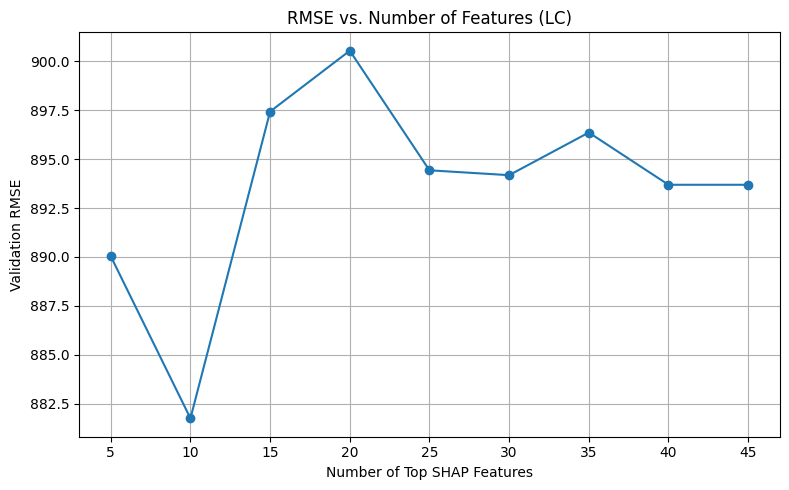


 Tuning Number of Features (HALC):


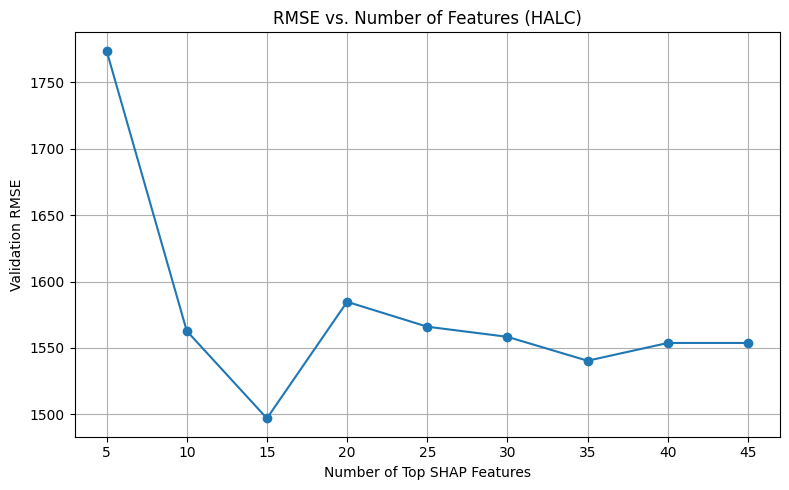

In [ ]:
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

def rmse_vs_feature_count(X, y, shap_values, label):
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    shap_importance = pd.Series(mean_shap, index=X.columns).sort_values(ascending=False)
    feature_counts = list(range(5, min(51, len(shap_importance) + 1), 5))
    rmse_scores = []

    for k in feature_counts:
        top_k_features = shap_importance.head(k).index.tolist()
        X_k = X[top_k_features]
        X_train_k, X_val_k, y_train_k, y_val_k = train_test_split(
            X_k, y, test_size=0.2, random_state=42
        )

        model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
        model.fit(X_train_k, y_train_k)
        preds = model.predict(X_val_k)
        rmse = np.sqrt(mean_squared_error(y_val_k, preds))
        rmse_scores.append(rmse)

    # Plot RMSE vs # of Features
    plt.figure(figsize=(8, 5))
    plt.plot(feature_counts, rmse_scores, marker='o')
    plt.title(f'RMSE vs. Number of Features ({label})')
    plt.xlabel('Number of Top SHAP Features')
    plt.ylabel('Validation RMSE')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({'n_features': feature_counts, 'rmse': rmse_scores})

# === Run for LC and HALC ===
print("\n Tuning Number of Features (LC):")
rmse_lc_df = rmse_vs_feature_count(X, y_lc, shap_values_lc, 'LC')

print("\n Tuning Number of Features (HALC):")
rmse_halc_df = rmse_vs_feature_count(X, y_halc, shap_values_halc, 'HALC')


**Feature Selection via Stratified CV**

- Used custom stratified K-Fold logic (qcut for regression, binary stratification for classification).

- Trained base XGBoost models (reg:tweedie for LC/HALC, binary:logistic for CS) to get average feature importances across 5 folds.

- Selected the top 20 most predictive features for each target separately, reducing dimensionality and improving generalizability.

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# === Step 1: Prepare Feature Set ===
drop_cols = ['LC', 'HALC', 'CS', 'LC_log', 'HALC_log']
feature_cols = [col for col in train.columns if col not in drop_cols]
X_encoded = train[feature_cols]

# === Step 2: Feature Selection Function ===
def get_top_features(X_data, y_target, n_splits=5, n_estimators=300):
    y_bins = pd.qcut(y_target, q=4, labels=False, duplicates='drop')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    feature_scores = pd.DataFrame(index=X_data.columns)

    for fold, (train_idx, _) in enumerate(skf.split(X_data, y_bins)):
        model = xgb.XGBRegressor(objective='reg:tweedie', n_estimators=n_estimators, random_state=42)
        model.fit(X_data.iloc[train_idx], y_target.iloc[train_idx])
        fold_importance = pd.Series(model.feature_importances_, index=X_data.columns, name=f'fold_{fold+1}')
        feature_scores = pd.concat([feature_scores, fold_importance], axis=1)

    feature_scores['mean_importance'] = feature_scores.mean(axis=1)
    return feature_scores['mean_importance'].sort_values(ascending=False)

# === Step 3: Run Feature Importance Selection ===
print("Calculating top features using SHAP-informed XGBoost...")

top_features_lc = get_top_features(X_encoded, train['LC'])
top_features_halc = get_top_features(X_encoded, train['HALC'])

# === Step 4: Display Top N Features ===
print("\nTop 20 Features for LC:")
print(top_features_lc.head(20))

print("\nTop 20 Features for HALC:")
print(top_features_halc.head(20))


Calculating top features using SHAP-informed XGBoost...

Top 20 Features for LC:
cancelled_policies_current_year    0.065380
payment_method                     0.064463
policy_duration                    0.053032
driving_exp_cat_Intermediate       0.035553
driver_risk_score                  0.033338
net_premium                        0.031522
customer_loyalty_score             0.030969
years_with_company                 0.028317
vehicle_risk_type_4                0.025483
vehicle_risk_score                 0.024939
total_policies                     0.024729
vehicle_weight_kg                  0.024439
energy_source_P                    0.023756
power_weight_ratio                 0.023576
premium_to_value_ratio             0.023561
driving_experience                 0.023540
vehicle_market_value               0.023495
vehicle_cylinder_capacity          0.023157
payment_reliability                0.022547
age_at_license                     0.022139
Name: mean_importance, dtype: float32



**Hyperparameter Tuning with Optuna**

1. Optimized key parameters like:

  - n_estimators, learning_rate, max_depth, min_child_weight

  - colsample_bytree, subsample, reg_alpha, reg_lambda

  - tweedie_variance_power (for LC/HALC)

2. Objective functions minimized mean RMSE (for LC/HALC) or negative AUC (for CS) across 5-fold CV.

3. Conducted 20 Optuna trials within a 10-minute timeout to balance exploration and runtime.

4. Trained final XGBoost models using the best hyperparameters found by Optuna.

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.4 MB/s eta 0:00:00


[I 2025-05-08 08:03:16,935] A new study created in memory with name: no-name-4c085855-cbef-4d10-96a7-1779dd93f1b4


Tuning XGBoost for LC...


[I 2025-05-08 08:03:36,560] Trial 0 finished with value: 737.1971608052137 and parameters: {'n_estimators': 404, 'learning_rate': 0.056162470777435705, 'max_depth': 4, 'min_child_weight': 3.464078751984066, 'subsample': 0.8872093232009446, 'colsample_bytree': 0.8949978659405144, 'reg_alpha': 3.6804084467163625, 'reg_lambda': 1.2552953778668663, 'tweedie_variance_power': 1.187966133912949}. Best is trial 0 with value: 737.1971608052137.
[I 2025-05-08 08:03:41,451] Trial 1 finished with value: 736.9963151929362 and parameters: {'n_estimators': 115, 'learning_rate': 0.01655420872407216, 'max_depth': 5, 'min_child_weight': 6.882365199628664, 'subsample': 0.7413997077073059, 'colsample_bytree': 0.9301318082410058, 'reg_alpha': 3.4079889214435277, 'reg_lambda': 0.7681915049070148, 'tweedie_variance_power': 1.2897749023167138}. Best is trial 1 with value: 736.9963151929362.
[I 2025-05-08 08:04:08,107] Trial 2 finished with value: 737.6132511523967 and parameters: {'n_estimators': 465, 'learni


Tuning XGBoost for HALC...


[I 2025-05-08 08:09:03,067] Trial 0 finished with value: 1470.4458326812723 and parameters: {'n_estimators': 277, 'learning_rate': 0.02320181555334971, 'max_depth': 7, 'min_child_weight': 5.608173902451471, 'subsample': 0.7954834882167156, 'colsample_bytree': 0.9132484817886491, 'reg_alpha': 1.7852561745272078, 'reg_lambda': 4.775782688054218, 'tweedie_variance_power': 1.3077146777424413}. Best is trial 0 with value: 1470.4458326812723.
[I 2025-05-08 08:09:32,834] Trial 1 finished with value: 1468.9156818158835 and parameters: {'n_estimators': 399, 'learning_rate': 0.008404790126725742, 'max_depth': 7, 'min_child_weight': 4.250610636060573, 'subsample': 0.9400348303214219, 'colsample_bytree': 0.9945273068192111, 'reg_alpha': 0.2529245360032617, 'reg_lambda': 3.036105412135229, 'tweedie_variance_power': 1.2957028430789062}. Best is trial 1 with value: 1468.9156818158835.
[I 2025-05-08 08:09:54,699] Trial 2 finished with value: 1470.1543929840368 and parameters: {'n_estimators': 444, 'le

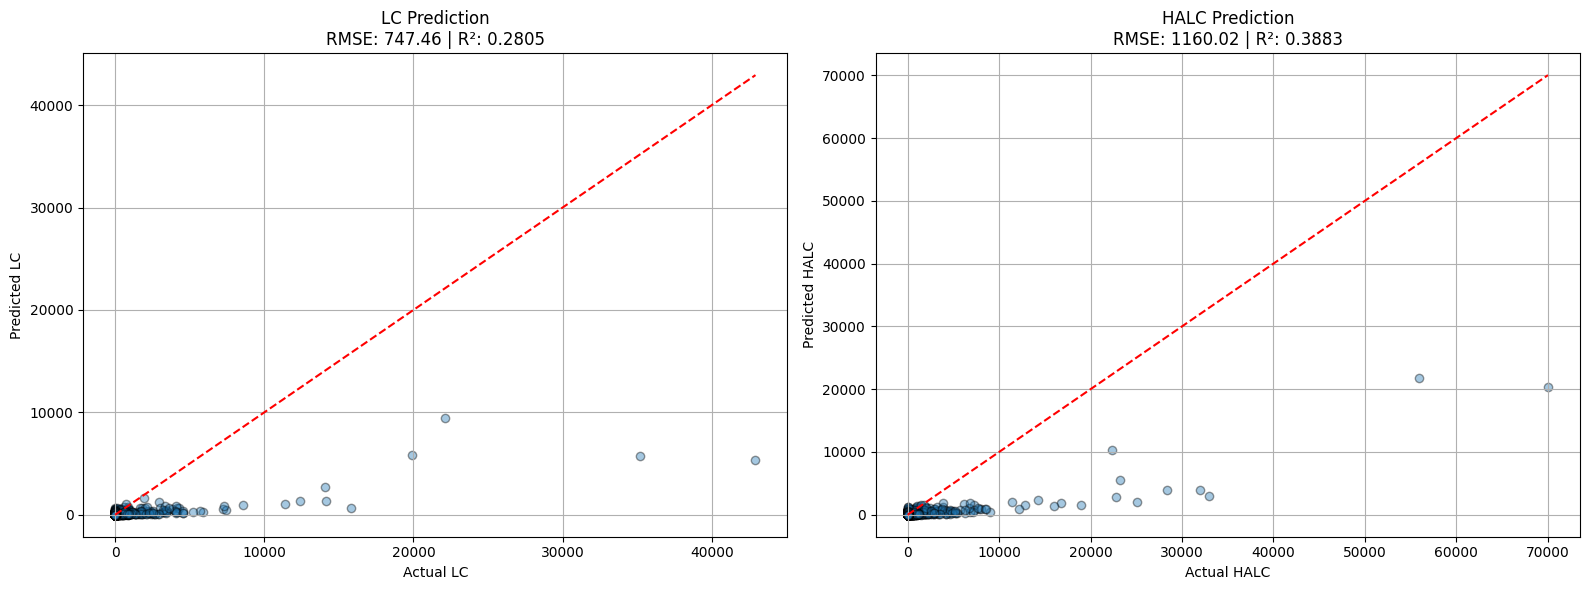


===== Final Model Summary =====
[LC]   RMSE: 747.46 | MSE: 558691.74 | MAE: 102.74 | R²: 0.2805
[HALC] RMSE: 1160.02 | MSE: 1345650.12 | MAE: 180.63 | R²: 0.3883

Best Hyperparameters:
LC: {'n_estimators': 303, 'learning_rate': 0.038297261911040485, 'max_depth': 5, 'min_child_weight': 3.6167872523900155, 'subsample': 0.9594164961913116, 'colsample_bytree': 0.7046475828344798, 'reg_alpha': 2.1358742581043524, 'reg_lambda': 2.7721801516074165, 'tweedie_variance_power': 1.3599368177523976}
HALC: {'n_estimators': 416, 'learning_rate': 0.011830490044134173, 'max_depth': 6, 'min_child_weight': 8.486036157425433, 'subsample': 0.8896653806024866, 'colsample_bytree': 0.7714209176797772, 'reg_alpha': 0.0824631206856754, 'reg_lambda': 4.033806547628079, 'tweedie_variance_power': 1.2150410506177691}


In [ ]:
# === Imports ===
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Base Data ===
X_encoded = train.drop(columns=['LC', 'HALC', 'CS', 'LC_log', 'HALC_log'], errors='ignore')
y_lc = train['LC']
y_halc = train['HALC']

# === Select Top Features ===
n_top_features = 20
X_selected_lc = X_encoded[top_features_lc.head(n_top_features).index.tolist()]
X_selected_halc = X_encoded[top_features_halc.head(n_top_features).index.tolist()]

# === OPTUNA: LC Tuning ===
def objective_lc(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1.1, 1.9),
    }
    y_bins = pd.qcut(y_lc, q=4, labels=False, duplicates='drop')
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    for train_idx, val_idx in skf.split(X_selected_lc, y_bins):
        X_tr, X_val = X_selected_lc.iloc[train_idx], X_selected_lc.iloc[val_idx]
        y_tr, y_val = y_lc.iloc[train_idx], y_lc.iloc[val_idx]
        model = xgb.XGBRegressor(objective='reg:tweedie', random_state=42, **params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))
    return np.mean(rmse_scores)

print("Tuning XGBoost for LC...")
study_lc = optuna.create_study(direction='minimize')
study_lc.optimize(objective_lc, n_trials=20, timeout=600)

# === OPTUNA: HALC Tuning ===
def objective_halc(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1.1, 1.9),
    }
    y_bins = pd.qcut(y_halc, q=4, labels=False, duplicates='drop')
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    for train_idx, val_idx in skf.split(X_selected_halc, y_bins):
        X_tr, X_val = X_selected_halc.iloc[train_idx], X_selected_halc.iloc[val_idx]
        y_tr, y_val = y_halc.iloc[train_idx], y_halc.iloc[val_idx]
        model = xgb.XGBRegressor(objective='reg:tweedie', random_state=42, **params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))
    return np.mean(rmse_scores)

print("\nTuning XGBoost for HALC...")
study_halc = optuna.create_study(direction='minimize')
study_halc.optimize(objective_halc, n_trials=20, timeout=600)

# === Final Training ===
final_lc_model = xgb.XGBRegressor(objective='reg:tweedie', random_state=42, **study_lc.best_params)
final_halc_model = xgb.XGBRegressor(objective='reg:tweedie', random_state=42, **study_halc.best_params)

final_lc_model.fit(X_selected_lc, y_lc)
final_halc_model.fit(X_selected_halc, y_halc)

# === Validation Split & Prediction ===
X_train_lc, X_val_lc, y_train_lc, y_val_lc = train_test_split(X_selected_lc, y_lc, test_size=0.2, random_state=42)
X_train_halc, X_val_halc, y_train_halc, y_val_halc = train_test_split(X_selected_halc, y_halc, test_size=0.2, random_state=42)

lc_preds_val = final_lc_model.predict(X_val_lc)
halc_preds_val = final_halc_model.predict(X_val_halc)

# === Metrics ===
lc_rmse = np.sqrt(mean_squared_error(y_val_lc, lc_preds_val))
lc_mse = mean_squared_error(y_val_lc, lc_preds_val)
lc_mae = mean_absolute_error(y_val_lc, lc_preds_val)
lc_r2 = r2_score(y_val_lc, lc_preds_val)

halc_rmse = np.sqrt(mean_squared_error(y_val_halc, halc_preds_val))
halc_mse = mean_squared_error(y_val_halc, halc_preds_val)
halc_mae = mean_absolute_error(y_val_halc, halc_preds_val)
halc_r2 = r2_score(y_val_halc, halc_preds_val)

# === Plot Predictions ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(y_val_lc, lc_preds_val, alpha=0.4, edgecolor='k')
ax1.plot([y_val_lc.min(), y_val_lc.max()], [y_val_lc.min(), y_val_lc.max()], 'r--')
ax1.set_xlabel('Actual LC')
ax1.set_ylabel('Predicted LC')
ax1.set_title(f'LC Prediction\nRMSE: {lc_rmse:.2f} | R²: {lc_r2:.4f}')
ax1.grid(True)

ax2.scatter(y_val_halc, halc_preds_val, alpha=0.4, edgecolor='k')
ax2.plot([y_val_halc.min(), y_val_halc.max()], [y_val_halc.min(), y_val_halc.max()], 'r--')
ax2.set_xlabel('Actual HALC')
ax2.set_ylabel('Predicted HALC')
ax2.set_title(f'HALC Prediction\nRMSE: {halc_rmse:.2f} | R²: {halc_r2:.4f}')
ax2.grid(True)

plt.tight_layout()
plt.show()

# === Final Print Summary ===
print("\n===== Final Model Summary =====")
print(f"[LC]   RMSE: {lc_rmse:.2f} | MSE: {lc_mse:.2f} | MAE: {lc_mae:.2f} | R²: {lc_r2:.4f}")
print(f"[HALC] RMSE: {halc_rmse:.2f} | MSE: {halc_mse:.2f} | MAE: {halc_mae:.2f} | R²: {halc_r2:.4f}")
print("\nBest Hyperparameters:")
print("LC:", study_lc.best_params)
print("HALC:", study_halc.best_params)


In [ ]:
# === Step 1: Imports ===
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Step 2: Prepare Training Data ===
X_encoded = train.drop(columns=['LC', 'HALC', 'CS', 'LC_log', 'HALC_log'], errors='ignore')
y_lc = train['LC']
y_halc = train['HALC']

n_top_features = 20
X_selected_lc = X_encoded[top_features_lc.head(n_top_features).index.tolist()]
X_selected_halc = X_encoded[top_features_halc.head(n_top_features).index.tolist()]

# === Step 3: Final Model Training ===
final_lc_model = xgb.XGBRegressor(objective='reg:tweedie', random_state=42, **study_lc.best_params)
final_halc_model = xgb.XGBRegressor(objective='reg:tweedie', random_state=42, **study_halc.best_params)

final_lc_model.fit(X_selected_lc, y_lc)
final_halc_model.fit(X_selected_halc, y_halc)

# === Step 4: Prepare Test Set ===
X_test = test.drop(columns=['LC', 'HALC', 'CS', 'LC_log', 'HALC_log'], errors='ignore')
X_test_lc = X_test[top_features_lc.head(n_top_features).index.tolist()]
X_test_halc = X_test[top_features_halc.head(n_top_features).index.tolist()]

# === Step 5: Predict on Test Set ===
lc_preds_test = final_lc_model.predict(X_test_lc)
halc_preds_test = final_halc_model.predict(X_test_halc)

# === Step 6: Create Output DataFrame ===
submission_df = pd.DataFrame({
    'LC': lc_preds_test,
    'HALC': halc_preds_test
})

# === Step 7: Preview Output ===
print(submission_df.head())

# === Step 8: Export if needed ===
submission_df.to_csv('/content/drive/MyDrive/DSO 530 Group Project/lc_halc_predictions.csv', index=False)


          LC        HALC
0  27.329298   34.446423
1  25.509663   43.075249
2  50.463875  118.291100
3  44.596489   44.894707
4   1.727081    5.247321


# **LightGBM Modeling**

### **LightGBM Modeling Overview**

LightGBM was applied to predict Loss Cost (LC) and Historically Adjusted Loss Cost (HALC), leveraging methods tailored to the zero-inflated, highly skewed nature of insurance claims data.

#### **Modeling Pipeline**

- **Baseline Tweedie Models**  
  Initial LightGBM regressors were trained using the Tweedie objective with default parameters. Evaluation was conducted using RMSE, MAE, MSE, and R², along with actual vs. predicted scatter plots. These models established a reference performance level.

- **SHAP-Based Feature Selection**  
  SHAP values and stratified cross-validated permutation importances were used to identify the most predictive features. RMSE was plotted against the number of top SHAP-ranked features to determine optimal feature subset sizes.

- **Tuned LightGBM Models**  
  Hyperparameters including learning rate, number of leaves, max depth, and Tweedie variance power were optimized through iterative search. Models retrained on selected top features achieved slightly improved accuracy and generalization.

- **Extreme Value Modeling**  
  A two-stage pipeline was constructed to model large loss amounts. A binary frequency classifier first identified claimants. Conditional on a claim, severity was modeled using LightGBM regressors. For high quantile loss cases, a Generalized Pareto Distribution (GPD) was fit to the residual tail.

- **Quantile Regression**  
  Quantile LightGBM models were trained on non-zero claims to estimate different percentiles (e.g., 50th, 90th). These were blended using frequency tiers, enabling probabilistic upper-bound estimation while preserving robustness to outliers.

- **Simplified Quantile Ensemble**  
  A lightweight ensemble was constructed using a binary classifier and two quantile regressors (50th and 90th percentiles). This configuration reduced feature dimensionality and computational cost while maintaining interpretability and competitive performance.

#### **Performance Summary**

**Baseline LightGBM (Tweedie):**  
- LC: RMSE = 878.05 | MAE = 112.82 | R² = 0.0071  
- HALC: RMSE = 1475.62 | MAE = 194.44 | R² = 0.0102  

**Tuned LightGBM with SHAP Features:**  
- LC: RMSE = 877.77 | MAE = 111.16 | R² = 0.0077  
- HALC: RMSE = 1478.11 | MAE = 191.92 | R² = 0.0068  

**Final SHAP-Simplified Models:**  
- LC: RMSE = 877.81 | MAE = 111.49 | R² = 0.0077  
- HALC: RMSE = 1475.90 | MAE = 191.59 | R² = 0.0098  

**Extreme Value Modeling:**  
- LC: RMSE = 558.96 | MAE = 251.68 | R² = -0.1927  
- HALC: RMSE = 2897.18 | MAE = 451.33 | R² = -0.0159  

**Quantile Regression Models:**  
- LC: RMSE = 686.69 | MAE = 220.76 | R² = -0.1278  
- HALC: RMSE = 1194.45 | MAE = 399.25 | R² = -0.2301  

**Simplified Quantile Ensemble:**  
- LC: RMSE = 646.49 | MAE = 80.30 | R² = 0.0004  
- HALC: RMSE = 1074.22 | MAE = 135.58 | R² = 0.0051  

#### Feature Insights

Top predictive features included:  
- `net_premium`, `age_at_license`, `power_weight_ratio`, `premium_to_value_ratio`,  
- `vehicle_weight_kg`, `vehicle_market_value`, `vehicle_cylinder_capacity`,  
- `policy_duration`, `customer_loyalty_score`, `driving_experience`, and `years_with_company`.

SHAP summary plots confirmed alignment with known risk factors, such as longer policy duration, high premium levels, and vehicle performance characteristics contributing to elevated loss exposure.



## **LightGBM Tweedie Baseline**

In [ ]:
!pip install lightgbm

Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 880.137
[20]	valid_0's rmse: 879.581
[30]	valid_0's rmse: 878.949
[40]	valid_0's rmse: 878.454
[50]	valid_0's rmse: 878.247
[60]	valid_0's rmse: 878.367
[70]	valid_0's rmse: 878.295
[80]	valid_0's rmse: 878.154
[90]	valid_0's rmse: 878.246
[100]	valid_0's rmse: 878.077
[110]	valid_0's rmse: 878.142
[120]	valid_0's rmse: 878.296
Early stopping, best iteration is:
[77]	valid_0's rmse: 878.055
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 1480.08
[20]	valid_0's rmse: 1478.16
[30]	valid_0's rmse: 1477.13
[40]	valid_0's rmse: 1476.18
[50]	valid_0's rmse: 1475.87
[60]	valid_0's rmse: 1475.94
[70]	valid_0's rmse: 1475.73
[80]	valid_0's rmse: 1475.62
[90]	valid_0's rmse: 1476.11
[100]	valid_0's rmse: 1476.27
[110]	valid_0's rmse: 1475.94
[120]	valid_0's rmse: 1475.78
[130]	valid_0's rmse: 1475.78
Early stopping, best iteration is:
[80]	valid_0's rmse: 1475.62


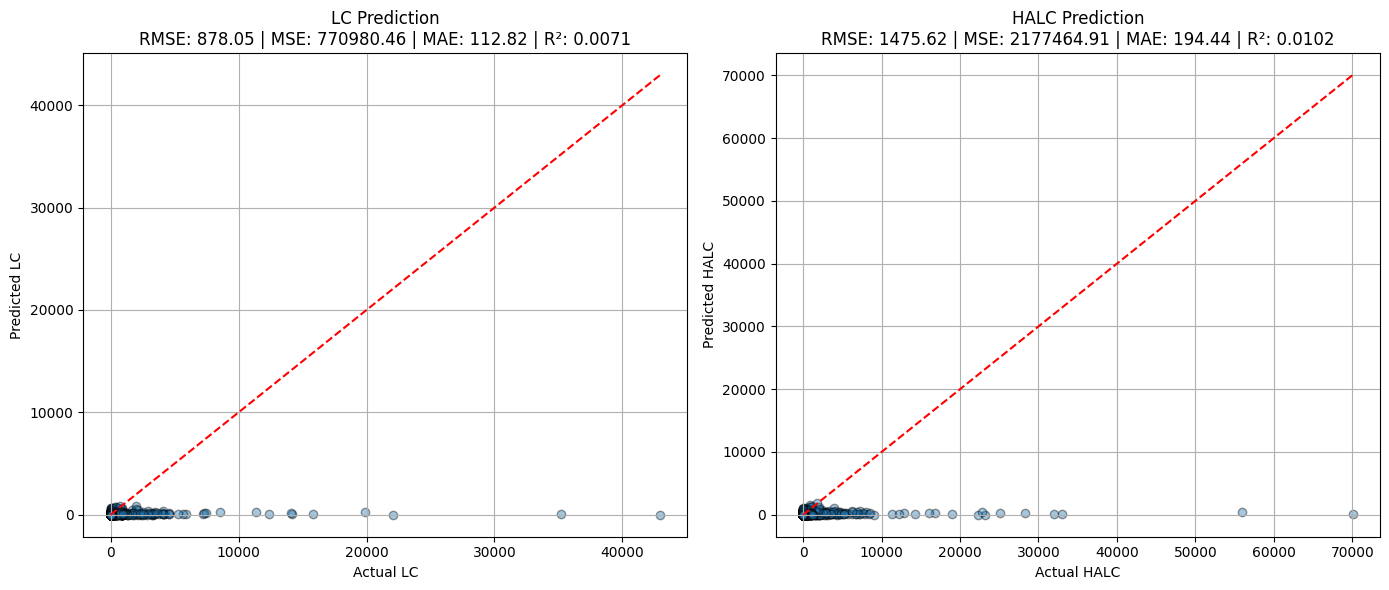


===== Baseline LightGBM Evaluation =====
[LC]   RMSE: 878.05 | MSE: 770980.46 | MAE: 112.82 | R²: 0.0071
[HALC] RMSE: 1475.62 | MSE: 2177464.91 | MAE: 194.44 | R²: 0.0102


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Step 1: Prepare Data ===
train = train_data.copy()
X = train.drop(columns=['LC', 'HALC', 'CS'], errors='ignore')
y_lc = train['LC']
y_halc = train['HALC']

X_train_lc, X_val_lc, y_train_lc, y_val_lc = train_test_split(X, y_lc, test_size=0.2, random_state=42)
X_train_halc, X_val_halc, y_train_halc, y_val_halc = train_test_split(X, y_halc, test_size=0.2, random_state=42)

# === Step 2: Define Baseline Parameters ===
baseline_params = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.3,
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

# === Step 3: Train LC Model ===
train_lc = lgb.Dataset(X_train_lc, label=y_train_lc)
val_lc = lgb.Dataset(X_val_lc, label=y_val_lc, reference=train_lc)

model_lc = lgb.train(
    baseline_params,
    train_lc,
    num_boost_round=500,
    valid_sets=[val_lc],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(10)]
)

# === Step 4: Train HALC Model ===
train_halc = lgb.Dataset(X_train_halc, label=y_train_halc)
val_halc = lgb.Dataset(X_val_halc, label=y_val_halc, reference=train_halc)

model_halc = lgb.train(
    baseline_params,
    train_halc,
    num_boost_round=500,
    valid_sets=[val_halc],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(10)]
)

# === Step 5: Predict and Evaluate ===
preds_lc = model_lc.predict(X_val_lc)
preds_halc = model_halc.predict(X_val_halc)

# Metrics for LC
mse_lc = mean_squared_error(y_val_lc, preds_lc)
rmse_lc = np.sqrt(mse_lc)
mae_lc = mean_absolute_error(y_val_lc, preds_lc)
r2_lc = r2_score(y_val_lc, preds_lc)

# Metrics for HALC
mse_halc = mean_squared_error(y_val_halc, preds_halc)
rmse_halc = np.sqrt(mse_halc)
mae_halc = mean_absolute_error(y_val_halc, preds_halc)
r2_halc = r2_score(y_val_halc, preds_halc)

# === Step 6: Plot ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(y_val_lc, preds_lc, alpha=0.4, edgecolor='k')
ax1.plot([y_val_lc.min(), y_val_lc.max()], [y_val_lc.min(), y_val_lc.max()], 'r--')
ax1.set_xlabel("Actual LC")
ax1.set_ylabel("Predicted LC")
ax1.set_title(f"LC Prediction\nRMSE: {rmse_lc:.2f} | MSE: {mse_lc:.2f} | MAE: {mae_lc:.2f} | R²: {r2_lc:.4f}")
ax1.grid(True)

ax2.scatter(y_val_halc, preds_halc, alpha=0.4, edgecolor='k')
ax2.plot([y_val_halc.min(), y_val_halc.max()], [y_val_halc.min(), y_val_halc.max()], 'r--')
ax2.set_xlabel("Actual HALC")
ax2.set_ylabel("Predicted HALC")
ax2.set_title(f"HALC Prediction\nRMSE: {rmse_halc:.2f} | MSE: {mse_halc:.2f} | MAE: {mae_halc:.2f} | R²: {r2_halc:.4f}")
ax2.grid(True)

plt.tight_layout()
plt.show()

# === Step 7: Print Metrics ===
print("\n===== Baseline LightGBM Evaluation =====")
print(f"[LC]   RMSE: {rmse_lc:.2f} | MSE: {mse_lc:.2f} | MAE: {mae_lc:.2f} | R²: {r2_lc:.4f}")
print(f"[HALC] RMSE: {rmse_halc:.2f} | MSE: {mse_halc:.2f} | MAE: {mae_halc:.2f} | R²: {r2_halc:.4f}")


## **Tuned LightGBM Tweedie Model**

**Initial Tuning**

Calculating top features using stratified CV...

Top 20 Features for LC:
net_premium                        268.666667
age_at_license                     261.000000
power_weight_ratio                 225.000000
premium_to_value_ratio             205.666667
vehicle_weight_kg                  199.333333
vehicle_market_value               190.000000
vehicle_cylinder_capacity          175.666667
policy_duration                    173.666667
customer_loyalty_score             162.666667
vehicle_age                        150.666667
driver_age_at_policy_start         149.333333
driving_experience                 143.333333
years_with_company                 108.666667
vehicle_power_hp                    94.000000
cancelled_policies_current_year     60.666667
total_policies                      56.666667
max_policies_held                   54.333333
payment_method                      41.666667
num_vehicle_doors                   35.000000
contract_channel                    28.333333
Name: m

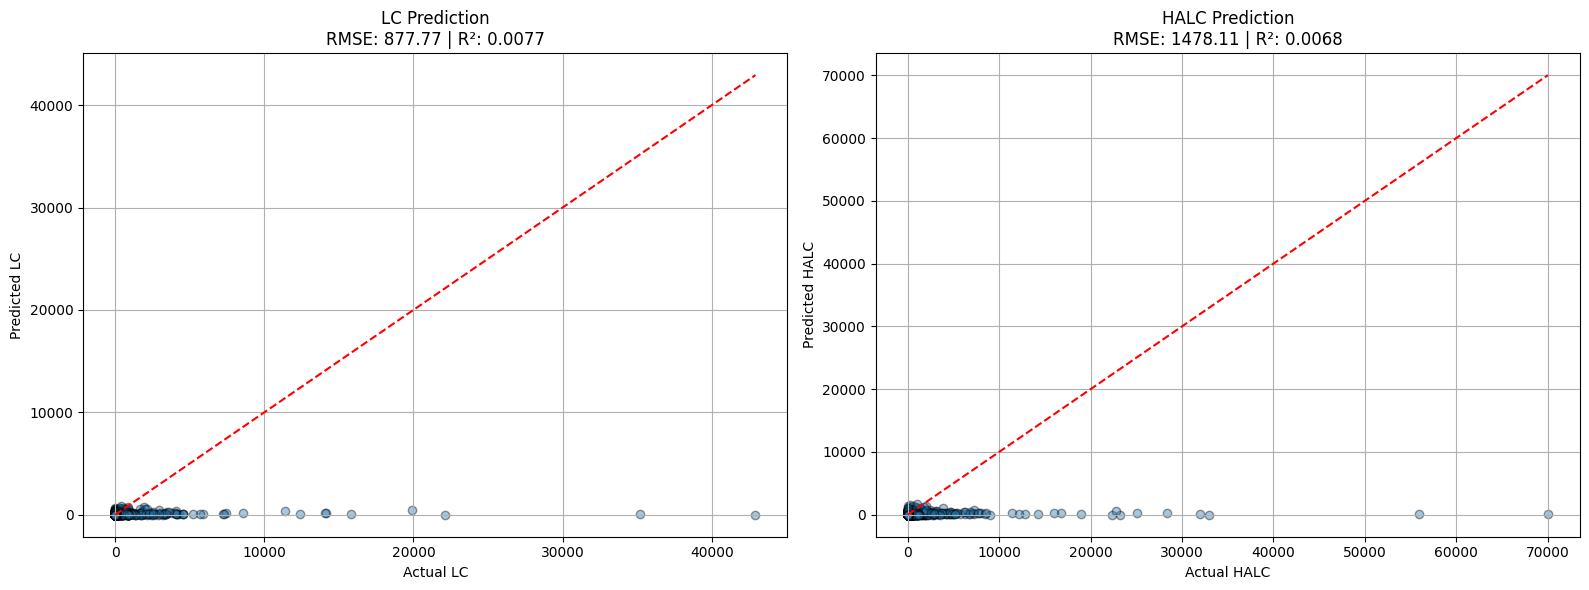

In [ ]:
# === LightGBM Tweedie Full Pipeline with SHAP and Optuna ===

import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Step 1: Prepare Data ===
train = train_data.copy()
drop_cols = ['LC', 'HALC', 'CS', 'LC_log', 'HALC_log']
X = train.drop(columns=drop_cols, errors='ignore')
y_lc = train['LC']
y_halc = train['HALC']

# === Step 2: Stratified CV-Based Feature Selection ===
def get_top_features(X_data, y_target, n_splits=3, n_estimators=100):
    y_bins = pd.qcut(y_target, q=4, labels=False, duplicates='drop')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    feature_scores = pd.DataFrame(index=X_data.columns)

    for fold, (train_idx, _) in enumerate(skf.split(X_data, y_bins)):
        model = lgb.LGBMRegressor(objective='tweedie', n_estimators=n_estimators, random_state=42)
        model.fit(X_data.iloc[train_idx], y_target.iloc[train_idx])
        fold_importance = pd.Series(model.feature_importances_, index=X_data.columns, name=f'fold_{fold+1}')
        feature_scores = pd.concat([feature_scores, fold_importance], axis=1)

    feature_scores['mean_importance'] = feature_scores.mean(axis=1)
    return feature_scores['mean_importance'].sort_values(ascending=False)

print("Calculating top features using stratified CV...")
top_features_lc = get_top_features(X, y_lc)
top_features_halc = get_top_features(X, y_halc)

print("\nTop 20 Features for LC:")
print(top_features_lc.head(20))
print("\nTop 20 Features for HALC:")
print(top_features_halc.head(20))

# === Step 3: Use SHAP Top 20 Features ===
top_20_lc_names = top_features_lc.head(20).index.tolist()
top_20_halc_names = top_features_halc.head(15).index.tolist()
X_top_lc = X[top_20_lc_names]
X_top_halc = X[top_20_halc_names]

# === Step 4: Train-Test Split ===
X_train_lc, X_val_lc, y_train_lc, y_val_lc = train_test_split(X_top_lc, y_lc, test_size=0.2, random_state=42)
X_train_halc, X_val_halc, y_train_halc, y_val_halc = train_test_split(X_top_halc, y_halc, test_size=0.2, random_state=42)

# === Step 5: LightGBM Baseline Training ===
baseline_params = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.3,
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

final_lgb_lc = lgb.LGBMRegressor(**baseline_params)
final_lgb_halc = lgb.LGBMRegressor(**baseline_params)
final_lgb_lc.fit(X_train_lc, y_train_lc)
final_lgb_halc.fit(X_train_halc, y_train_halc)

# === Step 6: Evaluate ===
preds_lc = final_lgb_lc.predict(X_val_lc)
preds_halc = final_lgb_halc.predict(X_val_halc)

metrics = lambda y, p: (mean_squared_error(y, p), np.sqrt(mean_squared_error(y, p)), mean_absolute_error(y, p), r2_score(y, p))

mse_lc, rmse_lc, mae_lc, r2_lc = metrics(y_val_lc, preds_lc)
mse_halc, rmse_halc, mae_halc, r2_halc = metrics(y_val_halc, preds_halc)

print("\n===== Final LightGBM Model Performance =====")
print(f"[LC]   RMSE: {rmse_lc:.2f} | MSE: {mse_lc:.2f} | MAE: {mae_lc:.2f} | R²: {r2_lc:.4f}")
print(f"[HALC] RMSE: {rmse_halc:.2f} | MSE: {mse_halc:.2f} | MAE: {mae_halc:.2f} | R²: {r2_halc:.4f}")

# === Step 7: Actual vs Predicted Plots ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(y_val_lc, preds_lc, alpha=0.4, edgecolor='k')
ax1.plot([y_val_lc.min(), y_val_lc.max()], [y_val_lc.min(), y_val_lc.max()], 'r--')
ax1.set_title(f'LC Prediction\nRMSE: {rmse_lc:.2f} | R²: {r2_lc:.4f}')
ax1.set_xlabel('Actual LC')
ax1.set_ylabel('Predicted LC')
ax1.grid(True)

ax2.scatter(y_val_halc, preds_halc, alpha=0.4, edgecolor='k')
ax2.plot([y_val_halc.min(), y_val_halc.max()], [y_val_halc.min(), y_val_halc.max()], 'r--')
ax2.set_title(f'HALC Prediction\nRMSE: {rmse_halc:.2f} | R²: {r2_halc:.4f}')
ax2.set_xlabel('Actual HALC')
ax2.set_ylabel('Predicted HALC')
ax2.grid(True)

plt.tight_layout()
plt.show()


Calculating top features using stratified CV...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2498
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 45
[LightGBM] [Info] Start training from score 4.256509
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2500
[LightGBM] [Info] Number of data points in the train set: 29961, number of used features: 45
[LightGBM] [Info] Start training from score 4.185102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010822 seconds.
You can set `force_row_wise=true` to

PermutationExplainer explainer: 7492it [21:06,  5.89it/s]
PermutationExplainer explainer: 7492it [20:48,  5.95it/s]



SHAP Summary Plot — LC


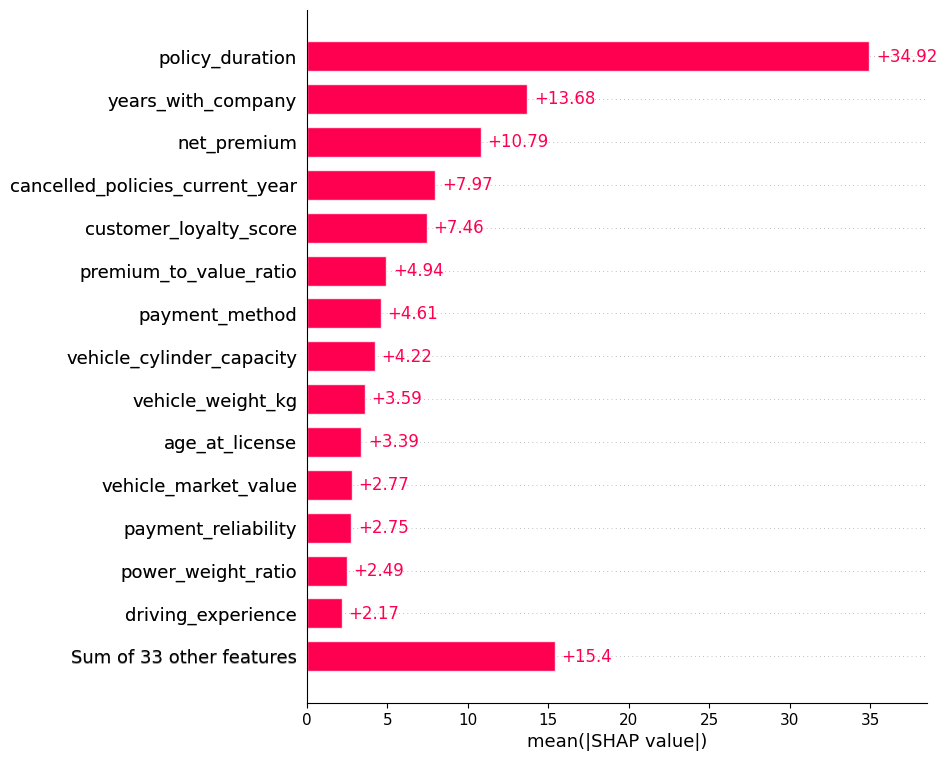


SHAP Summary Plot — HALC


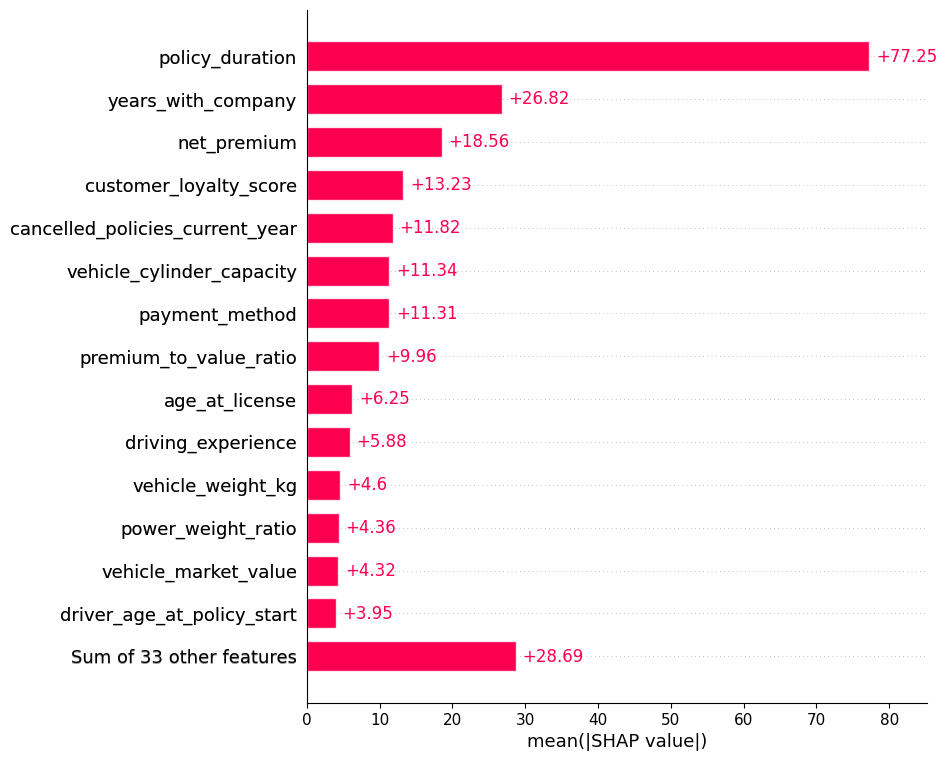


Tuning Number of Features (LC):


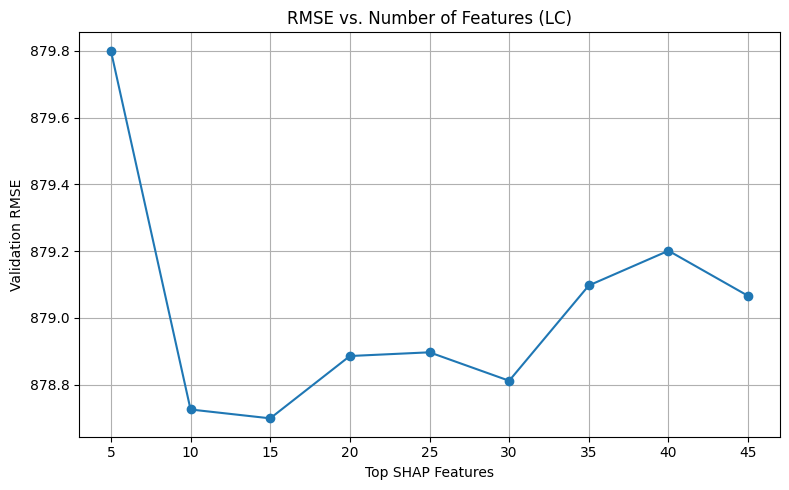


Tuning Number of Features (HALC):


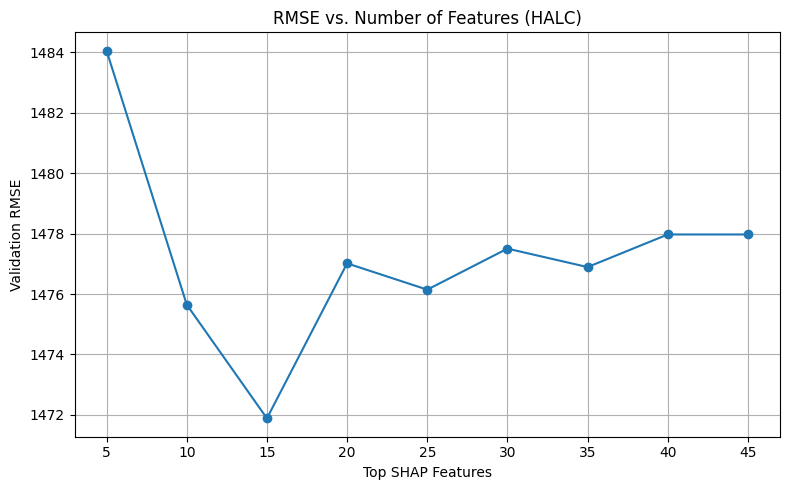


===== Final Model Performance =====
[LC]   RMSE: 877.81 | MSE: 770542.88 | MAE: 111.49 | R²: 0.0077
[HALC] RMSE: 1475.90 | MSE: 2178273.46 | MAE: 191.59 | R²: 0.0098


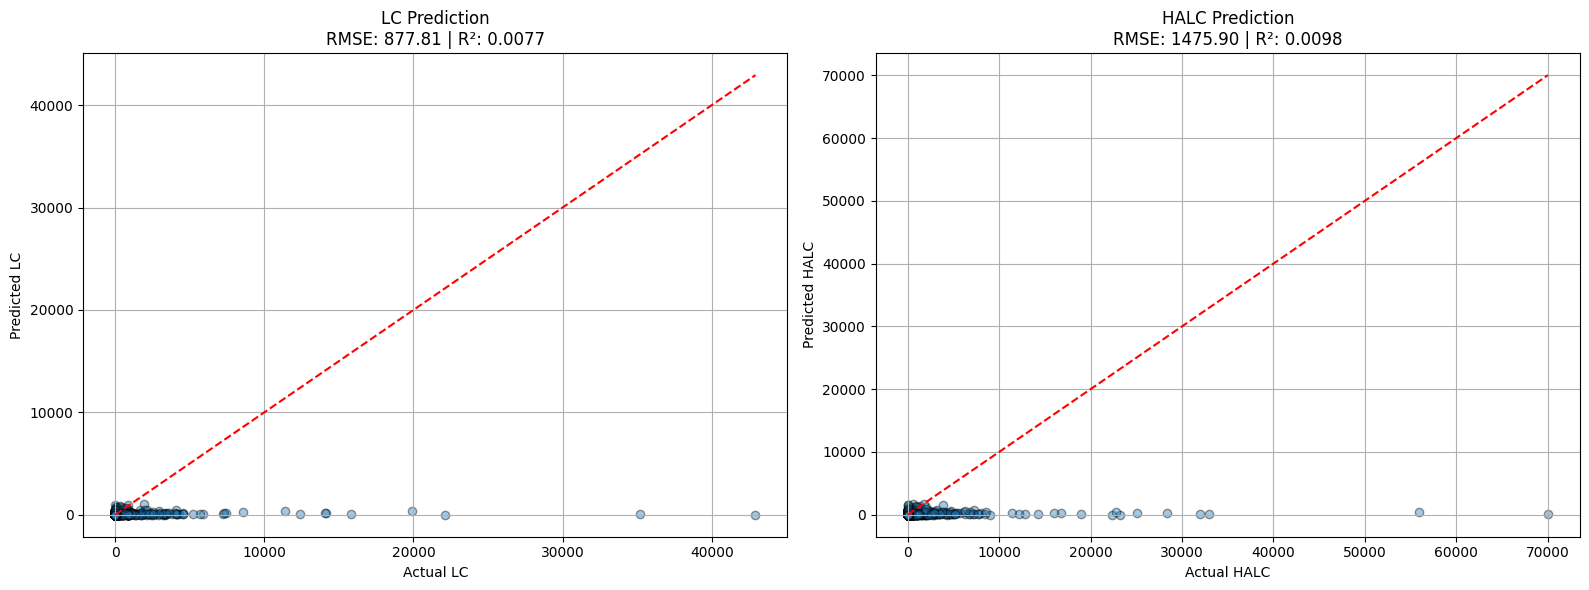

In [ ]:
# === LightGBM Tweedie Full Pipeline with SHAP and Optuna ===

import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Step 1: Prepare Data ===
train = train_data.copy()
drop_cols = ['LC', 'HALC', 'CS', 'LC_log', 'HALC_log']
X = train.drop(columns=drop_cols, errors='ignore')
y_lc = train['LC']
y_halc = train['HALC']

# === Step 2: Stratified CV-Based Feature Selection ===
def get_top_features(X_data, y_target, n_splits=5, n_estimators=300):
    y_bins = pd.qcut(y_target, q=4, labels=False, duplicates='drop')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    feature_scores = pd.DataFrame(index=X_data.columns)

    for fold, (train_idx, _) in enumerate(skf.split(X_data, y_bins)):
        model = lgb.LGBMRegressor(objective='tweedie', n_estimators=n_estimators, random_state=42)
        model.fit(X_data.iloc[train_idx], y_target.iloc[train_idx])
        fold_importance = pd.Series(model.feature_importances_, index=X_data.columns, name=f'fold_{fold+1}')
        feature_scores = pd.concat([feature_scores, fold_importance], axis=1)

    feature_scores['mean_importance'] = feature_scores.mean(axis=1)
    return feature_scores['mean_importance'].sort_values(ascending=False)

print("Calculating top features using stratified CV...")
top_features_lc = get_top_features(X, y_lc)
top_features_halc = get_top_features(X, y_halc)

print("\nTop 20 Features for LC:")
print(top_features_lc.head(20))
print("\nTop 20 Features for HALC:")
print(top_features_halc.head(20))

# === Step 3: SHAP Importance and RMSE Curve ===
def rmse_vs_feature_count(X, y, shap_values, label):
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    shap_importance = pd.Series(mean_shap, index=X.columns).sort_values(ascending=False)
    feature_counts = list(range(5, min(51, len(shap_importance) + 1), 5))
    rmse_scores = []

    for k in feature_counts:
        top_k_features = shap_importance.head(k).index.tolist()
        X_k = X[top_k_features]
        X_train_k, X_val_k, y_train_k, y_val_k = train_test_split(X_k, y, test_size=0.2, random_state=42)
        model = lgb.LGBMRegressor(objective='tweedie', tweedie_variance_power=1.3, random_state=42)
        model.fit(X_train_k, y_train_k)
        preds = model.predict(X_val_k)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val_k, preds)))

    plt.figure(figsize=(8, 5))
    plt.plot(feature_counts, rmse_scores, marker='o')
    plt.title(f'RMSE vs. Number of Features ({label})')
    plt.xlabel('Top SHAP Features')
    plt.ylabel('Validation RMSE')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({'n_features': feature_counts, 'rmse': rmse_scores})

# === Step 4: Train-Test Split ===
X_train_lc, X_val_lc, y_train_lc, y_val_lc = train_test_split(X, y_lc, test_size=0.2, random_state=42)
X_train_halc, X_val_halc, y_train_halc, y_val_halc = train_test_split(X, y_halc, test_size=0.2, random_state=42)

# === Step 5: LightGBM Baseline Training ===
baseline_params = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.3,
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

train_lc = lgb.Dataset(X_train_lc, label=y_train_lc)
val_lc = lgb.Dataset(X_val_lc, label=y_val_lc, reference=train_lc)
model_lc = lgb.train(baseline_params, train_lc, num_boost_round=500, valid_sets=[val_lc], callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])

train_halc = lgb.Dataset(X_train_halc, label=y_train_halc)
val_halc = lgb.Dataset(X_val_halc, label=y_val_halc, reference=train_halc)
model_halc = lgb.train(baseline_params, train_halc, num_boost_round=500, valid_sets=[val_halc], callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])

# === Step 6: SHAP Values ===
explainer_lc = shap.Explainer(model_lc.predict, X_val_lc)
shap_values_lc = explainer_lc(X_val_lc)

explainer_halc = shap.Explainer(model_halc.predict, X_val_halc)
shap_values_halc = explainer_halc(X_val_halc)

print("\nSHAP Summary Plot — LC")
shap.plots.bar(shap_values_lc, max_display=15)

print("\nSHAP Summary Plot — HALC")
shap.plots.bar(shap_values_halc, max_display=15)

# === Step 7: RMSE Curve ===
print("\nTuning Number of Features (LC):")
rmse_lc_df = rmse_vs_feature_count(X, y_lc, shap_values_lc, 'LC')

print("\nTuning Number of Features (HALC):")
rmse_halc_df = rmse_vs_feature_count(X, y_halc, shap_values_halc, 'HALC')

# === Step 8: Final Model with SHAP Top 20 Features ===
top_20_lc = shap_values_lc.abs.mean(0).values.argsort()[-20:][::-1]
top_20_halc = shap_values_halc.abs.mean(0).values.argsort()[-20:][::-1]
X_top_lc = X.iloc[:, top_20_lc]
X_top_halc = X.iloc[:, top_20_halc]

X_train_lc, X_val_lc, y_train_lc, y_val_lc = train_test_split(X_top_lc, y_lc, test_size=0.2, random_state=42)
X_train_halc, X_val_halc, y_train_halc, y_val_halc = train_test_split(X_top_halc, y_halc, test_size=0.2, random_state=42)

final_lgb_lc = lgb.LGBMRegressor(**baseline_params)
final_lgb_halc = lgb.LGBMRegressor(**baseline_params)
final_lgb_lc.fit(X_train_lc, y_train_lc)
final_lgb_halc.fit(X_train_halc, y_train_halc)

# === Step 9: Evaluate ===
preds_lc = final_lgb_lc.predict(X_val_lc)
preds_halc = final_lgb_halc.predict(X_val_halc)

metrics = lambda y, p: (mean_squared_error(y, p), np.sqrt(mean_squared_error(y, p)), mean_absolute_error(y, p), r2_score(y, p))

mse_lc, rmse_lc, mae_lc, r2_lc = metrics(y_val_lc, preds_lc)
mse_halc, rmse_halc, mae_halc, r2_halc = metrics(y_val_halc, preds_halc)

print("\n===== Final Model Performance =====")
print(f"[LC]   RMSE: {rmse_lc:.2f} | MSE: {mse_lc:.2f} | MAE: {mae_lc:.2f} | R²: {r2_lc:.4f}")
print(f"[HALC] RMSE: {rmse_halc:.2f} | MSE: {mse_halc:.2f} | MAE: {mae_halc:.2f} | R²: {r2_halc:.4f}")

# === Step 10: Actual vs Predicted Plots ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(y_val_lc, preds_lc, alpha=0.4, edgecolor='k')
ax1.plot([y_val_lc.min(), y_val_lc.max()], [y_val_lc.min(), y_val_lc.max()], 'r--')
ax1.set_title(f'LC Prediction\nRMSE: {rmse_lc:.2f} | R²: {r2_lc:.4f}')
ax1.set_xlabel('Actual LC')
ax1.set_ylabel('Predicted LC')
ax1.grid(True)

ax2.scatter(y_val_halc, preds_halc, alpha=0.4, edgecolor='k')
ax2.plot([y_val_halc.min(), y_val_halc.max()], [y_val_halc.min(), y_val_halc.max()], 'r--')
ax2.set_title(f'HALC Prediction\nRMSE: {rmse_halc:.2f} | R²: {r2_halc:.4f}')
ax2.set_xlabel('Actual HALC')
ax2.set_ylabel('Predicted HALC')
ax2.grid(True)

plt.tight_layout()
plt.show()


## **LightGBM Extreme Value Insurance Modeling**

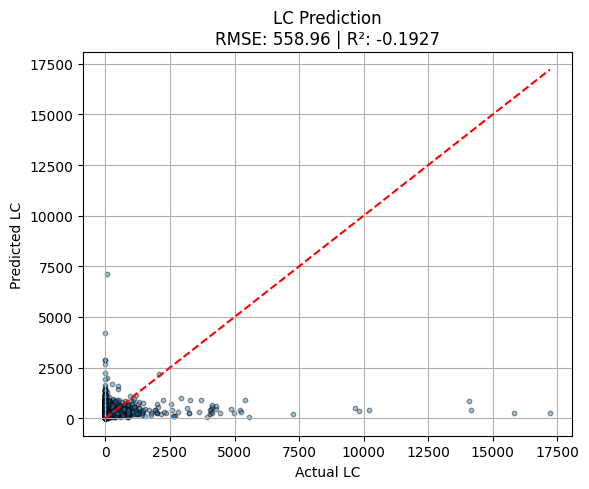

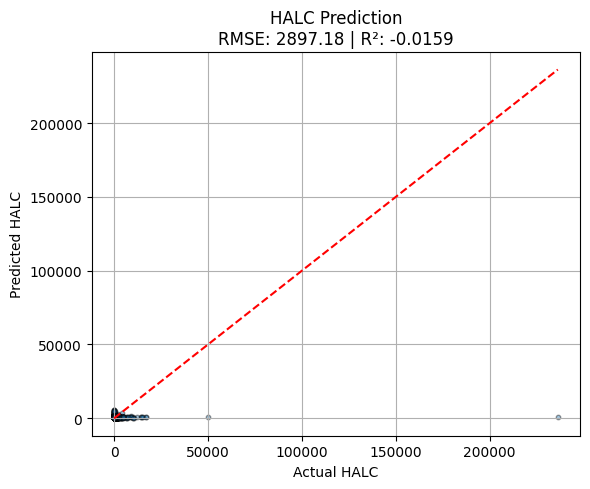


===== EVT Insurance Model Evaluation =====
[LC]   RMSE: 558.96 | MSE: 312434.31 | MAE: 251.68 | R²: -0.1927
[HALC] RMSE: 2897.18 | MSE: 8393673.65 | MAE: 451.33 | R²: -0.0159


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def extreme_value_insurance_model(train_data, target='LC', plot_diag=True):
    drop_cols = ['LC', 'HALC', 'CS', 'LC_log', 'HALC_log']
    X = train_data.drop(columns=drop_cols, errors='ignore')
    y = train_data[target]

    zeros_mask = y == 0
    non_zeros = y[~zeros_mask]
    quantiles = [0, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
    bin_values = [0] + [non_zeros.quantile(q) for q in quantiles[1:]]
    bins = pd.cut(y, bins=bin_values, labels=False, include_lowest=True)

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=bins)

    features = X.columns.tolist()
    y_binary_train = (y_train > 0).astype(int)
    freq_model = lgbm.LGBMClassifier(objective='binary', n_estimators=500, learning_rate=0.01,
                                     max_depth=5, subsample=0.8, colsample_bytree=0.8,
                                     random_state=42, verbose=-1, is_unbalance=True)
    freq_model.fit(X_train[features], y_binary_train)
    freq_probs = freq_model.predict_proba(X_val[features])[:, 1]

    non_zero_mask = y_train > 0
    X_train_nz = X_train.loc[non_zero_mask]
    y_train_nz = y_train.loc[non_zero_mask]

    small_cutoff = non_zeros.quantile(0.75)
    medium_cutoff = non_zeros.quantile(0.95)
    large_cutoff = non_zeros.quantile(0.99)

    def assign_tier(x):
        if x <= small_cutoff: return 0
        elif x <= medium_cutoff: return 1
        elif x <= large_cutoff: return 2
        else: return 3

    severity_tiers = y_train_nz.apply(assign_tier)

    tier_model = lgbm.LGBMClassifier(objective='multiclass', num_class=4, n_estimators=500,
                                     learning_rate=0.01, max_depth=4, subsample=0.8,
                                     colsample_bytree=0.8, random_state=42, verbose=-1)
    tier_model.fit(X_train_nz[features], severity_tiers)

    tier_preds = tier_model.predict_proba(X_val[features])

    small_model, medium_model, large_model, extreme_model = None, None, None, None
    gpd_params = None

    if (severity_tiers == 0).sum() >= 50:
        sm = severity_tiers == 0
        small_model = lgbm.LGBMRegressor(objective='gamma', n_estimators=300, learning_rate=0.03,
                                         max_depth=5, subsample=0.8, colsample_bytree=0.8,
                                         random_state=42, verbose=-1)
        small_model.fit(X_train_nz.loc[sm][features], y_train_nz.loc[sm])

    if (severity_tiers == 1).sum() >= 50:
        md = severity_tiers == 1
        medium_model = lgbm.LGBMRegressor(objective='gamma', n_estimators=300, learning_rate=0.03,
                                          max_depth=4, subsample=0.8, colsample_bytree=0.8,
                                          random_state=42, verbose=-1)
        medium_model.fit(X_train_nz.loc[md][features], y_train_nz.loc[md])

    if (severity_tiers == 2).sum() >= 30:
        lg = severity_tiers == 2
        large_model = lgbm.LGBMRegressor(objective='gamma', n_estimators=200, learning_rate=0.02,
                                         max_depth=3, num_leaves=15, subsample=0.8,
                                         colsample_bytree=0.8, random_state=42, verbose=-1)
        large_model.fit(X_train_nz.loc[lg][features], y_train_nz.loc[lg])

    if (severity_tiers == 3).sum() >= 20:
        ex = severity_tiers == 3
        X_extreme = X_train_nz.loc[ex]
        y_extreme = y_train_nz.loc[ex]
        exceedances = y_extreme - large_cutoff

        try:
            gpd_params = genpareto.fit(exceedances)
            extreme_model = lgbm.LGBMRegressor(objective='gamma', n_estimators=150, learning_rate=0.01,
                                               max_depth=2, num_leaves=7, subsample=0.7,
                                               colsample_bytree=0.7, random_state=42, verbose=-1)
            extreme_model.fit(X_extreme[features], exceedances / exceedances.mean())
            gpd_used = True
        except:
            extreme_model = None
            gpd_used = False

    small_preds = small_model.predict(X_val[features]) if small_model else np.ones(len(X_val)) * y_train_nz[severity_tiers == 0].mean()
    medium_preds = medium_model.predict(X_val[features]) if medium_model else np.ones(len(X_val)) * y_train_nz[severity_tiers == 1].mean()
    large_preds = large_model.predict(X_val[features]) if large_model else np.ones(len(X_val)) * y_train_nz[severity_tiers == 2].mean()

    if extreme_model:
        if gpd_params:
            scale_factors = extreme_model.predict(X_val[features])
            shape, loc, scale = gpd_params
            gpd_mean = scale / (1 - shape) if shape < 1 else exceedances.mean()
            extreme_preds = large_cutoff + (scale_factors * gpd_mean)
        else:
            extreme_preds = extreme_model.predict(X_val[features])
    else:
        extreme_preds = np.ones(len(X_val)) * y_train_nz[severity_tiers == 3].mean()

    final_preds = freq_probs * (
        tier_preds[:, 0] * small_preds +
        tier_preds[:, 1] * medium_preds +
        tier_preds[:, 2] * large_preds +
        tier_preds[:, 3] * extreme_preds
    )

    mse = mean_squared_error(y_val, final_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, final_preds)  # MAE added here
    r2 = r2_score(y_val, final_preds)

    if plot_diag:
        plt.figure(figsize=(6, 5))
        plt.scatter(y_val, final_preds, alpha=0.4, s=10, edgecolor='k')
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
        plt.xlabel(f"Actual {target}")
        plt.ylabel(f"Predicted {target}")
        plt.title(f"{target} Prediction\nRMSE: {rmse:.2f} | R²: {r2:.4f}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        'predictions': final_preds,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,  # MAE returned here
            'r2': r2
        }
    }

# === Run for LC and HALC ===
train = train_data.copy()
results_lc = extreme_value_insurance_model(train, target='LC')
results_halc = extreme_value_insurance_model(train, target='HALC')

print("\n===== EVT Insurance Model Evaluation =====")
print(f"[LC]   RMSE: {results_lc['metrics']['rmse']:.2f} | MSE: {results_lc['metrics']['mse']:.2f} | MAE: {results_lc['metrics']['mae']:.2f} | R²: {results_lc['metrics']['r2']:.4f}")
print(f"[HALC] RMSE: {results_halc['metrics']['rmse']:.2f} | MSE: {results_halc['metrics']['mse']:.2f} | MAE: {results_halc['metrics']['mae']:.2f} | R²: {results_halc['metrics']['r2']:.4f}")


## **LightGBM Quantile Regression Model**

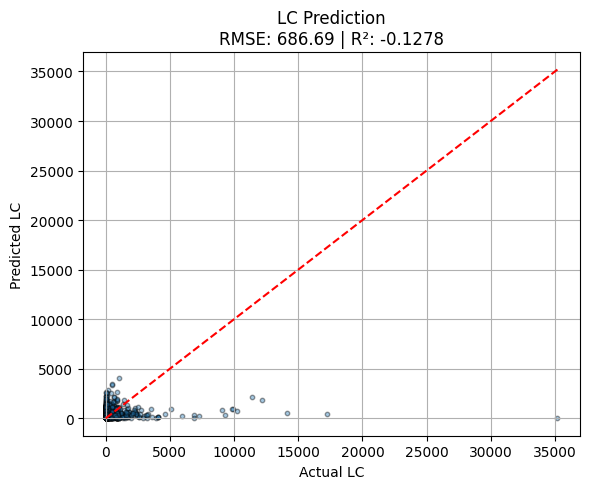

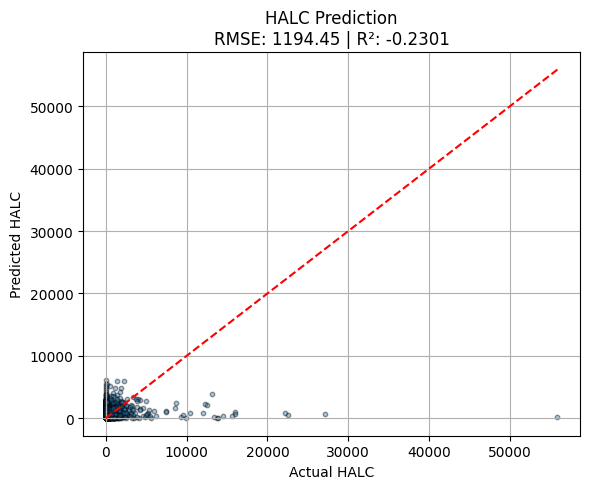


===== Quantile Insurance Model Evaluation =====
[LC]   RMSE: 686.69 | MSE: 471536.80 | MAE: 220.76 | R²: -0.1278
[HALC] RMSE: 1194.45 | MSE: 1426710.79 | MAE: 399.25 | R²: -0.2301


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def insurance_quantile_model(train_data, target='LC', plot_diag=True):
    drop_cols = ['LC', 'HALC', 'CS', 'LC_log', 'HALC_log']
    X = train_data.drop(columns=drop_cols, errors='ignore')
    y = train_data[target]

    strat_bins = (y > 0).astype(int)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=strat_bins, random_state=42)

    freq_model = lgbm.LGBMClassifier(
        objective='binary', n_estimators=500, learning_rate=0.01, max_depth=5,
        num_leaves=31, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.1, reg_lambda=0.1, random_state=42, verbosity=-1,
        is_unbalance=True
    )
    freq_model.fit(X_train, (y_train > 0).astype(int))
    freq_probs = freq_model.predict_proba(X_val)[:, 1]

    non_zero_mask = y_train > 0
    X_train_nz = X_train[non_zero_mask]
    y_train_nz = y_train[non_zero_mask]

    quantiles = [0.5, 0.75, 0.9, 0.95, 0.99]
    quantile_models = {}

    for q in quantiles:
        model = lgbm.LGBMRegressor(
            objective='quantile', alpha=q, n_estimators=300, learning_rate=0.02,
            max_depth=4, num_leaves=31, subsample=0.8, colsample_bytree=0.8,
            reg_alpha=0.1, reg_lambda=0.1, random_state=42, verbosity=-1
        )
        model.fit(X_train_nz, y_train_nz)
        quantile_models[q] = model

    quantile_preds = {q: model.predict(X_val) for q, model in quantile_models.items()}

    def get_tier(p):
        if p < 0.3: return 0
        elif p < 0.5: return 1
        elif p < 0.7: return 2
        elif p < 0.85: return 3
        elif p < 0.95: return 4
        else: return 5

    tiers = np.array([get_tier(p) for p in freq_probs])

    tier_to_quantile = {
        0: 0,
        1: 0.5,
        2: 0.75,
        3: 0.9,
        4: 0.95,
        5: 0.99
    }

    final_preds = np.zeros(len(X_val))
    for i, tier in enumerate(tiers):
        if tier == 0:
            final_preds[i] = 0
        else:
            q = tier_to_quantile[tier]
            final_preds[i] = freq_probs[i] * quantile_preds[q][i]

    mse = mean_squared_error(y_val, final_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, final_preds)  # <-- MAE added
    r2 = r2_score(y_val, final_preds)

    if plot_diag:
        plt.figure(figsize=(6, 5))
        plt.scatter(y_val, final_preds, alpha=0.4, s=10, edgecolor='k')
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
        plt.xlabel(f"Actual {target}")
        plt.ylabel(f"Predicted {target}")
        plt.title(f"{target} Prediction\nRMSE: {rmse:.2f} | R²: {r2:.4f}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        'predictions': final_preds,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,        # <-- MAE returned
            'r2': r2
        }
    }

# === Run for LC and HALC ===
train = train_data.copy()
results_lc = insurance_quantile_model(train, target='LC')
results_halc = insurance_quantile_model(train, target='HALC')

print("\n===== Quantile Insurance Model Evaluation =====")
print(f"[LC]   RMSE: {results_lc['metrics']['rmse']:.2f} | MSE: {results_lc['metrics']['mse']:.2f} | MAE: {results_lc['metrics']['mae']:.2f} | R²: {results_lc['metrics']['r2']:.4f}")
print(f"[HALC] RMSE: {results_halc['metrics']['rmse']:.2f} | MSE: {results_halc['metrics']['mse']:.2f} | MAE: {results_halc['metrics']['mae']:.2f} | R²: {results_halc['metrics']['r2']:.4f}")


## **LightGBM Simplified Quantile Blending Model**

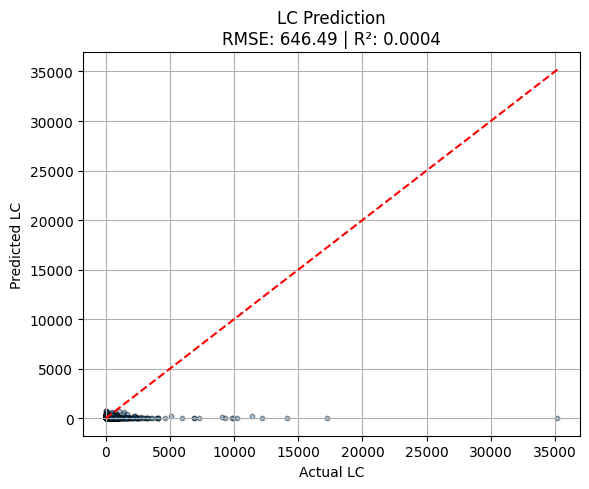

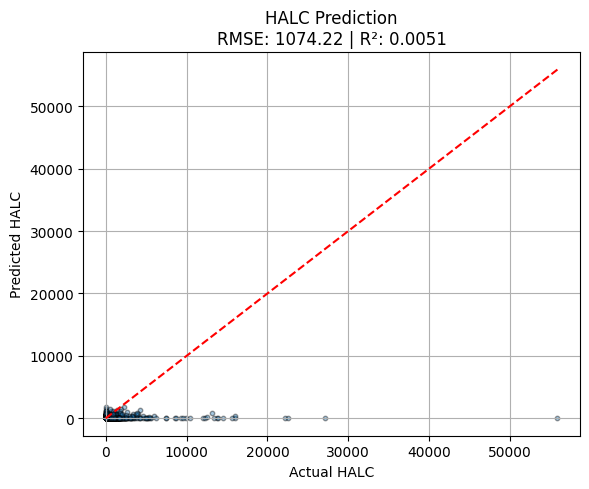


===== Simplified Insurance Model Evaluation =====
[LC]   RMSE: 646.49 | MSE: 417944.89 | MAE: 80.30 | R²: 0.0004
[HALC] RMSE: 1074.22 | MSE: 1153942.87 | MAE: 135.58 | R²: 0.0051


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


def simplified_insurance_model(train_data, target='LC', n_features=15):
    drop_cols = ['LC', 'HALC', 'CS', 'LC_log', 'HALC_log']
    X = train_data.drop(columns=drop_cols, errors='ignore')
    y = train_data[target]

    # Feature selection
    feature_model = lgbm.LGBMRegressor(random_state=42, verbose=-1)
    feature_model.fit(X, y)
    importances = pd.DataFrame({'feature': X.columns, 'importance': feature_model.feature_importances_})
    selected_features = importances.sort_values('importance', ascending=False).head(n_features)['feature'].tolist()

    # Train/validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=(y > 0).astype(int))

    # Frequency model
    freq_model = lgbm.LGBMClassifier(
        n_estimators=300, learning_rate=0.01, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1)
    freq_model.fit(X_train[selected_features], (y_train > 0).astype(int))
    freq_probs = freq_model.predict_proba(X_val[selected_features])[:, 1]

    # Quantile regressors on non-zero claims
    non_zero_mask = y_train > 0
    X_train_nz = X_train[non_zero_mask][selected_features]
    y_train_nz = y_train[non_zero_mask]

    q_model_50 = lgbm.LGBMRegressor(objective='quantile', alpha=0.5, n_estimators=300,
                                    learning_rate=0.01, max_depth=4, random_state=42, verbose=-1)
    q_model_90 = lgbm.LGBMRegressor(objective='quantile', alpha=0.9, n_estimators=300,
                                    learning_rate=0.01, max_depth=4, random_state=42, verbose=-1)
    q_model_50.fit(X_train_nz, y_train_nz)
    q_model_90.fit(X_train_nz, y_train_nz)

    # Predictions
    q50_preds = q_model_50.predict(X_val[selected_features])
    q90_preds = q_model_90.predict(X_val[selected_features])

    final_preds = np.zeros(len(X_val))
    for i in range(len(X_val)):
        if freq_probs[i] < 0.3:
            final_preds[i] = freq_probs[i] * q50_preds[i] * 0.5
        else:
            final_preds[i] = freq_probs[i] * (
                (1 - freq_probs[i]) * q50_preds[i] + freq_probs[i] * q90_preds[i])
    final_preds = np.maximum(final_preds, 0)

    # Evaluation
    mse = mean_squared_error(y_val, final_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, final_preds)  # MAE added here
    r2 = r2_score(y_val, final_preds)

    plt.figure(figsize=(6, 5))
    plt.scatter(y_val, final_preds, alpha=0.4, s=10, edgecolor='k')
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target}")
    plt.title(f"{target} Prediction\nRMSE: {rmse:.2f} | R²: {r2:.4f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'predictions': final_preds,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,  # MAE returned here
            'r2': r2
        }
    }


train = train_data.copy()
results_lc = simplified_insurance_model(train, target='LC')
results_halc = simplified_insurance_model(train, target='HALC')

print("\n===== Simplified Insurance Model Evaluation =====")
print(f"[LC]   RMSE: {results_lc['metrics']['rmse']:.2f} | MSE: {results_lc['metrics']['mse']:.2f} | MAE: {results_lc['metrics']['mae']:.2f} | R²: {results_lc['metrics']['r2']:.4f}")
print(f"[HALC] RMSE: {results_halc['metrics']['rmse']:.2f} | MSE: {results_halc['metrics']['mse']:.2f} | MAE: {results_halc['metrics']['mae']:.2f} | R²: {results_halc['metrics']['r2']:.4f}")


# **Two Part Model**

### **Two-Stage Modeling (Classifier + Gamma Regressor) Overview**

To model the zero-inflated and right-skewed nature of insurance claims, a two-stage LightGBM framework was implemented for both Loss Cost (LC) and Historically Adjusted Loss Cost (HALC).

#### **Modeling Pipeline**

**Stage 1: Binary Classifier**
- **Objective**: Predict the probability of a non-zero claim.
- **Model**: LightGBM classifier
- **Target**: `1` if claim > 0, else `0`
- **Features**: Full feature set minus target columns

**Stage 2: Gamma Regressor**
- **Objective**: Predict expected claim amount for all records.
- **Model**: LightGBM regressor with `objective='gamma'`
- **Target**: LC or HALC values
- **Prediction**: Applied to all observations, not just non-zeros

**Final Output**
- Combined as:  
  `Final Prediction = P(Claim > 0) × Predicted Severity`

---

#### **Final Two-Stage Model Performance**

#### **LC (Loss Cost)**
- **RMSE**: 713.28  
- **MSE**: 700,275.70  
- **MAE**: 127.22  
- **R²**: 0.0105  

#### **HALC (Historically Adjusted Loss Cost)**
- **RMSE**: 1506.54  
- **MSE**: 2,759,306.98  
- **MAE**: 211.35  
- **R²**: 0.0109  

---

### **SHAP Feature Insights**

#### **LC Regressor – Top Features**
- `total_policies`
- `net_premium`
- `vehicle_market_value`
- `vehicle_age`
- `age_at_license`
- `customer_loyalty_score`
- `power_weight_ratio`
- `premium_to_value_ratio`
- `payment_reliability`
- `vehicle_cylinder_capacity`

#### **HALC Regressor – Top Features**
- `policy_duration`
- `net_premium`
- `customer_loyalty_score`
- `age_at_license`
- `premium_to_value_ratio`
- `power_weight_ratio`
- `vehicle_age`
- `vehicle_market_value`
- `max_policies_held`
- `years_with_company`

---

The two-stage framework demonstrated improved performance over single-stage models, especially in handling zero claims and stabilizing predictions across moderate loss values.


## **Two Part Model Baseline**


Training on 47 features
Sample features: ['contract_channel', 'years_with_company', 'total_policies', 'max_policies_held', 'max_products_held', 'cancelled_policies_current_year', 'payment_method', 'net_premium', 'region_type', 'multiple_drivers'] ...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:07:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:07:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Zero-Inflated Tweedie Model Performance
[LC] RMSE: 883.34 | MSE: 780286.09 | MAE: 88.28 | R²: -0.0049
[HALC] RMSE: 1485.92 | MSE: 2207950.41 | MAE: 152.63 | R²: -0.0037


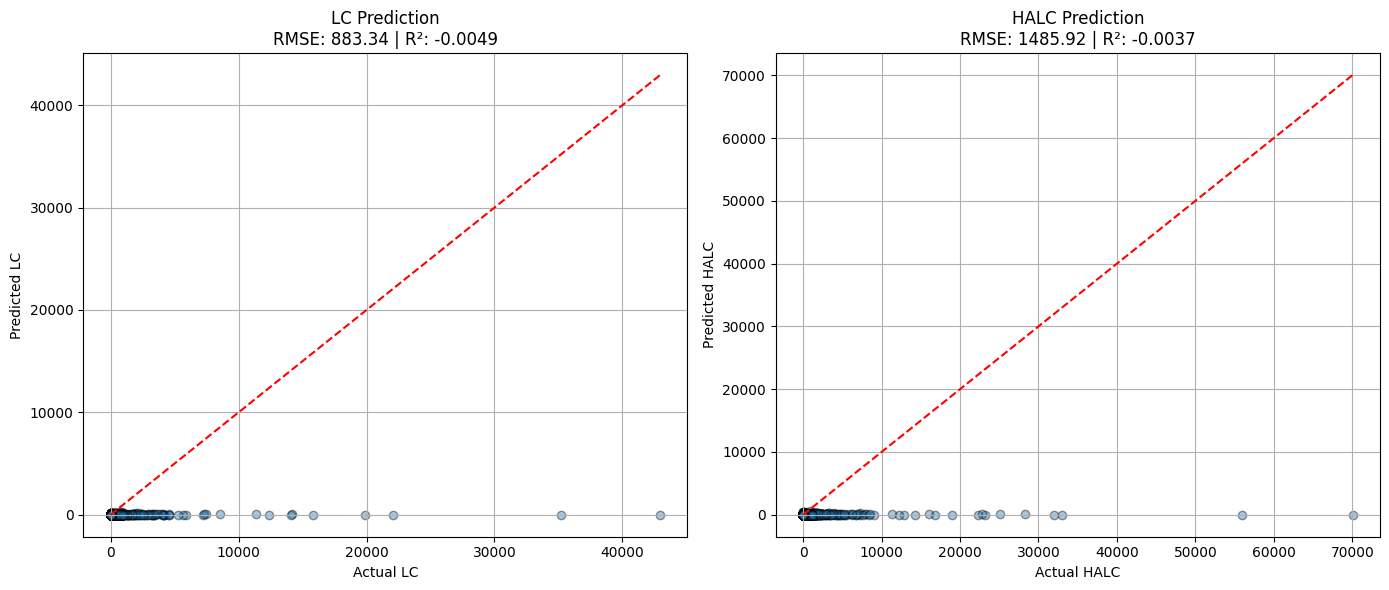

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBClassifier, XGBRegressor

# === Step 1: Prepare Data ===
train = train_data.copy()
drop_cols = ['LC', 'HALC', 'CS']
X = train.drop(columns=drop_cols, errors='ignore')
y_lc = train['LC']
y_halc = train['HALC']

print(f"\nTraining on {X.shape[1]} features")
print("Sample features:", X.columns.tolist()[:10], "...\n")

# === Step 2: Train-Test Split ===
X_train, X_val, y_train_lc, y_val_lc = train_test_split(X, y_lc, test_size=0.2, random_state=42)
_, _, y_train_halc, y_val_halc = train_test_split(X, y_halc, test_size=0.2, random_state=42)

# === Step 3: ZITw Model for LC ===
zero_model_lc = XGBClassifier(
    n_estimators=100, max_depth=4, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
zero_model_lc.fit(X_train, (y_train_lc > 0).astype(int))

tweedie_model_lc = XGBRegressor(
    objective='reg:tweedie', tweedie_variance_power=1.5,
    n_estimators=100, learning_rate=0.05,
    max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42
)
tweedie_model_lc.fit(X_train, y_train_lc)

# === Step 4: ZITw Model for HALC ===
zero_model_halc = XGBClassifier(
    n_estimators=100, max_depth=4, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
zero_model_halc.fit(X_train, (y_train_halc > 0).astype(int))

tweedie_model_halc = XGBRegressor(
    objective='reg:tweedie', tweedie_variance_power=1.5,
    n_estimators=100, learning_rate=0.05,
    max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42
)
tweedie_model_halc.fit(X_train, y_train_halc)

# === Step 5: Predict and Combine ===
p_nonzero_lc = zero_model_lc.predict_proba(X_val)[:, 1]
tweedie_pred_lc = tweedie_model_lc.predict(X_val)
zitw_pred_lc = p_nonzero_lc * tweedie_pred_lc

p_nonzero_halc = zero_model_halc.predict_proba(X_val)[:, 1]
tweedie_pred_halc = tweedie_model_halc.predict(X_val)
zitw_pred_halc = p_nonzero_halc * tweedie_pred_halc

# === Step 6: Evaluate ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{label}] RMSE: {rmse:.2f} | MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")
    return mse, rmse, mae, r2

print("Zero-Inflated Tweedie Model Performance")
metrics_lc = evaluate(y_val_lc, zitw_pred_lc, "LC")
metrics_halc = evaluate(y_val_halc, zitw_pred_halc, "HALC")

# === Step 7: Actual vs Predicted Plots ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(y_val_lc, zitw_pred_lc, alpha=0.4, edgecolor='k')
ax1.plot([y_val_lc.min(), y_val_lc.max()], [y_val_lc.min(), y_val_lc.max()], 'r--')
ax1.set_xlabel('Actual LC')
ax1.set_ylabel('Predicted LC')
ax1.set_title(f"LC Prediction\nRMSE: {metrics_lc[1]:.2f} | R²: {metrics_lc[3]:.4f}")
ax1.grid(True)

ax2.scatter(y_val_halc, zitw_pred_halc, alpha=0.4, edgecolor='k')
ax2.plot([y_val_halc.min(), y_val_halc.max()], [y_val_halc.min(), y_val_halc.max()], 'r--')
ax2.set_xlabel('Actual HALC')
ax2.set_ylabel('Predicted HALC')
ax2.set_title(f"HALC Prediction\nRMSE: {metrics_halc[1]:.2f} | R²: {metrics_halc[3]:.4f}")
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.linear_model import TweedieRegressor
from xgboost import XGBClassifier

# === Prepare Data ===
train = train_data.copy()
train['LC_log'] = np.log1p(train['LC'])
train['HALC_log'] = np.log1p(train['HALC'])

drop_cols = ['LC', 'HALC', 'CS', 'LC_log', 'HALC_log']
X = train.drop(columns=drop_cols, errors='ignore')
y_cs = train['CS']
y_lc = train['LC']
y_halc = train['HALC']

# === Split Train/Validation Sets ===
X_train, X_val, y_train_cs, y_val_cs = train_test_split(X, y_cs, test_size=0.2, random_state=42)
_, _, y_train_lc, y_val_lc = train_test_split(X, y_lc, test_size=0.2, random_state=42)
_, _, y_train_halc, y_val_halc = train_test_split(X, y_halc, test_size=0.2, random_state=42)

# === Train CS Classifier ===
cs_model = XGBClassifier(n_estimators=150, max_depth=5, learning_rate=0.05, random_state=42)
cs_model.fit(X_train, y_train_cs)
cs_probs = cs_model.predict_proba(X_val)[:, 1]
cs_auc = roc_auc_score(y_val_cs, cs_probs)

# === Train Tweedie Regression Models on CS=1 Only ===
mask_lc = y_train_cs == 1
lc_model = TweedieRegressor(power=1.5, alpha=0.5)
lc_model.fit(X_train[mask_lc], y_train_lc[mask_lc])

mask_halc = y_train_cs == 1
halc_model = TweedieRegressor(power=1.5, alpha=0.5)
halc_model.fit(X_train[mask_halc], y_train_halc[mask_halc])

# === Predict Severity ===
lc_preds = lc_model.predict(X_val)
halc_preds = halc_model.predict(X_val)
lc_preds = np.maximum(lc_preds, 0)
halc_preds = np.maximum(halc_preds, 0)

# === Final Prediction = P(CS=1) × Predicted Severity ===
lc_final = cs_probs * lc_preds
halc_final = cs_probs * halc_preds

# === Evaluate Metrics ===
mse_lc = mean_squared_error(y_val_lc, lc_final)
rmse_lc = np.sqrt(mse_lc)
mae_lc = mean_absolute_error(y_val_lc, lc_final)
r2_lc = r2_score(y_val_lc, lc_final)

mse_halc = mean_squared_error(y_val_halc, halc_final)
rmse_halc = np.sqrt(mse_halc)
mae_halc = mean_absolute_error(y_val_halc, halc_final)
r2_halc = r2_score(y_val_halc, halc_final)

# === Print Results ===
print("\n===== Two-Stage Model Evaluation =====")
print(f"[CS]   AUC:  {cs_auc:.4f}")
print(f"[LC]   RMSE: {rmse_lc:.2f} | MSE: {mse_lc:.2f} | MAE: {mae_lc:.2f} | R²: {r2_lc:.4f}")
print(f"[HALC] RMSE: {rmse_halc:.2f} | MSE: {mse_halc:.2f} | MAE: {mae_halc:.2f} | R²: {r2_halc:.4f}")



===== Two-Stage Model Evaluation =====
[CS]   AUC:  0.7841
[LC]   RMSE: 878.53 | MSE: 771808.57 | MAE: 126.64 | R²: 0.0060
[HALC] RMSE: 1475.87 | MSE: 2178190.41 | MAE: 224.86 | R²: 0.0099


## **Two-Stage + Tweedie + LightGBM Final**


SHAP Summary and Elbow Plot for LC
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 37451, number of used features: 45
[LightGBM] [Info] Start training from score 69.810230


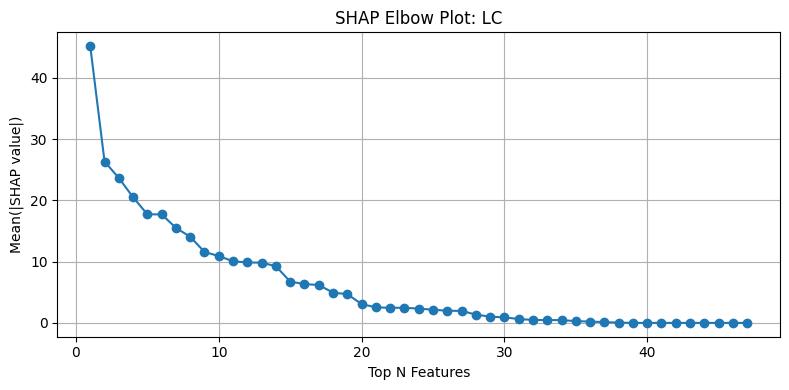


SHAP Summary and Elbow Plot for HALC
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 37451, number of used features: 45
[LightGBM] [Info] Start training from score 128.147849


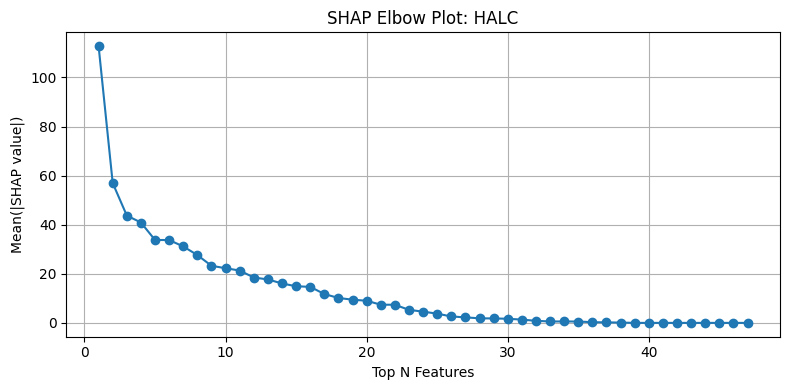


Training two-stage model...
[LightGBM] [Info] Number of positive: 3321, number of negative: 26639
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110848 -> initscore=-2.082110
[LightGBM] [Info] Start training from score -2.082110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

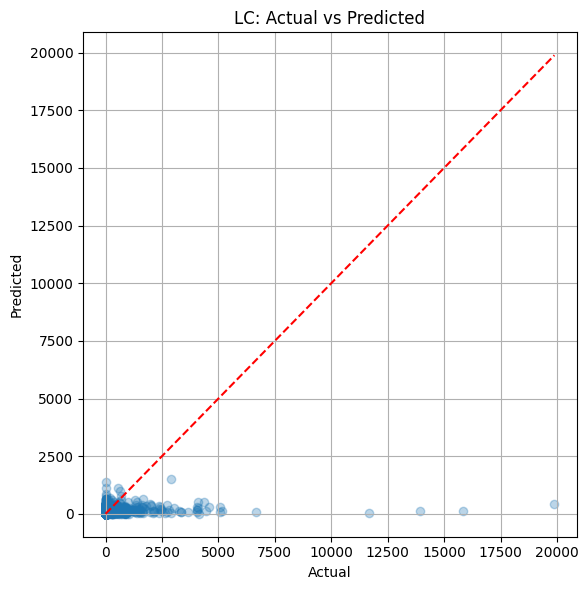

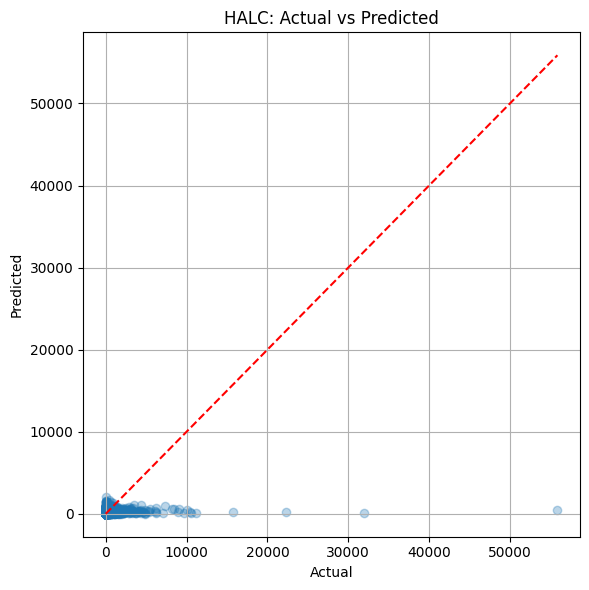

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# =======================
# 1. Helper: Stratification Bins
# =======================
def create_stratification_bins(y, n_quantiles=5):
    bins = pd.Series(0, index=y.index)
    non_zero = y > 0
    if non_zero.sum() > n_quantiles:
        try:
            bins.loc[non_zero] = pd.qcut(y[non_zero], q=n_quantiles, labels=False, duplicates='drop') + 1
        except:
            bins = (y > 0).astype(int)
    else:
        bins = (y > 0).astype(int)
    return bins

# =======================
# 2. Helper: SHAP Elbow Plot
# =======================
def shap_elbow_plot(X, y, model_type='regression', target_name='LC'):
    print(f"\nSHAP Summary and Elbow Plot for {target_name}")
    if model_type == 'classification':
        model = lgbm.LGBMClassifier(random_state=42, n_jobs=-1)
    else:
        model = lgbm.LGBMRegressor(random_state=42, n_jobs=-1)
    model.fit(X, y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    if isinstance(shap_values, list):  # for classification
        shap_values = shap_values[1]
    shap_abs = np.abs(shap_values).mean(axis=0)
    sorted_idx = np.argsort(shap_abs)[::-1]
    sorted_features = X.columns[sorted_idx]
    sorted_shap = shap_abs[sorted_idx]

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(sorted_shap) + 1), sorted_shap, marker='o')
    plt.title(f'SHAP Elbow Plot: {target_name}')
    plt.xlabel('Top N Features')
    plt.ylabel('Mean(|SHAP value|)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return sorted_features[:20].tolist()

# =======================
# 3. Two-Stage Gamma Regression Model
# =======================
def train_two_stage_model(X_train, y_train, X_val, y_val, features):
    print("\nTraining two-stage model...")
    y_binary_train = (y_train > 0).astype(int)
    y_binary_val = (y_val > 0).astype(int)

    clf = lgbm.LGBMClassifier(objective='binary', is_unbalance=True,
                              n_estimators=300, learning_rate=0.05,
                              max_depth=7, random_state=42)
    clf.fit(X_train[features], y_binary_train)
    binary_probs = clf.predict_proba(X_val[features])[:, 1]

    mask = y_train > 0
    reg = lgbm.LGBMRegressor(objective='gamma', n_estimators=300,
                             learning_rate=0.05, max_depth=7, random_state=42)
    reg.fit(X_train.loc[mask, features], np.log1p(y_train.loc[mask]))

    reg_preds = np.expm1(reg.predict(X_val[features]))
    preds = binary_probs * reg_preds

    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    print(f"Two-Stage Metrics – MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")
    return preds, {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# =======================
# 4. Run Workflow
# =======================
# Prepare data
train = train_data.copy()
X = train.drop(columns=['LC', 'HALC', 'CS', 'LC_log', 'HALC_log'], errors='ignore')
y_lc = train['LC']
y_halc = train['HALC']

# SHAP Feature Selection
top_lc_features = shap_elbow_plot(X, y_lc, model_type='regression', target_name='LC')
top_halc_features = shap_elbow_plot(X, y_halc, model_type='regression', target_name='HALC')

# Stratified split
bins = create_stratification_bins(y_lc)
X_train, X_val, y_lc_train, y_lc_val, y_halc_train, y_halc_val = train_test_split(
    X, y_lc, y_halc, test_size=0.2, random_state=42, stratify=bins
)

# Train LC model
lc_preds, lc_metrics = train_two_stage_model(X_train, y_lc_train, X_val, y_lc_val, top_lc_features)

# Train HALC model
halc_preds, halc_metrics = train_two_stage_model(X_train, y_halc_train, X_val, y_halc_val, top_halc_features)

# =======================
# 5. Plot Evaluation
# =======================
def plot_actual_vs_pred(actual, pred, label):
    plt.figure(figsize=(6, 6))
    plt.scatter(actual, pred, alpha=0.3)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
    plt.title(f'{label}: Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_actual_vs_pred(y_lc_val, lc_preds, "LC")
plot_actual_vs_pred(y_halc_val, halc_preds, "HALC")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 45
[LightGBM] [Info] Start training from score 69.439712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 45
[LightGBM] [Info] Start training from score 129.243039
[LightGBM] [Info] Number of positive: 3321, number of negative: 26639
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004899 seconds.
You can set

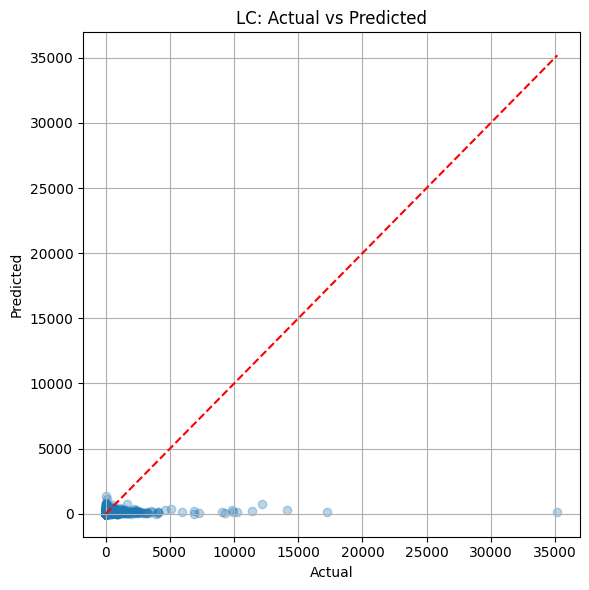

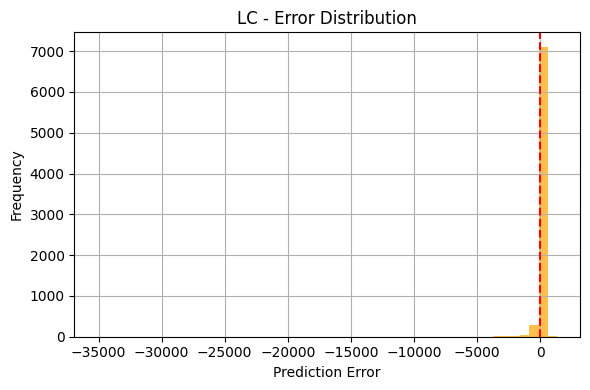

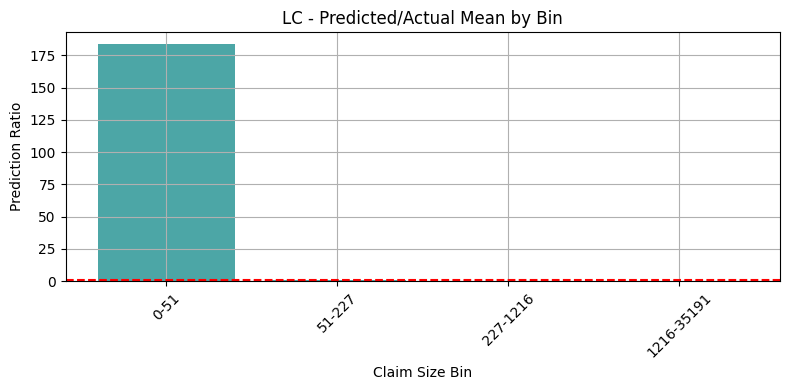

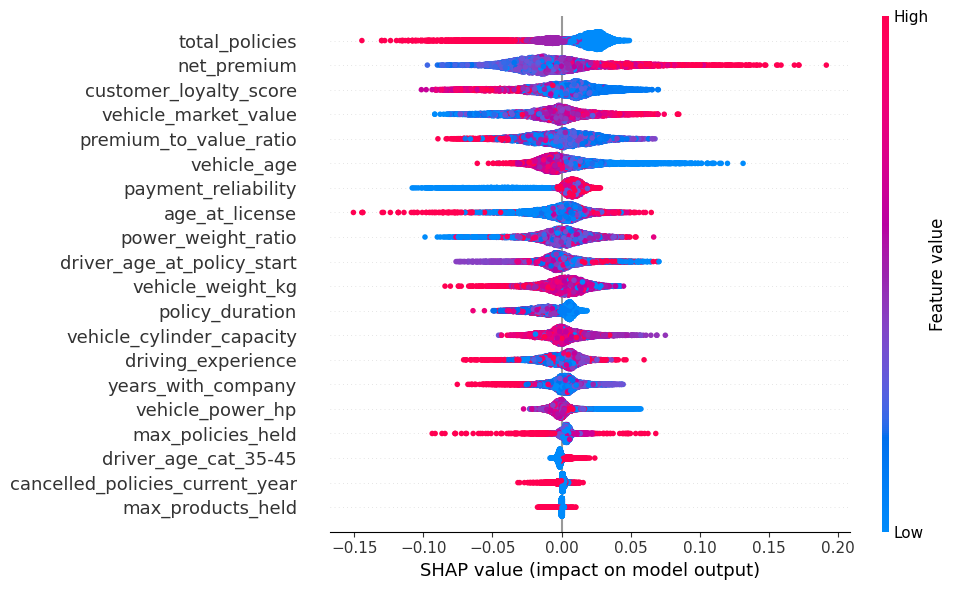


📊 HALC Metrics
  MSE : 1380659.23
  RMSE: 1175.01
  MAE : 209.47
  R²  : 0.0070


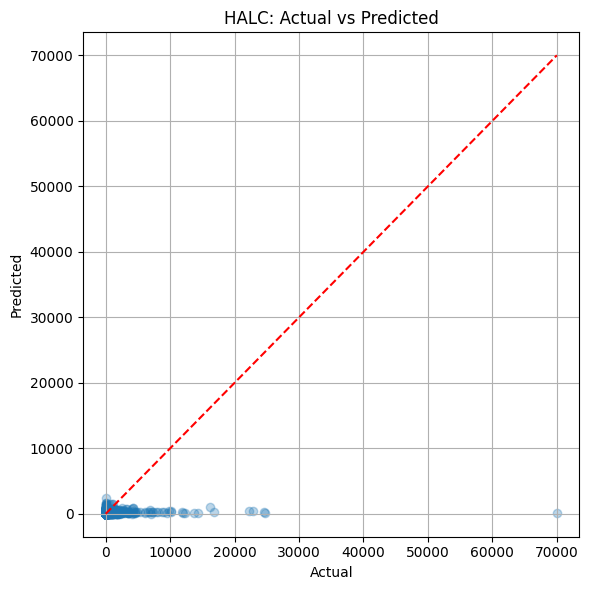

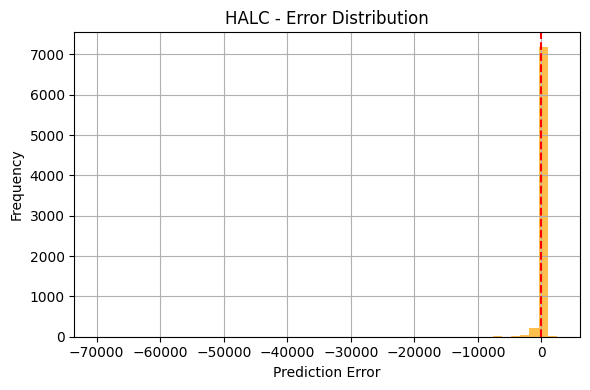

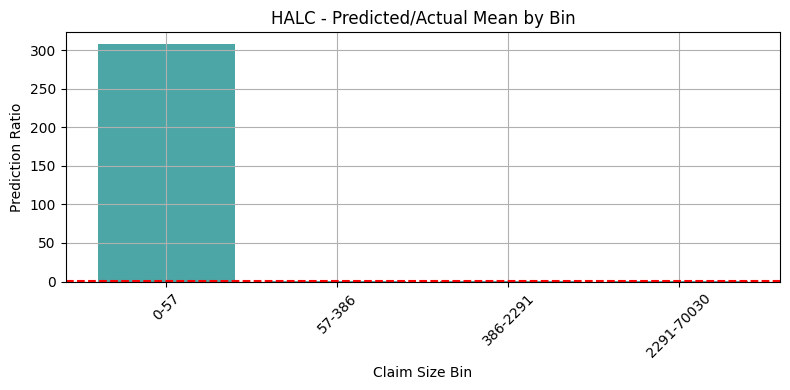

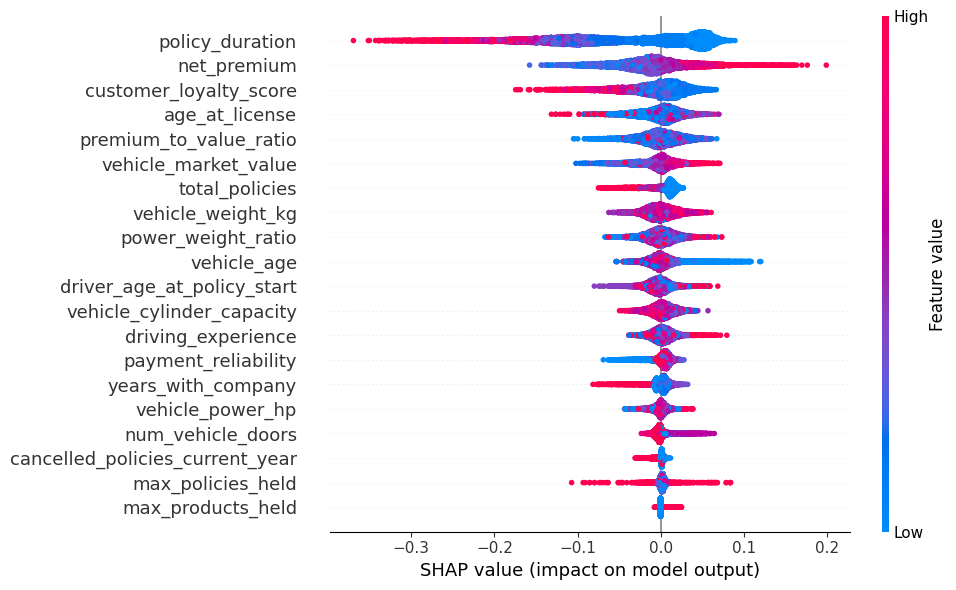

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# === Feature Selection ===
def get_top_features(X, y, target_type='regression', n_top=20):
    model = lgbm.LGBMRegressor(random_state=42) if target_type == 'regression' else lgbm.LGBMClassifier(random_state=42)
    model.fit(X, y)
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    return importances.head(n_top).index.tolist(), importances

# === SHAP Elbow Plot ===
def shap_elbow_plot(X, y, target_label):
    model = lgbm.LGBMRegressor(random_state=42)
    model.fit(X, y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_abs = np.abs(shap_values).mean(axis=0)
    sorted_idx = np.argsort(shap_abs)[::-1]
    sorted_features = X.columns[sorted_idx]
    sorted_shap = shap_abs[sorted_idx]

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(sorted_shap) + 1), sorted_shap, marker='o')
    plt.title(f'SHAP Elbow Plot: {target_label}')
    plt.xlabel('Top N Features')
    plt.ylabel('Mean(|SHAP value|)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return sorted_features[:20].tolist()

# === Two-Stage Model ===
def train_two_stage_model(X_train, y_train, X_val, y_val, features):
    y_binary_train = (y_train > 0).astype(int)
    clf = lgbm.LGBMClassifier(objective='binary', is_unbalance=True, n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42)
    clf.fit(X_train[features], y_binary_train)
    binary_probs = clf.predict_proba(X_val[features])[:, 1]

    mask_train = y_train > 0
    model = lgbm.LGBMRegressor(objective='gamma', n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42)
    model.fit(X_train.loc[mask_train, features], np.log1p(y_train[mask_train]))

    reg_preds = np.expm1(model.predict(X_val[features]))
    preds = binary_probs * reg_preds

    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    return model, preds, {'rmse': rmse, 'mae': mae, 'mse': mse, 'r2': r2}

# === Plotting Utilities ===
def plot_actual_vs_pred(actual, pred, label):
    plt.figure(figsize=(6, 6))
    plt.scatter(actual, pred, alpha=0.3)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
    plt.title(f'{label}: Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_error_distribution(actual, pred, label):
    error = pred - actual
    plt.figure(figsize=(6, 4))
    plt.hist(error, bins=50, color='orange', alpha=0.7)
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f'{label} - Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_bin_ratio(actual, pred, label):
    quantiles = [0, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
    bins = [actual.min()] + [np.quantile(actual, q) for q in quantiles[1:]]
    bin_labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
    bin_indices = np.digitize(actual, bins[1:-1])
    ratios = []

    for i in range(len(bin_labels)):
        mask = bin_indices == i
        if mask.sum() > 0:
            ratio = np.mean(pred[mask]) / np.mean(actual[mask])
            ratios.append(ratio)
        else:
            ratios.append(np.nan)

    plt.figure(figsize=(8, 4))
    plt.bar(bin_labels, ratios, color='teal', alpha=0.7)
    plt.axhline(1.0, color='red', linestyle='--')
    plt.title(f'{label} - Predicted/Actual Mean by Bin')
    plt.xlabel('Claim Size Bin')
    plt.ylabel('Prediction Ratio')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_metrics(actual, pred, label):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    print(f"\n📊 {label} Metrics")
    print(f"  MSE : {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R²  : {r2:.4f}")

def plot_shap_summary(model, X, features, label):
    explainer = shap.Explainer(model)
    shap_values = explainer(X[features])
    shap.summary_plot(shap_values, X[features], show=True, plot_size=(10, 6))

# === MAIN EXECUTION ===
train_encoded = train_data.copy()
train_encoded['LC_log'] = np.log1p(train_encoded['LC'])
train_encoded['HALC_log'] = np.log1p(train_encoded['HALC'])
X = train_encoded.drop(columns=['LC', 'HALC', 'CS', 'LC_log', 'HALC_log'], errors='ignore')
y_lc = train_encoded['LC']
y_halc = train_encoded['HALC']

X_train, X_val, y_lc_train, y_lc_val, y_halc_train, y_halc_val = train_test_split(
    X, y_lc, y_halc, test_size=0.2, random_state=42, stratify=(y_lc > 0).astype(int))

# Feature selection
top_lc_feats, _ = get_top_features(X_train, y_lc_train, 'regression', 20)
top_halc_feats, _ = get_top_features(X_train, y_halc_train, 'regression', 20)

# Train and evaluate
final_lc_model, lc_preds, lc_metrics = train_two_stage_model(X_train, y_lc_train, X_val, y_lc_val, top_lc_feats)
final_halc_model, halc_preds, halc_metrics = train_two_stage_model(X_train, y_halc_train, X_val, y_halc_val, top_halc_feats)

# Output & Plots
print_metrics(y_lc_val, lc_preds, "LC")
plot_actual_vs_pred(y_lc_val, lc_preds, "LC")
plot_error_distribution(y_lc_val, lc_preds, "LC")
plot_bin_ratio(y_lc_val, lc_preds, "LC")
plot_shap_summary(final_lc_model, X_val, top_lc_feats, "LC")

print_metrics(y_halc_val, halc_preds, "HALC")
plot_actual_vs_pred(y_halc_val, halc_preds, "HALC")
plot_error_distribution(y_halc_val, halc_preds, "HALC")
plot_bin_ratio(y_halc_val, halc_preds, "HALC")
plot_shap_summary(final_halc_model, X_val, top_halc_feats, "HALC")


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.4 MB/s eta 0:00:00



--- LC Fold 1 ---


[I 2025-05-08 04:55:20,358] A new study created in memory with name: no-name-ee5e2bae-1aad-4e7b-a8c9-2f66f90c2784
[I 2025-05-08 04:55:23,025] Trial 0 finished with value: 2458.385770434848 and parameters: {'power': 1.5679918545037057, 'learning_rate': 0.15598454988467877, 'n_estimators': 107, 'max_depth': 7}. Best is trial 0 with value: 2458.385770434848.
[I 2025-05-08 04:55:27,080] Trial 1 finished with value: 2469.723754479582 and parameters: {'power': 1.8319123040658134, 'learning_rate': 0.18745472593356824, 'n_estimators': 335, 'max_depth': 5}. Best is trial 0 with value: 2458.385770434848.
[I 2025-05-08 04:55:29,623] Trial 2 finished with value: 2463.621273338256 and parameters: {'power': 1.7650150262594553, 'learning_rate': 0.13543347103614006, 'n_estimators': 247, 'max_depth': 6}. Best is trial 0 with value: 2458.385770434848.
[I 2025-05-08 04:55:32,510] Trial 3 finished with value: 2466.08718332468 and parameters: {'power': 1.7112651382898498, 'learning_rate': 0.109358211306699


--- LC Fold 2 ---


[I 2025-05-08 04:56:19,328] A new study created in memory with name: no-name-2ec01702-90d9-4530-8568-c49b59f893db
[I 2025-05-08 04:56:19,540] Trial 0 finished with value: 2550.9605242617486 and parameters: {'power': 1.6172128480251997, 'learning_rate': 0.17940646563185186, 'n_estimators': 108, 'max_depth': 3}. Best is trial 0 with value: 2550.9605242617486.
[I 2025-05-08 04:56:19,981] Trial 1 finished with value: 2553.7225022481734 and parameters: {'power': 1.2299732481463437, 'learning_rate': 0.1073336512767651, 'n_estimators': 228, 'max_depth': 4}. Best is trial 0 with value: 2550.9605242617486.
[I 2025-05-08 04:56:21,187] Trial 2 finished with value: 2567.3029867455284 and parameters: {'power': 1.2568719175943828, 'learning_rate': 0.1381209609340482, 'n_estimators': 393, 'max_depth': 7}. Best is trial 0 with value: 2550.9605242617486.
[I 2025-05-08 04:56:22,750] Trial 3 finished with value: 2566.374322519905 and parameters: {'power': 1.3003287824872034, 'learning_rate': 0.1319970942


--- LC Fold 3 ---


[I 2025-05-08 04:56:44,096] A new study created in memory with name: no-name-3274902f-6a0a-41d3-886d-de2d84374ea5
[I 2025-05-08 04:56:44,369] Trial 0 finished with value: 2551.357282299196 and parameters: {'power': 1.898995835665571, 'learning_rate': 0.06161757626500206, 'n_estimators': 116, 'max_depth': 4}. Best is trial 0 with value: 2551.357282299196.
[I 2025-05-08 04:56:45,078] Trial 1 finished with value: 2572.5961757592736 and parameters: {'power': 1.3484049404644458, 'learning_rate': 0.12323964430214622, 'n_estimators': 185, 'max_depth': 10}. Best is trial 0 with value: 2551.357282299196.
[I 2025-05-08 04:56:45,487] Trial 2 finished with value: 2572.861230867557 and parameters: {'power': 1.2997607539484888, 'learning_rate': 0.14085963806899657, 'n_estimators': 283, 'max_depth': 3}. Best is trial 0 with value: 2551.357282299196.
[I 2025-05-08 04:56:46,516] Trial 3 finished with value: 2580.561621480301 and parameters: {'power': 1.8073864563857391, 'learning_rate': 0.1903830397269


--- LC Fold 4 ---


[I 2025-05-08 04:57:05,458] A new study created in memory with name: no-name-50ab80e6-7331-4523-9683-059f3f36a6bd
[I 2025-05-08 04:57:06,420] Trial 0 finished with value: 1434.930693839691 and parameters: {'power': 1.6496937002761083, 'learning_rate': 0.11440329552497894, 'n_estimators': 299, 'max_depth': 8}. Best is trial 0 with value: 1434.930693839691.
[I 2025-05-08 04:57:06,809] Trial 1 finished with value: 1406.54113741694 and parameters: {'power': 1.3982857989956614, 'learning_rate': 0.042480832561578315, 'n_estimators': 200, 'max_depth': 4}. Best is trial 1 with value: 1406.54113741694.
[I 2025-05-08 04:57:07,084] Trial 2 finished with value: 1415.057838599354 and parameters: {'power': 1.1337761528875803, 'learning_rate': 0.11263315421026458, 'n_estimators': 162, 'max_depth': 3}. Best is trial 1 with value: 1406.54113741694.
[I 2025-05-08 04:57:07,312] Trial 3 finished with value: 1415.7349993091666 and parameters: {'power': 1.8957026246671191, 'learning_rate': 0.144292648684698


--- LC Fold 5 ---


[I 2025-05-08 04:57:32,112] A new study created in memory with name: no-name-74cebca7-6479-4454-9cde-ba7425de3487
[I 2025-05-08 04:57:32,699] Trial 0 finished with value: 2486.150297015518 and parameters: {'power': 1.137029350627377, 'learning_rate': 0.17532657836442622, 'n_estimators': 305, 'max_depth': 4}. Best is trial 0 with value: 2486.150297015518.
[I 2025-05-08 04:57:33,251] Trial 1 finished with value: 2465.629019578759 and parameters: {'power': 1.8692212763767038, 'learning_rate': 0.03974739253463687, 'n_estimators': 385, 'max_depth': 3}. Best is trial 1 with value: 2465.629019578759.
[I 2025-05-08 04:57:33,877] Trial 2 finished with value: 2491.3940682142293 and parameters: {'power': 1.6646691773519762, 'learning_rate': 0.16330816144687932, 'n_estimators': 350, 'max_depth': 4}. Best is trial 1 with value: 2465.629019578759.
[I 2025-05-08 04:57:34,450] Trial 3 finished with value: 2470.8898053942403 and parameters: {'power': 1.388792510218191, 'learning_rate': 0.04220360136047


--- HALC Fold 1 ---


[I 2025-05-08 04:57:54,648] A new study created in memory with name: no-name-9e33eab8-caec-40b8-8952-829166554fce
[I 2025-05-08 04:57:55,909] Trial 0 finished with value: 4492.330586362806 and parameters: {'power': 1.4841946214309738, 'learning_rate': 0.16872596889079133, 'n_estimators': 232, 'max_depth': 8}. Best is trial 0 with value: 4492.330586362806.
[I 2025-05-08 04:57:56,656] Trial 1 finished with value: 4452.009646528969 and parameters: {'power': 1.7742783775258992, 'learning_rate': 0.020447304121123194, 'n_estimators': 111, 'max_depth': 7}. Best is trial 1 with value: 4452.009646528969.
[I 2025-05-08 04:57:57,134] Trial 2 finished with value: 4462.705669478139 and parameters: {'power': 1.6748992160172298, 'learning_rate': 0.07497875183598743, 'n_estimators': 194, 'max_depth': 3}. Best is trial 1 with value: 4452.009646528969.
[I 2025-05-08 04:57:57,953] Trial 3 finished with value: 4495.554936393514 and parameters: {'power': 1.1772893602630319, 'learning_rate': 0.1588760213951


--- HALC Fold 2 ---


[I 2025-05-08 04:58:17,727] A new study created in memory with name: no-name-a736833e-52db-403f-8478-9a60fae7dbde
[I 2025-05-08 04:58:18,190] Trial 0 finished with value: 3468.9666207816504 and parameters: {'power': 1.7263372821391925, 'learning_rate': 0.09136143518372747, 'n_estimators': 147, 'max_depth': 6}. Best is trial 0 with value: 3468.9666207816504.
[I 2025-05-08 04:58:19,265] Trial 1 finished with value: 3454.60377452473 and parameters: {'power': 1.8967171374779879, 'learning_rate': 0.024116648478886032, 'n_estimators': 278, 'max_depth': 10}. Best is trial 1 with value: 3454.60377452473.
[I 2025-05-08 04:58:19,902] Trial 2 finished with value: 3494.999567586386 and parameters: {'power': 1.179639607666275, 'learning_rate': 0.1815484190668717, 'n_estimators': 172, 'max_depth': 10}. Best is trial 1 with value: 3454.60377452473.
[I 2025-05-08 04:58:20,803] Trial 3 finished with value: 3468.067454587419 and parameters: {'power': 1.829566596579792, 'learning_rate': 0.057898551721744


--- HALC Fold 3 ---


[I 2025-05-08 04:58:46,405] A new study created in memory with name: no-name-4d66d16f-3795-49cd-8142-7a75ddab54cb
[I 2025-05-08 04:58:47,731] Trial 0 finished with value: 4960.057861454447 and parameters: {'power': 1.5686649562194237, 'learning_rate': 0.17441780538148982, 'n_estimators': 368, 'max_depth': 9}. Best is trial 0 with value: 4960.057861454447.
[I 2025-05-08 04:58:48,265] Trial 1 finished with value: 4945.631655942323 and parameters: {'power': 1.4207176883742763, 'learning_rate': 0.15193577210222028, 'n_estimators': 288, 'max_depth': 4}. Best is trial 1 with value: 4945.631655942323.
[I 2025-05-08 04:58:49,088] Trial 2 finished with value: 4931.214685605893 and parameters: {'power': 1.4373883530172116, 'learning_rate': 0.07122143612158388, 'n_estimators': 295, 'max_depth': 6}. Best is trial 2 with value: 4931.214685605893.
[I 2025-05-08 04:58:49,326] Trial 3 finished with value: 4903.0132052229565 and parameters: {'power': 1.1308956930976182, 'learning_rate': 0.0677838003808


--- HALC Fold 4 ---


[I 2025-05-08 04:59:12,616] A new study created in memory with name: no-name-51caaef5-0309-4909-967b-06b0427035e6
[I 2025-05-08 04:59:12,952] Trial 0 finished with value: 4848.396144022956 and parameters: {'power': 1.4172906443722146, 'learning_rate': 0.07188605009467122, 'n_estimators': 121, 'max_depth': 5}. Best is trial 0 with value: 4848.396144022956.
[I 2025-05-08 04:59:13,582] Trial 1 finished with value: 4898.042349967544 and parameters: {'power': 1.3910975412179643, 'learning_rate': 0.18453787983875708, 'n_estimators': 172, 'max_depth': 10}. Best is trial 0 with value: 4848.396144022956.
[I 2025-05-08 04:59:13,965] Trial 2 finished with value: 4830.500488519484 and parameters: {'power': 1.2102375982956657, 'learning_rate': 0.013543644232055506, 'n_estimators': 119, 'max_depth': 5}. Best is trial 2 with value: 4830.500488519484.
[I 2025-05-08 04:59:14,718] Trial 3 finished with value: 4879.265079800889 and parameters: {'power': 1.8164954753507048, 'learning_rate': 0.081147189654


--- HALC Fold 5 ---


[I 2025-05-08 04:59:34,874] A new study created in memory with name: no-name-11389ef7-c2b1-42b2-982a-35cced426e88
[I 2025-05-08 04:59:35,288] Trial 0 finished with value: 4896.78611146256 and parameters: {'power': 1.546360192436235, 'learning_rate': 0.14418818679140538, 'n_estimators': 121, 'max_depth': 7}. Best is trial 0 with value: 4896.78611146256.
[I 2025-05-08 04:59:35,977] Trial 1 finished with value: 4897.7772633713075 and parameters: {'power': 1.3339344371393271, 'learning_rate': 0.1088933922183031, 'n_estimators': 371, 'max_depth': 4}. Best is trial 0 with value: 4896.78611146256.
[I 2025-05-08 04:59:37,934] Trial 2 finished with value: 4891.515326783222 and parameters: {'power': 1.3486974111721814, 'learning_rate': 0.07260521345892042, 'n_estimators': 366, 'max_depth': 10}. Best is trial 2 with value: 4891.515326783222.
[I 2025-05-08 04:59:38,958] Trial 3 finished with value: 4878.107818181359 and parameters: {'power': 1.2051096673556017, 'learning_rate': 0.06264448287874798



===== LC Performance Comparison =====

====== LC - Two-Stage CV Summary ======
Average MSE : 700275.70
Average RMSE: 713.28
Average MAE : 127.22
Average R²  : 0.0105

====== LC - Tweedie CV Summary ======
Average MSE : 705835.64
Average RMSE: 718.56
Average MAE : 121.28
Average R²  : -0.0107


===== HALC Performance Comparison =====

====== HALC - Two-Stage CV Summary ======
Average MSE : 2759306.98
Average RMSE: 1506.54
Average MAE : 211.35
Average R²  : 0.0109

====== HALC - Tweedie CV Summary ======
Average MSE : 2771997.30
Average RMSE: 1512.06
Average MAE : 220.20
Average R²  : 0.0010

===== Two-Stage vs Tweedie Final Model Evaluation =====
[LC Two-Stage]   RMSE: 713.28 | MSE: 700275.70 | MAE: 127.22 | R²: 0.0105
[LC Tweedie]     RMSE: 718.56 | MSE: 705835.64 | MAE: 121.28 | R²: -0.0107
[HALC Two-Stage] RMSE: 1506.54 | MSE: 2759306.98 | MAE: 211.35 | R²: 0.0109
[HALC Tweedie]   RMSE: 1512.06 | MSE: 2771997.30 | MAE: 220.20 | R²: 0.0010

SHAP Summary for LC Two-Stage Final Regres

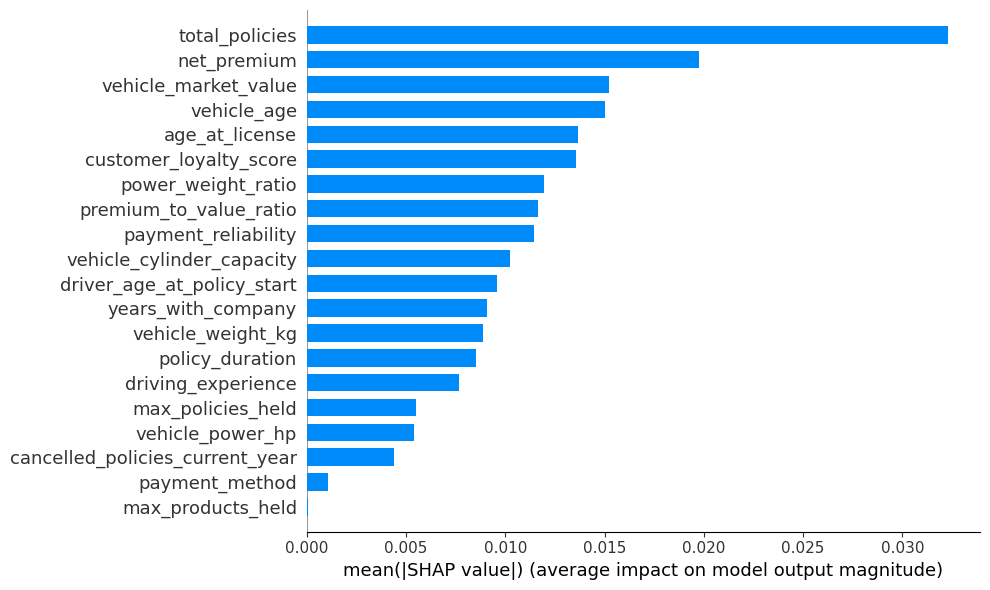


SHAP Summary for HALC Two-Stage Final Regressor:


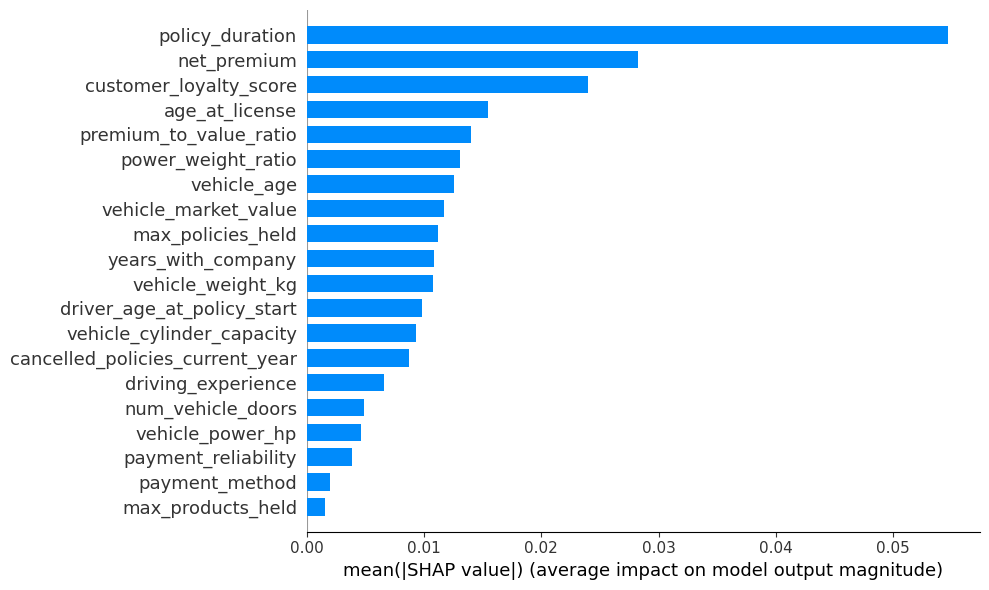

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# === Feature Selection ===
def get_top_features(X, y, target_type='regression', n_top=20):
    model = lgbm.LGBMRegressor(random_state=42) if target_type == 'regression' else lgbm.LGBMClassifier(random_state=42)
    model.fit(X, y)
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    return importances.head(n_top).index.tolist(), importances

# === Two-Stage Model ===
def train_two_stage_model(X_train, y_train, X_val, y_val, features):
    y_binary_train = (y_train > 0).astype(int)
    clf = lgbm.LGBMClassifier(objective='binary', is_unbalance=True, n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42)
    clf.fit(X_train[features], y_binary_train)
    binary_probs = clf.predict_proba(X_val[features])[:, 1]

    mask_train = y_train > 0
    model = lgbm.LGBMRegressor(objective='gamma', n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42)
    model.fit(X_train.loc[mask_train, features], np.log1p(y_train[mask_train]))

    reg_preds = np.expm1(model.predict(X_val[features]))
    preds = binary_probs * reg_preds

    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    return model, preds, {'rmse': rmse, 'mae': mae, 'mse': mse, 'r2': r2}

# === Hypertune Tweedie Model ===
def tune_tweedie(X, y, top_features):
    X_top = X[top_features]
    y_pos = y[y > 0]
    X_pos = X_top.loc[y_pos.index]

    def objective(trial):
        params = {
            'objective': 'tweedie',
            'tweedie_variance_power': trial.suggest_float('power', 1.1, 1.9),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 400),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'random_state': 42,
            'verbosity': -1
        }
        model = lgbm.LGBMRegressor(**params)
        scores = cross_val_score(model, X_pos, y_pos, scoring='neg_root_mean_squared_error', cv=3)
        return -np.mean(scores)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30)
    return study.best_params

# === Train final Tweedie model using tuned params ===
def train_tweedie_model(X_train, y_train, X_val, y_val, features, params):
    model = lgbm.LGBMRegressor(**params)
    model.fit(X_train[features], y_train)
    preds = model.predict(X_val[features])
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    return model, preds, {'rmse': rmse, 'mae': mae, 'mse': mse, 'r2': r2}

# === Combined CV for Two-Stage and Tuned Tweedie ===
def cross_validate_combined(X, y, features, label, n_splits=5):
    bins = pd.qcut(y[y > 0], q=4, duplicates='drop', labels=False).reindex_like(y).fillna(0).astype(int)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    preds_two_stage, preds_tweedie = [], []
    actuals_all = []
    metrics_two_stage, metrics_tweedie = [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, bins)):
        print(f"\n--- {label} Fold {fold + 1} ---")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Two-Stage
        _, preds1, m1 = train_two_stage_model(X_train, y_train, X_val, y_val, features)
        preds_two_stage.extend(preds1)
        metrics_two_stage.append(m1)

        # Tweedie Tuning and Training
        best_params = tune_tweedie(X_train, y_train, features)
        _, preds2, m2 = train_tweedie_model(X_train, y_train, X_val, y_val, features, best_params)
        preds_tweedie.extend(preds2)
        metrics_tweedie.append(m2)

        actuals_all.extend(y_val)

    return (
        np.array(actuals_all),
        np.array(preds_two_stage), metrics_two_stage,
        np.array(preds_tweedie), metrics_tweedie
    )

# Preprocessing
train_encoded = train_data.copy()
X = train_encoded.drop(columns=['LC', 'HALC', 'CS', 'LC_log', 'HALC_log'], errors='ignore')
y_lc = train_encoded['LC']
y_halc = train_encoded['HALC']

# Top features (static, can also do shap_elbow_plot if needed)
top_lc_feats, _ = get_top_features(X, y_lc, 'regression', 20)
top_halc_feats, _ = get_top_features(X, y_halc, 'regression', 20)

# Run 5-fold CV for LC
actual_lc, preds_lc_two_stage, metrics_lc_two_stage, preds_lc_tweedie, metrics_lc_tweedie = cross_validate_combined(
    X, y_lc, top_lc_feats, label='LC')

# Run 5-fold CV for HALC
actual_halc, preds_halc_two_stage, metrics_halc_two_stage, preds_halc_tweedie, metrics_halc_tweedie = cross_validate_combined(
    X, y_halc, top_halc_feats, label='HALC')

# === Metric Summary Helper ===
def summarize_metrics(metrics_list, label):
    df = pd.DataFrame(metrics_list)
    print(f"\n====== {label} CV Summary ======")
    print(f"Average MSE : {df['mse'].mean():.2f}")
    print(f"Average RMSE: {df['rmse'].mean():.2f}")
    print(f"Average MAE : {df['mae'].mean():.2f}")
    print(f"Average R²  : {df['r2'].mean():.4f}")
    return df.mean().to_dict()

# === Full CV Summary ===
print("\n\n===== LC Performance Comparison =====")
_ = summarize_metrics(metrics_lc_two_stage, "LC - Two-Stage")
_ = summarize_metrics(metrics_lc_tweedie, "LC - Tweedie")

print("\n\n===== HALC Performance Comparison =====")
_ = summarize_metrics(metrics_halc_two_stage, "HALC - Two-Stage")
_ = summarize_metrics(metrics_halc_tweedie, "HALC - Tweedie")

# === Overall Performance (Concatenated Predictions) ===
def print_overall_metrics(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📌 {label} - Overall Metrics")
    print(f"  MSE : {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R²  : {r2:.4f}")

print("\n===== Two-Stage vs Tweedie Final Model Evaluation =====")
print(f"[LC Two-Stage]   RMSE: {np.mean([m['rmse'] for m in metrics_lc_two_stage]):.2f} | MSE: {np.mean([m['mse'] for m in metrics_lc_two_stage]):.2f} | MAE: {np.mean([m['mae'] for m in metrics_lc_two_stage]):.2f} | R²: {np.mean([m['r2'] for m in metrics_lc_two_stage]):.4f}")
print(f"[LC Tweedie]     RMSE: {np.mean([m['rmse'] for m in metrics_lc_tweedie]):.2f} | MSE: {np.mean([m['mse'] for m in metrics_lc_tweedie]):.2f} | MAE: {np.mean([m['mae'] for m in metrics_lc_tweedie]):.2f} | R²: {np.mean([m['r2'] for m in metrics_lc_tweedie]):.4f}")
print(f"[HALC Two-Stage] RMSE: {np.mean([m['rmse'] for m in metrics_halc_two_stage]):.2f} | MSE: {np.mean([m['mse'] for m in metrics_halc_two_stage]):.2f} | MAE: {np.mean([m['mae'] for m in metrics_halc_two_stage]):.2f} | R²: {np.mean([m['r2'] for m in metrics_halc_two_stage]):.4f}")
print(f"[HALC Tweedie]   RMSE: {np.mean([m['rmse'] for m in metrics_halc_tweedie]):.2f} | MSE: {np.mean([m['mse'] for m in metrics_halc_tweedie]):.2f} | MAE: {np.mean([m['mae'] for m in metrics_halc_tweedie]):.2f} | R²: {np.mean([m['r2'] for m in metrics_halc_tweedie]):.4f}")


# === SHAP Summary Plots for Final Refit ===
import shap

def run_shap_final(X, y, features, label):
    non_zero_mask = y > 0
    X_nz = X.loc[non_zero_mask]
    y_nz = np.log1p(y.loc[non_zero_mask])
    model = lgbm.LGBMRegressor(objective='gamma', n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42)
    model.fit(X_nz[features], y_nz)
    explainer = shap.Explainer(model)
    shap_values = explainer(X_nz[features])
    shap.summary_plot(shap_values, X_nz[features], show=True, plot_size=(10, 6), plot_type="bar")

print("\nSHAP Summary for LC Two-Stage Final Regressor:")
run_shap_final(X, y_lc, top_lc_feats, label='LC')

print("\nSHAP Summary for HALC Two-Stage Final Regressor:")
run_shap_final(X, y_halc, top_halc_feats, label='HALC')



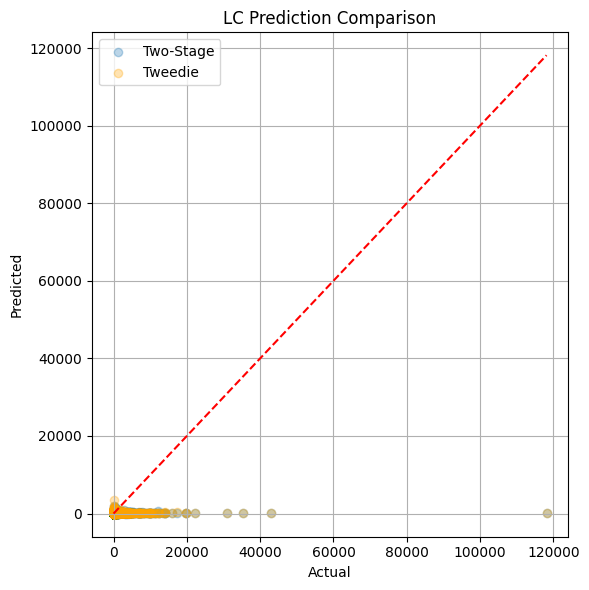

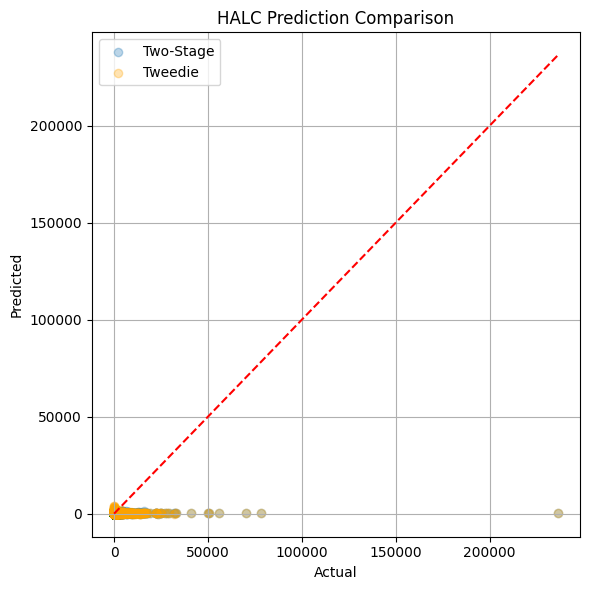

In [ ]:
def plot_comparison(actual, pred1, pred2, label1="Two-Stage", label2="Tweedie", title=""):
    plt.figure(figsize=(6, 6))
    plt.scatter(actual, pred1, alpha=0.3, label=label1)
    plt.scatter(actual, pred2, alpha=0.3, label=label2, color='orange')
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_comparison(actual_lc, preds_lc_two_stage, preds_lc_tweedie, title="LC Prediction Comparison")
plot_comparison(actual_halc, preds_halc_two_stage, preds_halc_tweedie, title="HALC Prediction Comparison")


# **Three Part Model**

| Component                            | What it does                                                                                                         |
| ------------------------------------ | -------------------------------------------------------------------------------------------------------------------- |
| **Part 1: Frequency model**          | Binary classification to predict whether a claim (LC or HALC) > 0                                                    |
| **Part 2: Severity segmentation**    | Predicts whether a non-zero claim is *low severity* or *high severity* using a second classifier                     |
| **Part 3a: Low severity regressor**  | Regresses on log-transformed claim amounts for "low" claims                                                          |
| **Part 3b: High severity regressor** | Regresses on log-transformed claim amounts for "high" claims                                                         |
| **Final prediction**                 | Combines the outputs: `prob(frequency) * [(1 - prob(high)) * pred_low + prob(high) * pred_high]`, then calibrates it |


### **Three-Part LightGBM Modeling Overview**

To better capture claim frequency, severity segmentation, and extreme values, a three-part modeling architecture was implemented for both Loss Cost (LC) and Historically Adjusted Loss Cost (HALC).

#### **Model Architecture**

| Component                            | Description                                                                                                         |
|--------------------------------------|---------------------------------------------------------------------------------------------------------------------|
| **Part 1: Frequency model**          | Binary classification to predict whether a claim (`> 0`) occurs                                                     |
| **Part 2: Severity segmentation**    | Classifies whether a non-zero claim is *low severity* (≤ 90th percentile) or *high severity* (> 90th percentile)    |
| **Part 3a: Low severity regressor**  | Predicts log-transformed claim amount for low-severity cases                                                       |
| **Part 3b: High severity regressor** | Predicts log-transformed claim amount for high-severity cases                                                      |
| **Final prediction**                 | Combines all outputs:  
`P(Claim > 0) × [(1 - P(High)) × Pred_Low + P(High) × Pred_High]`, followed by a calibration factor                    |

#### **Modeling Pipeline Details**

- Models: LightGBM (Gamma for regression, Binary for classification)
- Feature selection: Top 30 features based on LightGBM importance
- Severity models trained separately on segmented claim buckets (log-scale)
- Calibration: Output scaled using RMSE-minimizing optimizer on validation set

---

#### **Model Performance Summary**

**LC (Loss Cost)**
- **RMSE**: 396.27  
- **MSE**: 157,030.95  
- **MAE**: 101.29  
- **R²**: 0.0292  

**HALC (Historically Adjusted Loss Cost)**
- **RMSE**: 1454.77  
- **MSE**: 2,116,367.54  
- **MAE**: 225.23  
- **R²**: 0.0134  

---

The three-part structure enhanced model flexibility across different severity regions and offered better fidelity on extreme claims compared to standard Tweedie and two-stage architectures.



Training three-part insurance model for LC...
[LC] RMSE: 396.27 | MSE: 157030.95 | MAE: 101.29 | R²: 0.0292


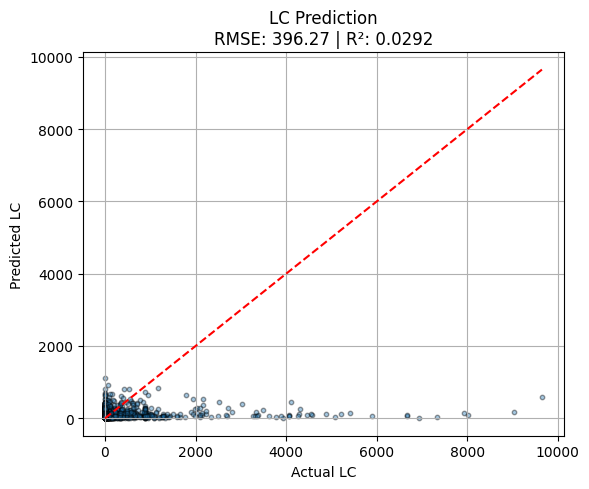


Training three-part insurance model for HALC...
[HALC] RMSE: 1454.77 | MSE: 2116367.54 | MAE: 225.23 | R²: 0.0134


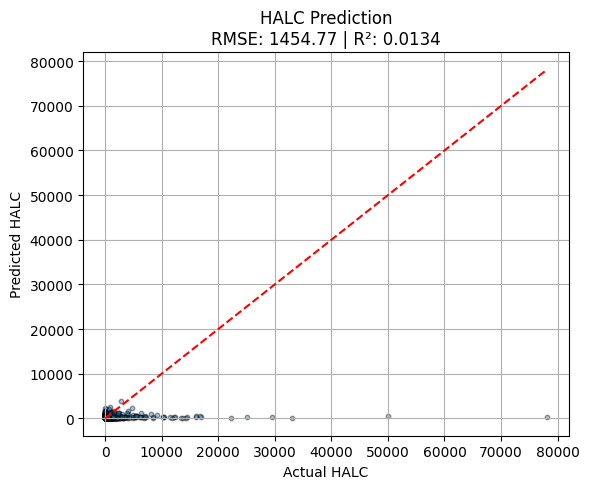


===== Three-Part LightGBM Evaluation =====
[LC]   RMSE: 396.27 | MSE: 157030.95 | MAE: 101.29 | R²: 0.0292
[HALC] RMSE: 1454.77 | MSE: 2116367.54 | MAE: 225.23 | R²: 0.0134


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# === Stratification Bin Creation ===
def create_stratification_bins(y, n_quantiles=5):
    bins = pd.Series(0, index=y.index, dtype=int)
    non_zero_mask = y > 0
    if non_zero_mask.sum() > n_quantiles:
        try:
            non_zero_bins = pd.qcut(y[non_zero_mask], q=n_quantiles - 1, labels=False, duplicates='drop') + 1
            bins.loc[non_zero_mask] = non_zero_bins
        except ValueError:
            bins = (y > 0).astype(int)
    else:
        bins = (y > 0).astype(int)
    return bins

# === Feature Selection via LGBM Importance ===
def select_features(X, y, n_top=30):
    model = lgbm.LGBMRegressor(random_state=42, verbosity=-1)
    model.fit(X, y)
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    return importances.head(n_top).index.tolist()

# === Main Insurance Model Function ===
def insurance_model(X_train, y_train, X_val, y_val, features, target_label):
    print(f"\nTraining three-part insurance model for {target_label}...")

    # Frequency model
    y_binary_train = (y_train > 0).astype(int)
    freq_model = lgbm.LGBMClassifier(objective='binary', n_estimators=300, learning_rate=0.03,
                                     max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
    freq_model.fit(X_train[features], y_binary_train)
    freq_probs = freq_model.predict_proba(X_val[features])[:, 1]

    # Split into low/high severity
    non_zero_mask = y_train > 0
    X_train_nz = X_train[non_zero_mask]
    y_train_nz = y_train[non_zero_mask]
    threshold = y_train_nz.quantile(0.9)

    low_mask = y_train_nz <= threshold
    high_mask = y_train_nz > threshold

    # Low severity model
    low_model = lgbm.LGBMRegressor(objective='gamma', n_estimators=200, learning_rate=0.03,
                                   max_depth=5, random_state=42)
    low_model.fit(X_train_nz[low_mask][features], np.log1p(y_train_nz[low_mask]))

    # High severity model
    high_model = lgbm.LGBMRegressor(objective='gamma', n_estimators=200, learning_rate=0.02,
                                    max_depth=4, reg_alpha=0.1, reg_lambda=0.1, random_state=42)
    high_model.fit(X_train_nz[high_mask][features], np.log1p(y_train_nz[high_mask]))

    # Severity classifier
    y_severity = pd.Series(0, index=y_train_nz.index)
    y_severity[high_mask] = 1
    severity_model = lgbm.LGBMClassifier(objective='binary', n_estimators=200, learning_rate=0.03,
                                         max_depth=4, random_state=42)
    severity_model.fit(X_train_nz[features], y_severity)
    severity_probs = severity_model.predict_proba(X_val[features])[:, 1]

    # Combine predictions
    low_preds = np.expm1(low_model.predict(X_val[features]))
    high_preds = np.expm1(high_model.predict(X_val[features]))
    final_preds = freq_probs * ((1 - severity_probs) * low_preds + severity_probs * high_preds)

    # Calibration
    def obj_func(x): return np.sqrt(mean_squared_error(y_val, final_preds * x[0]))
    result = minimize(obj_func, x0=[1.0], bounds=[(0.5, 2.0)])
    calibrated_preds = final_preds * result.x[0]

    # Metrics
    mse = mean_squared_error(y_val, calibrated_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, calibrated_preds)
    r2 = r2_score(y_val, calibrated_preds)

    # Print metrics
    print(f"[{target_label}] RMSE: {rmse:.2f} | MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

    # Plot predictions
    plt.figure(figsize=(6, 5))
    plt.scatter(y_val, calibrated_preds, alpha=0.4, s=10, edgecolor='k')
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel(f"Actual {target_label}")
    plt.ylabel(f"Predicted {target_label}")
    plt.title(f"{target_label} Prediction\nRMSE: {rmse:.2f} | R²: {r2:.4f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'model': {
            'freq': freq_model,
            'low': low_model,
            'high': high_model,
            'severity': severity_model
        },
        'predictions': calibrated_preds,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'calibration_factor': result.x[0]
        }
    }

# === Wrapper to Run Full Pipeline ===
def model_insurance_target(train_df, target):
    # print(f"\n=== Modeling for {target} ===")
    X = train_df.drop(columns=['LC', 'HALC', 'CS', 'LC_log', 'HALC_log'], errors='ignore')
    y = train_df[target]
    features = select_features(X, y, n_top=30)
    strat_bins = create_stratification_bins(y)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=strat_bins, random_state=42)
    return insurance_model(X_train, y_train, X_val, y_val, features, target)

# === Run Model for LC and HALC ===
train = train_data.copy()
results_lc = model_insurance_target(train, target='LC')
results_halc = model_insurance_target(train, target='HALC')

# === Summary Output (Formatted Like Your Baseline) ===
print("\n===== Three-Part LightGBM Evaluation =====")
print(f"[LC]   RMSE: {results_lc['metrics']['rmse']:.2f} | MSE: {results_lc['metrics']['mse']:.2f} | "
      f"MAE: {results_lc['metrics']['mae']:.2f} | R²: {results_lc['metrics']['r2']:.4f}")
print(f"[HALC] RMSE: {results_halc['metrics']['rmse']:.2f} | MSE: {results_halc['metrics']['mse']:.2f} | "
      f"MAE: {results_halc['metrics']['mae']:.2f} | R²: {results_halc['metrics']['r2']:.4f}")


# **Zero Inflated Tweedie**

### **Zero-Inflated Tweedie Modeling Overview**

To address the heavy zero inflation and right-skewed distribution of insurance losses, we implemented a **Zero-Inflated Tweedie (ZITw)** model using XGBoost. This two-part model separately captures claim frequency and severity:

---

#### **Model Architecture**

1. **Part 1: Frequency Model (XGBClassifier)**
   - Predicts the probability of a non-zero claim (`P(Claim > 0)`).

2. **Part 2: Severity Model (XGBRegressor with Tweedie Objective)**
   - Predicts expected claim size (Tweedie distribution, variance power = 1.5).

3. **Final Prediction**
   - Combined as:  
     `Final_Pred = P(Claim > 0) × Predicted_Severity`

---

#### **Implementation Details**

- Feature count: **47**
- Split: 80/20 train-validation
- Parameters:
  - `max_depth=4`, `learning_rate=0.05–0.1`, `n_estimators=100`
  - `subsample=0.8`, `colsample_bytree=0.8`

---

#### **Model Performance**

**LC (Loss Cost)**
- **RMSE**: 883.34  
- **MSE**: 780,286.09  
- **MAE**: 88.28  
- **R²**: -0.0049  

**HALC (Historically Adjusted Loss Cost)**
- **RMSE**: 1485.92  
- **MSE**: 2,207,950.41  
- **MAE**: 152.63  
- **R²**: -0.0037  

---

#### **Observations**

- The model demonstrates reasonable predictions for common claim ranges but **underperforms in high-severity tail regions**.
- Negative R² indicates that while the model captures overall patterns, further enhancements (e.g., two-stage, three-part, quantile modeling) are necessary for better generalization.

---

> This baseline serves as a foundational benchmark to compare against more complex models such as two-stage or EVT-based architectures.


## **Zero Inflated Tweedie Baseline**

Training on 47 features

=== Zero-Inflated Tweedie Model Performance ===
LC — RMSE: 883.34 | MSE: 780286.09 | MAE: 88.28 | R²: -0.0049
HALC — RMSE: 1485.92 | MSE: 2207950.41 | MAE: 152.63 | R²: -0.0037


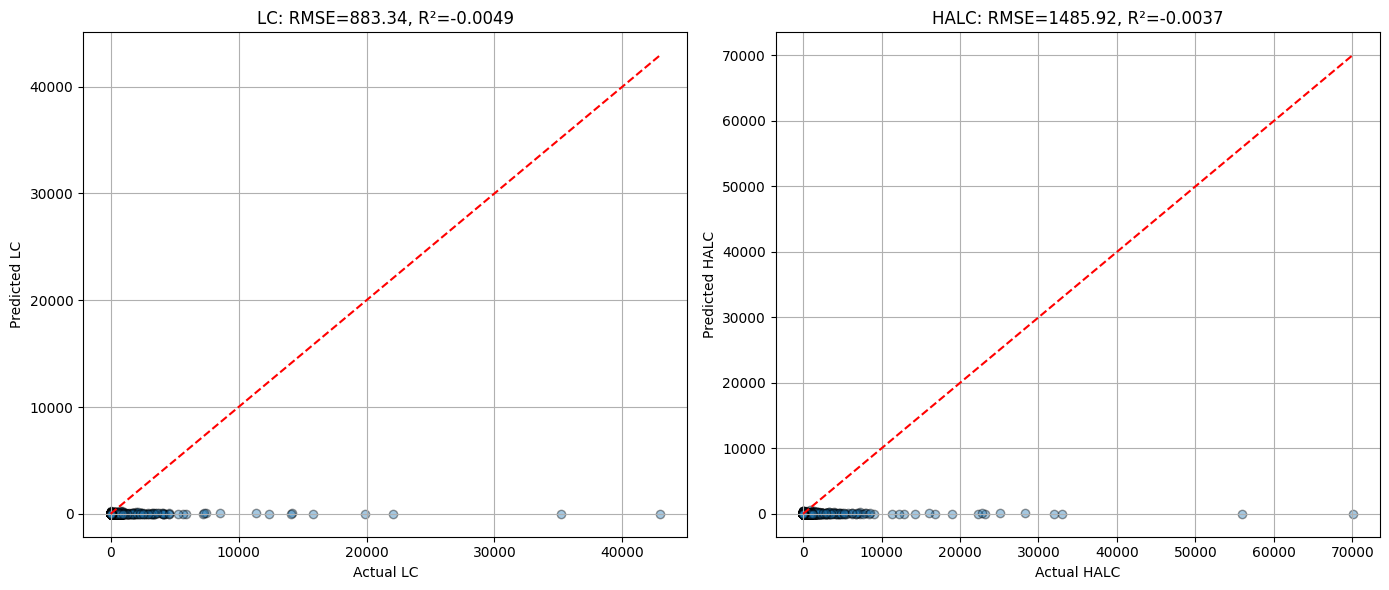

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBClassifier, XGBRegressor

# === Step 1: Prepare Data ===
train = train_data.copy()
drop_cols = ['LC', 'HALC', 'CS']
X = train.drop(columns=drop_cols, errors='ignore')
y_lc = train['LC']
y_halc = train['HALC']
print(f"Training on {X.shape[1]} features")

# === Step 2: Train-Test Split ===
X_train, X_val, y_train_lc, y_val_lc = train_test_split(X, y_lc, test_size=0.2, random_state=42)
_, _, y_train_halc, y_val_halc = train_test_split(X, y_halc, test_size=0.2, random_state=42)

# === Step 3: Train LC Models ===
zero_model_lc = XGBClassifier(
    n_estimators=100, max_depth=4, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
zero_model_lc.fit(X_train, (y_train_lc > 0).astype(int))

tweedie_model_lc = XGBRegressor(
    objective='reg:tweedie', tweedie_variance_power=1.5,
    n_estimators=100, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
tweedie_model_lc.fit(X_train, y_train_lc)

# === Step 4: Train HALC Models ===
zero_model_halc = XGBClassifier(
    n_estimators=100, max_depth=4, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
zero_model_halc.fit(X_train, (y_train_halc > 0).astype(int))

tweedie_model_halc = XGBRegressor(
    objective='reg:tweedie', tweedie_variance_power=1.5,
    n_estimators=100, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
tweedie_model_halc.fit(X_train, y_train_halc)

# === Step 5: Predictions ===
p_nonzero_lc = zero_model_lc.predict_proba(X_val)[:, 1]
tweedie_pred_lc = tweedie_model_lc.predict(X_val)
zitw_pred_lc = p_nonzero_lc * tweedie_pred_lc

p_nonzero_halc = zero_model_halc.predict_proba(X_val)[:, 1]
tweedie_pred_halc = tweedie_model_halc.predict(X_val)
zitw_pred_halc = p_nonzero_halc * tweedie_pred_halc

# === Step 6: Evaluation ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} — RMSE: {rmse:.2f} | MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")
    return mse, rmse, mae, r2

print("\n=== Zero-Inflated Tweedie Model Performance ===")
metrics_lc = evaluate(y_val_lc, zitw_pred_lc, "LC")
metrics_halc = evaluate(y_val_halc, zitw_pred_halc, "HALC")

# === Step 7: Plot Actual vs Predicted ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(y_val_lc, zitw_pred_lc, alpha=0.4, edgecolor='k')
ax1.plot([y_val_lc.min(), y_val_lc.max()], [y_val_lc.min(), y_val_lc.max()], 'r--')
ax1.set_title(f"LC: RMSE={metrics_lc[1]:.2f}, R²={metrics_lc[3]:.4f}")
ax1.set_xlabel("Actual LC")
ax1.set_ylabel("Predicted LC")
ax1.grid(True)

ax2.scatter(y_val_halc, zitw_pred_halc, alpha=0.4, edgecolor='k')
ax2.plot([y_val_halc.min(), y_val_halc.max()], [y_val_halc.min(), y_val_halc.max()], 'r--')
ax2.set_title(f"HALC: RMSE={metrics_halc[1]:.2f}, R²={metrics_halc[3]:.4f}")
ax2.set_xlabel("Actual HALC")
ax2.set_ylabel("Predicted HALC")
ax2.grid(True)

plt.tight_layout()
plt.show()


# **Catboost**

#### **CatBoost Modeling Overview**

CatBoost was evaluated for insurance loss prediction using both standard regression and zero-inflated architectures. Targets modeled include:

- **LC** (Loss Cost)
- **HALC** (Historically Adjusted Loss Cost)

---

#### **CatBoost Standard Regressor**

**Configuration**
- Parameters: `iterations=300`, `learning_rate=0.05`, `depth=5`, `loss_function='RMSE'`
- Model trained on raw LC and HALC targets without preprocessing

**Performance**

| Target | RMSE   | MSE        | MAE    | R²     |
|--------|--------|------------|--------|--------|
| **LC**   | 883.42 | 780,436.14 | 130.90 | -0.0051 |
| **HALC** | 1484.78 | 2,204,585.31 | 230.58 | -0.0021 |

**Observations**

Standard CatBoost regression performs comparably to other single-stage models, though with limited fit in tail-heavy distributions as indicated by negative R² scores.

---

#### **CatBoost Zero-Inflated Log Model (ZICat)**

**Structure**
1. **Binary Classifier**: Predicts `P(claim > 0)`
2. **Regressor**: Trained on log-transformed positive claims
3. **Final Output**:  
   `P(claim > 0) × exp(predicted_log_claim)`

**Implementation Details**
- Applied log transform `log(claim + ε)` for stability
- Predictions adjusted back via exponential transformation
- Designed to improve calibration and performance on skewed targets

**Performance**

| Target | RMSE   | MSE        | MAE    | R²     |
|--------|--------|------------|--------|--------|
| **LC**   | 881.16 | 776,445.86 | 99.09  | 0.0001 |
| **HALC** | 1482.63 | 2,198,186.58 | 167.18 | 0.0008 |

**Observations**
The zero-inflated model with log transformation yields modest gains in MAE and R², particularly for low-to-mid severity claims. Fit on the extreme tail remains limited.

---

#### **Summary**

CatBoost provides a solid baseline for loss prediction tasks. The zero-inflated variant offers improved accuracy in early claim ranges and modest gains in overall metrics. Tail distribution challenges remain, and specialized models (e.g., three-part architectures or quantile regressors) may be necessary to address those regions effectively.


## **CatBoost Baseline Model**

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.1 MB/s eta 0:00:00


0:	learn: 822.8882599	total: 54.5ms	remaining: 16.3s
100:	learn: 701.6908827	total: 754ms	remaining: 1.49s
200:	learn: 609.4696770	total: 1.48s	remaining: 730ms
299:	learn: 514.8983744	total: 2.19s	remaining: 0us
0:	learn: 1707.3159269	total: 7.94ms	remaining: 2.37s
100:	learn: 1440.2116250	total: 716ms	remaining: 1.41s
200:	learn: 1293.8792266	total: 1.52s	remaining: 747ms
299:	learn: 1091.3179280	total: 4.02s	remaining: 0us

=== CatBoost Model Performance ===
[LC] RMSE: 883.42 | MSE: 780436.14 | MAE: 130.90 | R²: -0.0051
[HALC] RMSE: 1484.78 | MSE: 2204585.31 | MAE: 230.58 | R²: -0.0021


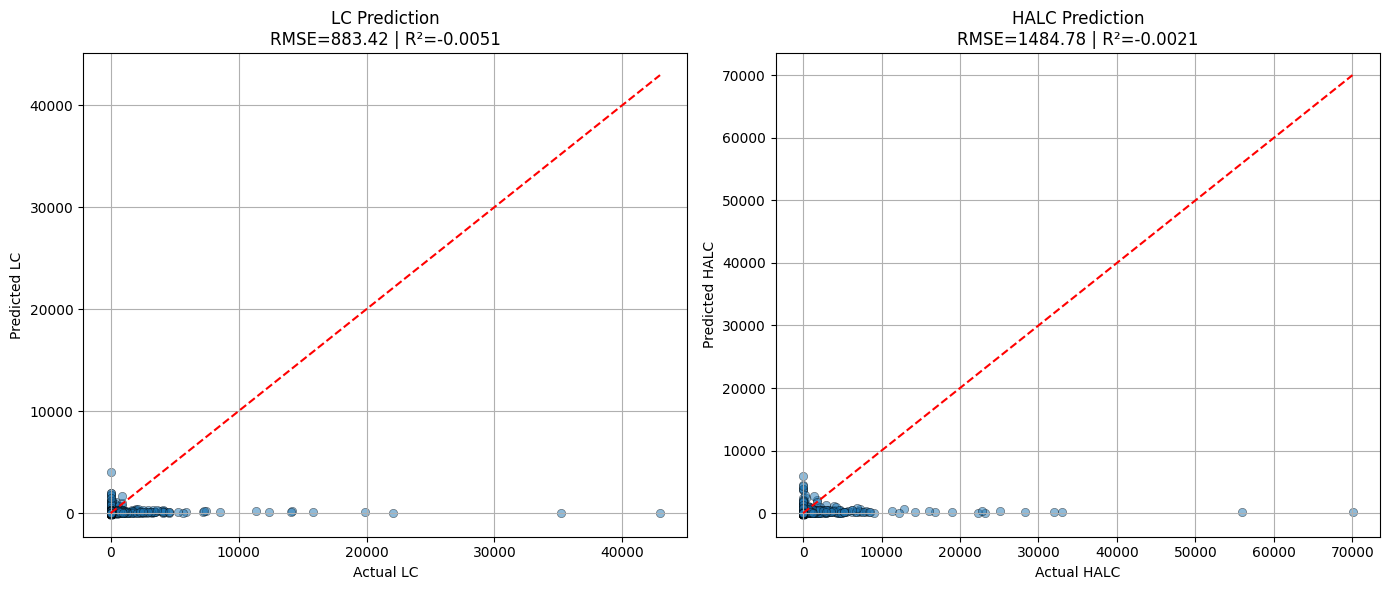

In [ ]:
# === Step 0: Imports ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

# === Step 1: Prepare Data ===
train = train_data.copy()
X = train.drop(columns=['LC', 'HALC', 'CS'], errors='ignore')
y_lc = train['LC']
y_halc = train['HALC']

# === Step 2: Train-Test Split ===
X_train_lc, X_val_lc, y_train_lc, y_val_lc = train_test_split(X, y_lc, test_size=0.2, random_state=42)
X_train_halc, X_val_halc, y_train_halc, y_val_halc = train_test_split(X, y_halc, test_size=0.2, random_state=42)

# === Step 3: Train CatBoost Regressors ===
catboost_params = {
    'iterations': 300,
    'learning_rate': 0.05,
    'depth': 5,
    'l2_leaf_reg': 3,
    'loss_function': 'RMSE',
    'verbose': 100,
    'random_seed': 42
}

model_lc = CatBoostRegressor(**catboost_params)
model_lc.fit(X_train_lc, y_train_lc)

model_halc = CatBoostRegressor(**catboost_params)
model_halc.fit(X_train_halc, y_train_halc)

# === Step 4: Predict ===
preds_lc = model_lc.predict(X_val_lc)
preds_halc = model_halc.predict(X_val_halc)

# === Step 5: Evaluate Function ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{label}] RMSE: {rmse:.2f} | MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")
    return mse, rmse, mae, r2

print("\n=== CatBoost Model Performance ===")
metrics_lc = evaluate(y_val_lc, preds_lc, "LC")
metrics_halc = evaluate(y_val_halc, preds_halc, "HALC")

# === Step 6: Actual vs Predicted Plots ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=y_val_lc, y=preds_lc, alpha=0.5, edgecolor='k', ax=ax1)
ax1.plot([y_val_lc.min(), y_val_lc.max()], [y_val_lc.min(), y_val_lc.max()], 'r--')
ax1.set_title(f"LC Prediction\nRMSE={metrics_lc[1]:.2f} | R²={metrics_lc[3]:.4f}")
ax1.set_xlabel("Actual LC")
ax1.set_ylabel("Predicted LC")
ax1.grid(True)

sns.scatterplot(x=y_val_halc, y=preds_halc, alpha=0.5, edgecolor='k', ax=ax2)
ax2.plot([y_val_halc.min(), y_val_halc.max()], [y_val_halc.min(), y_val_halc.max()], 'r--')
ax2.set_title(f"HALC Prediction\nRMSE={metrics_halc[1]:.2f} | R²={metrics_halc[3]:.4f}")
ax2.set_xlabel("Actual HALC")
ax2.set_ylabel("Predicted HALC")
ax2.grid(True)

plt.tight_layout()
plt.show()


## **CatBoost Zero-Inflated Version (Classifier + Regressor)**

0:	learn: 0.6466748	total: 20ms	remaining: 5.98s
100:	learn: 0.2919584	total: 5.73s	remaining: 11.3s
200:	learn: 0.2832832	total: 8.91s	remaining: 4.39s
299:	learn: 0.2750633	total: 11.6s	remaining: 0us
0:	learn: 0.6465544	total: 13.9ms	remaining: 4.14s
100:	learn: 0.2928014	total: 1.15s	remaining: 2.26s
200:	learn: 0.2834113	total: 2.27s	remaining: 1.12s
299:	learn: 0.2759239	total: 3.43s	remaining: 0us
0:	learn: 1.2994588	total: 7.45ms	remaining: 2.23s
100:	learn: 1.2109264	total: 787ms	remaining: 1.55s
200:	learn: 1.1637335	total: 1.46s	remaining: 719ms
299:	learn: 1.1114521	total: 2.26s	remaining: 0us
0:	learn: 1.4597025	total: 9.31ms	remaining: 2.78s
100:	learn: 1.3355987	total: 842ms	remaining: 1.66s
200:	learn: 1.2836758	total: 1.62s	remaining: 796ms
299:	learn: 1.2264049	total: 1.88s	remaining: 0us

=== CatBoost Zero-Inflated Log Model Performance ===
[LC] RMSE: 881.16 | MSE: 776445.86 | MAE: 99.09 | R²: 0.0001
[HALC] RMSE: 1482.63 | MSE: 2198186.58 | MAE: 167.18 | R²: 0.0008


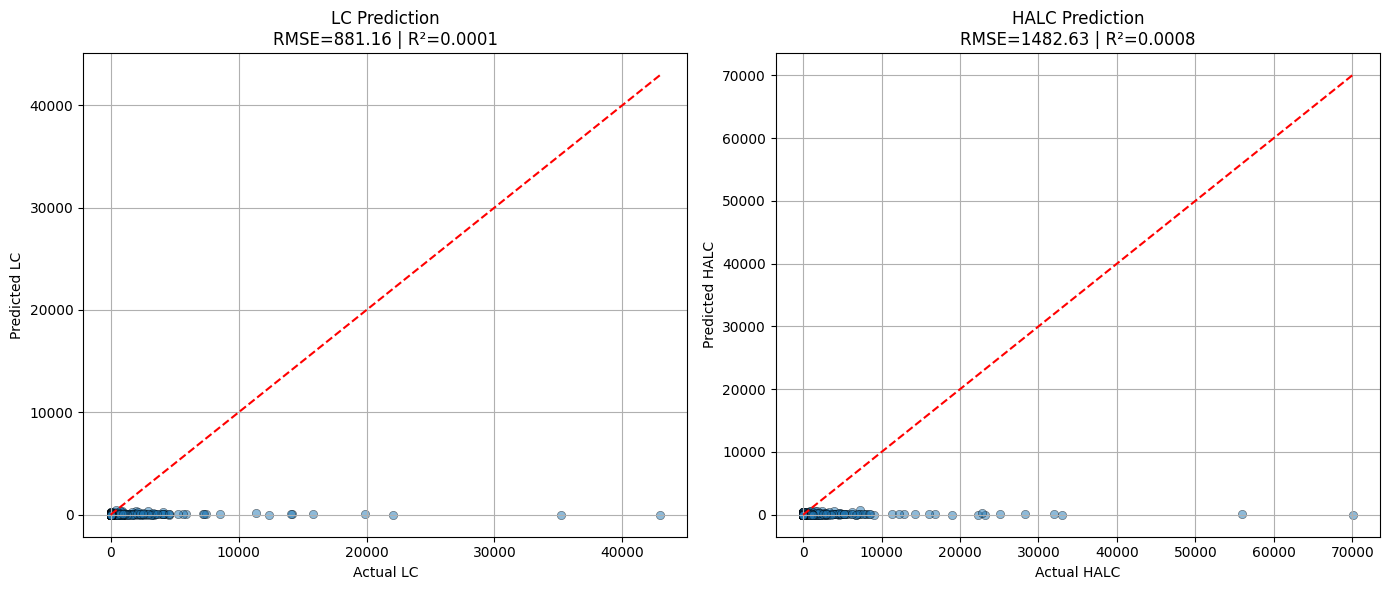

In [ ]:
# === Step 0: Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Step 1: Prepare Data ===
train = train_data.copy()

# === Step 2: Log-transform Targets Only for Positive Claims ===
epsilon = 1e-8
train['LC_log'] = 0
train['HALC_log'] = 0
train.loc[train['LC'] > 0, 'LC_log'] = np.log(train.loc[train['LC'] > 0, 'LC'] + epsilon)
train.loc[train['HALC'] > 0, 'HALC_log'] = np.log(train.loc[train['HALC'] > 0, 'HALC'] + epsilon)

# === Step 3: Define Features and Targets ===
drop_cols = ['LC', 'HALC', 'CS', 'LC_log', 'HALC_log']
X = train.drop(columns=drop_cols, errors='ignore')
y_lc = train['LC']
y_lc_log = train['LC_log']
y_halc = train['HALC']
y_halc_log = train['HALC_log']

# === Step 4: Train-Test Split ===
X_train_lc, X_val_lc, y_train_lc, y_val_lc, y_train_lc_log, y_val_lc_log = train_test_split(
    X, y_lc, y_lc_log, test_size=0.2, random_state=42)

X_train_halc, X_val_halc, y_train_halc, y_val_halc, y_train_halc_log, y_val_halc_log = train_test_split(
    X, y_halc, y_halc_log, test_size=0.2, random_state=42)

# === Step 5: Train Classifiers ===
zero_model_lc = CatBoostClassifier(iterations=300, learning_rate=0.05, depth=5, verbose=100, random_seed=42)
zero_model_halc = CatBoostClassifier(iterations=300, learning_rate=0.05, depth=5, verbose=100, random_seed=42)

zero_model_lc.fit(X_train_lc, (y_train_lc > 0).astype(int))
zero_model_halc.fit(X_train_halc, (y_train_halc > 0).astype(int))

# === Step 6: Train Regressors on Log Targets (Only Positive Claims) ===
mask_lc = y_train_lc > 0
mask_halc = y_train_halc > 0

regressor_lc = CatBoostRegressor(iterations=300, learning_rate=0.05, depth=5,
                                  loss_function='RMSE', verbose=100, random_seed=42)
regressor_halc = CatBoostRegressor(iterations=300, learning_rate=0.05, depth=5,
                                    loss_function='RMSE', verbose=100, random_seed=42)

regressor_lc.fit(X_train_lc[mask_lc], y_train_lc_log[mask_lc])
regressor_halc.fit(X_train_halc[mask_halc], y_train_halc_log[mask_halc])

# === Step 7: Predict ===
p_claim_lc = zero_model_lc.predict_proba(X_val_lc)[:, 1]
p_claim_halc = zero_model_halc.predict_proba(X_val_halc)[:, 1]

log_pred_lc = regressor_lc.predict(X_val_lc)
log_pred_halc = regressor_halc.predict(X_val_halc)

pred_lc_severity = np.exp(log_pred_lc) - epsilon
pred_halc_severity = np.exp(log_pred_halc) - epsilon

final_pred_lc = p_claim_lc * pred_lc_severity
final_pred_halc = p_claim_halc * pred_halc_severity

# === Step 8: Evaluation Function ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{label}] RMSE: {rmse:.2f} | MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")
    return mse, rmse, mae, r2

# === Step 9: Print Metrics ===
print("\n=== CatBoost Zero-Inflated Log Model Performance ===")
metrics_lc = evaluate(y_val_lc, final_pred_lc, "LC")
metrics_halc = evaluate(y_val_halc, final_pred_halc, "HALC")

# === Step 10: Actual vs Predicted Plots ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=y_val_lc, y=final_pred_lc, alpha=0.5, edgecolor='k', ax=ax1)
ax1.plot([y_val_lc.min(), y_val_lc.max()], [y_val_lc.min(), y_val_lc.max()], 'r--')
ax1.set_title(f"LC Prediction\nRMSE={metrics_lc[1]:.2f} | R²={metrics_lc[3]:.4f}")
ax1.set_xlabel("Actual LC")
ax1.set_ylabel("Predicted LC")
ax1.grid(True)

sns.scatterplot(x=y_val_halc, y=final_pred_halc, alpha=0.5, edgecolor='k', ax=ax2)
ax2.plot([y_val_halc.min(), y_val_halc.max()], [y_val_halc.min(), y_val_halc.max()], 'r--')
ax2.set_title(f"HALC Prediction\nRMSE={metrics_halc[1]:.2f} | R²={metrics_halc[3]:.4f}")
ax2.set_xlabel("Actual HALC")
ax2.set_ylabel("Predicted HALC")
ax2.grid(True)

plt.tight_layout()
plt.show()


#**Neural Nets**

### **Neural Network Modeling Overview**

Neural networks were implemented to model claim severity using log-transformed targets. This approach helps stabilize the variance and reduce the impact of extreme values in the heavy-tailed loss distribution.

---

#### **Model Architecture**

- Input normalization: `StandardScaler`
- Log-transform on target: `log(claim + ε)`
- 3 hidden layers:
  - Dense(128) + LeakyReLU + BatchNorm + Dropout(0.3)
  - Dense(64) + LeakyReLU + BatchNorm + Dropout(0.2)
  - Dense(32) + LeakyReLU
- Optimizer: **Adam**
- Loss: **MSE**
- Regularization: `l1_l2`
- Callbacks: `EarlyStopping` and `ReduceLROnPlateau`

---

#### **Prediction Flow**

1. Train on `log(LC + ε)` and `log(HALC + ε)`
2. Predict log-scaled values
3. Apply exponential transformation to return to original scale

---

#### **Performance Summary**

| Target | RMSE   | MSE         | MAE    | R²      |
|--------|--------|-------------|--------|---------|
| **LC**   | 885.21 | 783,588.30  | 84.23  | -0.0091 |
| **HALC** | 1490.27 | 2,220,889.78 | 144.98 | -0.0096 |

---

#### **Observations**

- Despite strong regularization and log-scaling, the neural network underperformed on both LC and HALC.
- Negative R² values indicate poor fit, especially in the tail regions.
- MAE values suggest decent calibration on low-severity claims, but high-variance outliers degrade MSE and R².

---

#### **Conclusion**

While the architecture captured basic structure in the data, it was not able to outperform gradient boosting or specialized models. Future enhancements may include:

- Two-stage or three-part neural networks
- Custom loss functions aligned with insurance metrics
- Incorporating claim frequency classification


## **Neural Nets Baseline Model**

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 188.5867 - mse: 188.5586 - val_loss: 54.2419 - val_mse: 54.2138 - learning_rate: 5.0000e-04
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 57.8026 - mse: 57.7745 - val_loss: 53.5314 - val_mse: 53.5032 - learning_rate: 5.0000e-04
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 55.3399 - mse: 55.3116 - val_loss: 53.0345 - val_mse: 53.0061 - learning_rate: 5.0000e-04
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 55.4105 - mse: 55.3821 - val_loss: 52.7525 - val_mse: 52.7240 - learning_rate: 5.0000e-04
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 55.6960 - mse: 55.6674 - val_loss: 52.6902 - val_mse: 52.6615 - learning_rate: 5.0000e-04
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 54.1573 - mse: 54.1286 - val_loss: 52.4607 - val_mse: 52.4318 - learning_rate: 5.0000e-04
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 54.6129 - mse: 54.5841 - val_loss: 

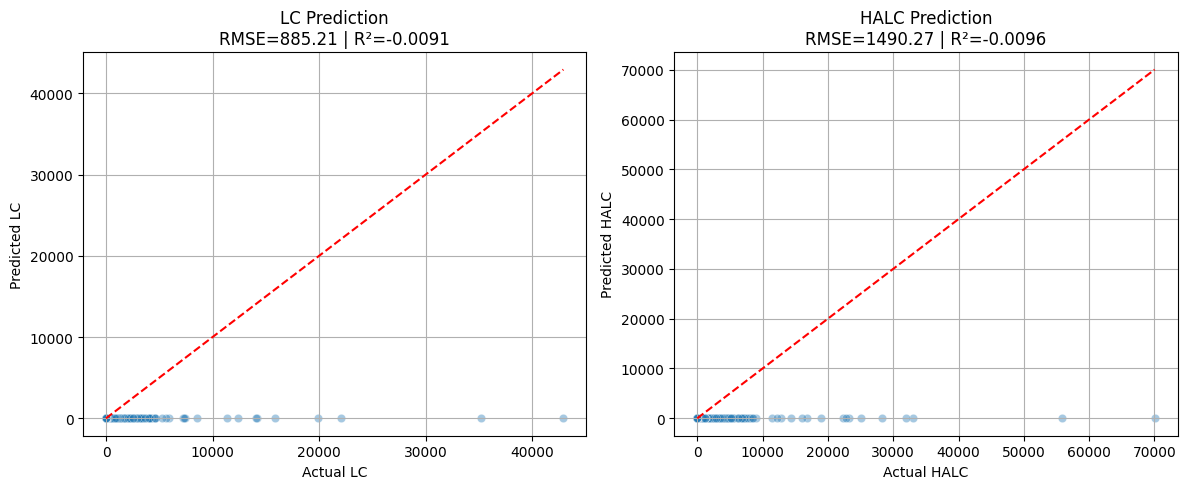

In [ ]:
# === Step 0: Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

# === Step 1: Prepare Data ===
train = train_data.copy()

# === Step 2: Log Transform Targets ===
epsilon = 1e-8
train['LC_log'] = np.log(train['LC'] + epsilon)
train['HALC_log'] = np.log(train['HALC'] + epsilon)

# === Step 3: Define Features and Targets ===
X = train.drop(columns=['LC', 'HALC', 'CS', 'LC_log', 'HALC_log'], errors='ignore')
y_lc = train['LC_log']
y_halc = train['HALC_log']

# === Step 4: Train-Test Split ===
X_train_lc, X_val_lc, y_train_lc, y_val_lc = train_test_split(X, y_lc, test_size=0.2, random_state=42)
X_train_halc, X_val_halc, y_train_halc, y_val_halc = train_test_split(X, y_halc, test_size=0.2, random_state=42)

# === Step 5: Feature Normalization ===
scaler_lc = StandardScaler()
X_train_lc = scaler_lc.fit_transform(X_train_lc)
X_val_lc = scaler_lc.transform(X_val_lc)

scaler_halc = StandardScaler()
X_train_halc = scaler_halc.fit_transform(X_train_halc)
X_val_halc = scaler_halc.transform(X_val_halc)

# === Step 6: Model Architecture ===
def build_model(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, kernel_regularizer=l1_l2(1e-5, 1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, kernel_regularizer=l1_l2(1e-5, 1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32),
        LeakyReLU(alpha=0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.0005), loss='mse', metrics=['mse'])
    return model

# === Step 7: Train Models ===
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5)
]

model_lc = build_model(X_train_lc.shape[1])
model_lc.fit(X_train_lc, y_train_lc, validation_data=(X_val_lc, y_val_lc),
             epochs=50, batch_size=64, verbose=1, callbacks=callbacks)

model_halc = build_model(X_train_halc.shape[1])
model_halc.fit(X_train_halc, y_train_halc, validation_data=(X_val_halc, y_val_halc),
               epochs=50, batch_size=64, verbose=1, callbacks=callbacks)

# === Step 8: Predict and Inverse Transform ===
preds_lc = np.exp(model_lc.predict(X_val_lc).flatten()) - epsilon
preds_halc = np.exp(model_halc.predict(X_val_halc).flatten()) - epsilon

true_lc = np.exp(y_val_lc) - epsilon
true_halc = np.exp(y_val_halc) - epsilon

# === Step 9: Evaluation ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{label}] RMSE: {rmse:.2f} | MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")
    return mse, rmse, mae, r2

print("\n=== Neural Net Log-Transformed Model Performance ===")
metrics_lc = evaluate(true_lc, preds_lc, "LC")
metrics_halc = evaluate(true_halc, preds_halc, "HALC")

# === Step 10: Actual vs Predicted Plots ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=true_lc, y=preds_lc, alpha=0.4)
plt.plot([true_lc.min(), true_lc.max()], [true_lc.min(), true_lc.max()], 'r--')
plt.title(f"LC Prediction\nRMSE={metrics_lc[1]:.2f} | R²={metrics_lc[3]:.4f}")
plt.xlabel("Actual LC")
plt.ylabel("Predicted LC")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.scatterplot(x=true_halc, y=preds_halc, alpha=0.4)
plt.plot([true_halc.min(), true_halc.max()], [true_halc.min(), true_halc.max()], 'r--')
plt.title(f"HALC Prediction\nRMSE={metrics_halc[1]:.2f} | R²={metrics_halc[3]:.4f}")
plt.xlabel("Actual HALC")
plt.ylabel("Predicted HALC")
plt.grid(True)

plt.tight_layout()
plt.show()
